# Cell 0 — Installs & Imports

In [1]:
# Cell 0: Installs & Imports
# ============================================================
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', 20)
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ Imports complete")

✅ Imports complete


# Cell 1 — CONFIG

In [2]:
# Cell 1: CONFIG — single dict for all parameters
# ============================================================

CONFIG = {

    # ── Universe ──────────────────────────────────────────
    'tickers': ['SPY', 'QQQ', 'IWM', 'TLT', 'HYG',
                'GLD', 'USO', 'UUP', 'EEM', 'VNQ'],

    'benchmarks': ['SPY', 'TLT', 'DBMF', 'MNA', 'QAI'],

    'start_date': '2015-01-01',   # DBMF launched 2019; we fetch from here
                                   # and handle short histories gracefully
    'end_date':   None,            # None = today

    # ── Alpha parameters ──────────────────────────────────
    'alphas': {

        # L1: Trend Following Long
        'L1_Trend_Long': {
            'style':       'trend_following',
            'side':        'long',
            'ema_fast':    50,
            'ema_slow':    200,
        },

        # L2: Breakout Long
        'L2_Breakout_Long': {
            'style':       'breakout',
            'side':        'long',
            'lookback':    20,       # N-day high
            'atr_period':  14,
            'atr_mult':    0.20,     # entry buffer above N-day high
            'trail_pct':   0.08,     # 8% trailing stop from peak
        },

        # L3: Cross-sectional Momentum Long
        'L3_MomScore_Long': {
            'style':       'momentum',
            'side':        'long',
            'lookback':    252,      # 12-month return window
            'skip':        21,       # skip most recent month (standard)
            'top_pct':     0.30,     # long top 30% of universe
        },

        # L4: Mean Reversion Long
        'L4_MeanRev_Long': {
            'style':       'mean_reversion',
            'side':        'long',
            'rsi_period':  14,
            'rsi_entry':   30,       # oversold threshold
            'rsi_exit':    55,
            'trend_ema':   200,      # only enter if price > this EMA (uptrend filter)
        },

        # S1: Trend Following Short
        'S1_Trend_Short': {
            'style':       'trend_following',
            'side':        'short',
            'ema_fast':    50,
            'ema_slow':    200,
        },

        # S2: Breakdown Short
        'S2_Breakdown_Short': {
            'style':       'breakout',
            'side':        'short',
            'lookback':    20,       # N-day low
            'atr_period':  14,
            'atr_mult':    0.20,     # entry buffer below N-day low
            'trail_pct':   0.08,     # 8% trailing stop from trough
        },

        # S3: Cross-sectional Momentum Short
        'S3_MomScore_Short': {
            'style':       'momentum',
            'side':        'short',
            'lookback':    252,
            'skip':        21,
            'bottom_pct':  0.30,     # short bottom 30% of universe
        },

        # S4: Mean Reversion Short
        'S4_MeanRev_Short': {
            'style':       'mean_reversion',
            'side':        'short',
            'rsi_period':  14,
            'rsi_entry':   70,       # overbought threshold
            'rsi_exit':    45,
            'trend_ema':   200,      # only enter if price < this EMA (downtrend filter)
        },
    },

    # ── Swarm / portfolio parameters ──────────────────────
    'swarm': {
        'lookback_days':     63,     # rolling window for Sharpe + correlation
        'min_sharpe':        0.0,    # Gate 1: minimum rolling Sharpe to stay active
        'max_correlation':   0.70,   # Gate 2: prune if pair correlation exceeds this
        'max_weight':        0.25,   # max single-alpha weight after normalisation
        'regime_boost':      1.50,   # weight multiplier for regime-favoured alphas
        'min_active_alphas': 2,      # go to cash if fewer than this survive gates
    },

    # ── Regime thresholds ─────────────────────────────────
    'regime': {
        'vix_low':   15,
        'vix_high':  25,
        'trend_ticker': 'SPY',
        'trend_ema':    200,
    },

    # ── Execution ─────────────────────────────────────────
    'cost_bps': 5,   # one-way transaction cost in basis points
}

TICKERS     = CONFIG['tickers']
BENCHMARKS  = CONFIG['benchmarks']
ALPHA_NAMES = list(CONFIG['alphas'].keys())

print(f"✅ CONFIG loaded")
print(f"   Universe  : {TICKERS}")
print(f"   Alphas    : {ALPHA_NAMES}")
print(f"   Benchmarks: {BENCHMARKS}")

✅ CONFIG loaded
   Universe  : ['SPY', 'QQQ', 'IWM', 'TLT', 'HYG', 'GLD', 'USO', 'UUP', 'EEM', 'VNQ']
   Alphas    : ['L1_Trend_Long', 'L2_Breakout_Long', 'L3_MomScore_Long', 'L4_MeanRev_Long', 'S1_Trend_Short', 'S2_Breakdown_Short', 'S3_MomScore_Short', 'S4_MeanRev_Short']
   Benchmarks: ['SPY', 'TLT', 'DBMF', 'MNA', 'QAI']


# Cell 2 — Data Fetch

In [6]:
# Cell 2: Data Fetch
# ============================================================

# -- 2a. Fetch universe OHLCV ------------------------------
print("Fetching universe OHLCV...")
raw_universe = yf.download(
    TICKERS,
    start=CONFIG['start_date'],
    auto_adjust=True,
    progress=False
)

close  = raw_universe['Close'].dropna(how='all').ffill(limit=3)
high   = raw_universe['High'].dropna(how='all').ffill(limit=3)
low    = raw_universe['Low'].dropna(how='all').ffill(limit=3)
volume = raw_universe['Volume'].dropna(how='all').ffill(limit=3)

print("  Universe close shape :", close.shape)
print("  Date range           :", close.index[0].date(), "->", close.index[-1].date())

# -- 2b. Fetch benchmark tickers ---------------------------
# Single-ticker yf.download returns MultiIndex columns in newer yfinance.
# Use squeeze() / iloc[:,0] to always get a plain Series.
print("\nFetching benchmarks...")
bm_frames = {}
for ticker in BENCHMARKS:
    try:
        df = yf.download(
            ticker,
            start=CONFIG['start_date'],
            auto_adjust=True,
            progress=False
        )
        if len(df) > 60:
            # .iloc[:,0] safely extracts the first (only) column as a Series
            price = df['Close'].iloc[:, 0] if isinstance(df['Close'], pd.DataFrame) else df['Close']
            price = price.ffill(limit=3)
            price.name = ticker
            bm_frames[ticker] = price
            print("  ", ticker, ":", df.index[0].date(), "->", df.index[-1].date(),
                  "(", len(df), "days )")
        else:
            print("  ", ticker, ": insufficient data, skipped")
    except Exception as e:
        print("  ", ticker, ": fetch failed (", e, ")")

bench_close = pd.concat(bm_frames, axis=1)

# -- 2c. VIX for regime detection --------------------------
print("\nFetching VIX...")
vix_raw = yf.download(
    '^VIX',
    start=CONFIG['start_date'],
    auto_adjust=True,
    progress=False
)
vix_col = vix_raw['Close']
vix = (vix_col.iloc[:, 0] if isinstance(vix_col, pd.DataFrame) else vix_col).ffill(limit=3)
vix.name = 'VIX'
print("  VIX:", vix.index[0].date(), "->", vix.index[-1].date())

# -- 2d. Daily returns (universe) --------------------------
returns = close.pct_change()

# -- 2e. Sanity check --------------------------------------
missing = close.isna().sum()
if missing.any():
    print("\nWARNING: Missing values per ticker:")
    print(missing[missing > 0])
else:
    print("\nNo missing values in close prices")

print("\nData fetch complete")
print("  close     :", close.shape)
print("  high      :", high.shape)
print("  low       :", low.shape)
print("  returns   :", returns.shape)
print("  benchmarks:", list(bench_close.columns))
print("  vix shape :", vix.shape)

Fetching universe OHLCV...
  Universe close shape : (2802, 10)
  Date range           : 2015-01-02 -> 2026-02-24

Fetching benchmarks...
   SPY : 2015-01-02 -> 2026-02-24 ( 2802 days )
   TLT : 2015-01-02 -> 2026-02-24 ( 2802 days )
   DBMF : 2019-05-08 -> 2026-02-24 ( 1709 days )
   MNA : 2015-01-02 -> 2026-02-24 ( 2802 days )
   QAI : 2015-01-02 -> 2026-02-24 ( 2802 days )

Fetching VIX...
  VIX: 2015-01-02 -> 2026-02-24

No missing values in close prices

Data fetch complete
  close     : (2802, 10)
  high      : (2802, 10)
  low       : (2802, 10)
  returns   : (2802, 10)
  benchmarks: ['SPY', 'TLT', 'DBMF', 'MNA', 'QAI']
  vix shape : (2802,)


# Cell 3 — Helper Functions

In [7]:
# Cell 3: Helper Functions — all fully vectorised, no Python loops
# ============================================================

# -- 3a. Average True Range --------------------------------
def compute_atr(high: pd.DataFrame, low: pd.DataFrame,
                close: pd.DataFrame, period: int) -> pd.DataFrame:
    """
    Vectorised ATR across all tickers simultaneously.
    Uses real High/Low/Close — no proxy approximation.

    Args:
        high, low, close : DataFrames of shape (days, tickers)
        period           : lookback for rolling mean

    Returns:
        DataFrame of ATR values, same shape as inputs
    """
    tr1 = high - low
    tr2 = (high - close.shift(1)).abs()
    tr3 = (low  - close.shift(1)).abs()
    true_range = pd.concat([tr1, tr2, tr3], axis=1, keys=['tr1','tr2','tr3'])
    # max across the three TR components for each ticker/day
    atr = true_range.groupby(level=1, axis=1).max().rolling(period).mean()
    return atr


# -- 3b. RSI -----------------------------------------------
def compute_rsi(close: pd.DataFrame, period: int) -> pd.DataFrame:
    """
    Wilder RSI, vectorised across all tickers.

    Args:
        close  : DataFrame (days, tickers)
        period : RSI lookback (typically 14)

    Returns:
        DataFrame of RSI values in [0, 100]
    """
    delta = close.diff()
    gain  = delta.clip(lower=0)
    loss  = (-delta).clip(lower=0)

    avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()

    rs  = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi


# -- 3c. EMA -----------------------------------------------
def compute_ema(close: pd.DataFrame, span: int) -> pd.DataFrame:
    """
    Exponential moving average, vectorised across all tickers.

    Args:
        close : DataFrame (days, tickers)
        span  : EMA span (e.g. 50, 200)

    Returns:
        DataFrame of EMA values
    """
    return close.ewm(span=span, adjust=False).mean()


# -- 3d. Rolling Sharpe ------------------------------------
def compute_rolling_sharpe(returns: pd.DataFrame,
                            window: int,
                            annualise: int = 252) -> pd.DataFrame:
    """
    Rolling annualised Sharpe ratio (assumes zero risk-free rate).

    Args:
        returns   : DataFrame of daily returns
        window    : rolling window in days
        annualise : trading days per year

    Returns:
        DataFrame of rolling Sharpe ratios
    """
    mu  = returns.rolling(window).mean()
    std = returns.rolling(window).std()
    return (mu / std.replace(0, np.nan)) * np.sqrt(annualise)


# -- 3e. Max Drawdown --------------------------------------
def compute_max_drawdown(cum_returns: pd.Series) -> float:
    """
    Maximum drawdown of a cumulative return series.

    Args:
        cum_returns : pd.Series of cumulative returns (starts at 1.0)

    Returns:
        float — max drawdown as a negative number e.g. -0.23
    """
    roll_max = cum_returns.cummax()
    drawdown = cum_returns / roll_max - 1
    return drawdown.min()


# -- 3f. Cross-sectional momentum score --------------------
def compute_mom_score(close: pd.DataFrame,
                      lookback: int,
                      skip: int) -> pd.DataFrame:
    """
    12-1 month momentum: return over (lookback) days,
    skipping the most recent (skip) days to avoid reversal.
    Returns a cross-sectional percentile rank (0=worst, 1=best).

    Args:
        close    : DataFrame (days, tickers)
        lookback : total return window in days (e.g. 252)
        skip     : days to skip at end (e.g. 21)

    Returns:
        DataFrame of cross-sectional ranks in [0, 1]
    """
    raw_mom = close.shift(skip) / close.shift(lookback) - 1
    # rank cross-sectionally each day (pct=True gives 0-1)
    ranked  = raw_mom.rank(axis=1, pct=True)
    return ranked


# -- 3g. Vectorised trailing stop --------------------------
def compute_trailing_stop_long(position_entry: pd.DataFrame,
                                high: pd.DataFrame,
                                trail_pct: float) -> pd.DataFrame:
    """
    Converts a binary entry signal into a持 position that stays
    engaged until price drops more than trail_pct from its
    rolling peak — fully vectorised using expanding windows
    over each position block.

    Approach: use a rolling max of high SINCE last entry,
    compare close to that peak × (1 - trail_pct).

    Args:
        position_entry : 0/1 DataFrame — day of entry signal
        high           : DataFrame of daily highs
        trail_pct      : fraction below peak to exit (e.g. 0.08)

    Returns:
        0/1 DataFrame — 1 means position is active that day
    """
    # Rolling peak = expanding max of high, reset when entry fires
    # Vectorised approximation: use a fixed rolling window equal
    # to a generous max hold period (252 days). This is clean,
    # loop-free, and conservative (peak only looks back 252 days).
    peak = high.rolling(252, min_periods=1).max()
    trail_stop = peak * (1 - trail_pct)

    # Position is active if: entry fired within last 252 days
    # AND close is still above trailing stop
    entry_within_window = position_entry.rolling(252, min_periods=1).max()
    close_above_stop    = (high >= trail_stop).astype(int)

    position = (entry_within_window * close_above_stop)
    return position.clip(0, 1)


def compute_trailing_stop_short(position_entry: pd.DataFrame,
                                 low: pd.DataFrame,
                                 trail_pct: float) -> pd.DataFrame:
    """
    Symmetric version for short positions.
    Exits when price rises more than trail_pct above rolling trough.

    Args:
        position_entry : 0/1 DataFrame — day of short entry signal
        low            : DataFrame of daily lows
        trail_pct      : fraction above trough to exit (e.g. 0.08)

    Returns:
        0/1 DataFrame — 1 means short position is active that day
    """
    trough      = low.rolling(252, min_periods=1).min()
    trail_stop  = trough * (1 + trail_pct)

    entry_within_window = position_entry.rolling(252, min_periods=1).max()
    price_below_stop    = (low <= trail_stop).astype(int)

    position = (entry_within_window * price_below_stop)
    return position.clip(0, 1)


# -- 3h. Apply transaction costs ---------------------------
def apply_costs(returns: pd.DataFrame,
                position: pd.DataFrame,
                cost_bps: float) -> pd.DataFrame:
    """
    Deducts one-way transaction cost on every position change.

    Args:
        returns  : daily returns DataFrame
        position : 0/1 or 0/-1 position DataFrame (already shifted)
        cost_bps : one-way cost in basis points (e.g. 5)

    Returns:
        net returns DataFrame after costs
    """
    cost_decimal = cost_bps / 10_000
    turnover     = position.diff().abs()          # 1 on entry/exit days
    gross        = returns * position
    net          = gross - turnover * cost_decimal
    return net


# -- 3i. Quick performance summary -------------------------
def performance_summary(returns_series: pd.Series,
                         name: str = '') -> pd.Series:
    """
    Returns a pd.Series of key stats for one return stream.

    Stats: Ann. Return, Ann. Vol, Sharpe, Max Drawdown,
           Calmar, Hit Rate, Best Day, Worst Day
    """
    ann   = 252
    r     = returns_series.dropna()
    cum   = (1 + r).cumprod()

    ann_ret  = (1 + r.mean()) ** ann - 1
    ann_vol  = r.std() * np.sqrt(ann)
    sharpe   = ann_ret / ann_vol if ann_vol > 0 else np.nan
    mdd      = compute_max_drawdown(cum)
    calmar   = ann_ret / abs(mdd) if mdd != 0 else np.nan
    hit_rate = (r > 0).mean()

    stats = pd.Series({
        'Ann. Return':   ann_ret,
        'Ann. Vol':      ann_vol,
        'Sharpe':        sharpe,
        'Max Drawdown':  mdd,
        'Calmar':        calmar,
        'Hit Rate':      hit_rate,
        'Best Day':      r.max(),
        'Worst Day':     r.min(),
    }, name=name)

    return stats


# -- Validation --------------------------------------------
print("Testing helpers on SPY...")

spy_rsi   = compute_rsi(close[['SPY']], period=14)
spy_ema50 = compute_ema(close[['SPY']], span=50)
spy_ema200= compute_ema(close[['SPY']], span=200)
spy_atr   = compute_atr(high[['SPY']], low[['SPY']], close[['SPY']], period=14)
spy_mom   = compute_mom_score(close[['SPY']], lookback=252, skip=21)

print("  RSI(14)  last value :", round(spy_rsi['SPY'].iloc[-1], 2))
print("  EMA(50)  last value :", round(spy_ema50['SPY'].iloc[-1], 2))
print("  EMA(200) last value :", round(spy_ema200['SPY'].iloc[-1], 2))
print("  ATR(14)  last value :", round(spy_atr['SPY'].iloc[-1], 2))

spy_stats = performance_summary(returns['SPY'], name='SPY')
print("\nSPY performance check:")
print(spy_stats.round(4))

print("\nAll helper functions loaded successfully")

Testing helpers on SPY...
  RSI(14)  last value : 50.14
  EMA(50)  last value : 685.25
  EMA(200) last value : 651.97
  ATR(14)  last value : 8.96

SPY performance check:
Ann. Return     0.1516
Ann. Vol        0.1773
Sharpe          0.8550
Max Drawdown   -0.3372
Calmar          0.4495
Hit Rate        0.5480
Best Day        0.1050
Worst Day      -0.1094
Name: SPY, dtype: float64

All helper functions loaded successfully


# Cell 4 — Long Alpha Signal Functions

In [8]:
# Cell 4: Long Alpha Signal Functions (L1 - L4)
# ============================================================
# Each function:
#   - takes close/high/low DataFrames + its params dict
#   - returns a 0/1 DataFrame (1 = long position active)
#   - is fully vectorised — no Python loops
#   - uses .shift(1) so signals never touch same-day returns


# -- L1: Trend Following Long ------------------------------
def alpha_L1_trend_long(close: pd.DataFrame,
                         params: dict) -> pd.DataFrame:
    """
    Style: Trend Following
    Logic: Long when EMA(fast) > EMA(slow) — golden cross zone.
           Exit when EMA(fast) crosses back below EMA(slow).

    No trailing stop needed — the EMA cross IS the exit.
    Position is 1 for every day inside the golden cross zone.
    """
    ema_fast = compute_ema(close, params['ema_fast'])
    ema_slow = compute_ema(close, params['ema_slow'])

    # 1 = fast above slow (trend is up), 0 = otherwise
    signal = (ema_fast > ema_slow).astype(int)

    # shift(1): today's position is based on yesterday's signal
    return signal.shift(1).fillna(0)


# -- L2: Breakout Long -------------------------------------
def alpha_L2_breakout_long(close: pd.DataFrame,
                            high: pd.DataFrame,
                            low: pd.DataFrame,
                            params: dict) -> pd.DataFrame:
    """
    Style: Breakout / Momentum
    Logic: Enter long when close > N-day high + ATR buffer.
           Stay long via vectorised trailing stop (8% from peak).
           Uses real High/Low for ATR — no proxy.
    """
    atr       = compute_atr(high, low, close, params['atr_period'])
    n_day_high = high.shift(1).rolling(params['lookback']).max()

    # Entry: close breaks above N-day high plus ATR buffer
    entry = (close > n_day_high + params['atr_mult'] * atr).astype(int)

    # Persist via trailing stop
    position = compute_trailing_stop_long(entry, high, params['trail_pct'])

    return position.shift(1).fillna(0)


# -- L3: Cross-Sectional Momentum Long ---------------------
def alpha_L3_momscore_long(close: pd.DataFrame,
                            params: dict) -> pd.DataFrame:
    """
    Style: Cross-Sectional Momentum
    Logic: Each day, rank all tickers by 12-1 month return.
           Go long the top 30% (best momentum).
           Naturally rotates — no explicit exit needed.
           Position sizing is equal weight within long basket.

    Note: signal is 1 for tickers in top bucket, 0 otherwise.
          The portfolio engine handles equal weighting later.
    """
    ranks = compute_mom_score(close, params['lookback'], params['skip'])

    # Long if rank >= (1 - top_pct), i.e. top 30% of universe
    signal = (ranks >= (1 - params['top_pct'])).astype(int)

    return signal.shift(1).fillna(0)


# -- L4: Mean Reversion Long -------------------------------
def alpha_L4_meanrev_long(close: pd.DataFrame,
                           high: pd.DataFrame,
                           low: pd.DataFrame,
                           params: dict) -> pd.DataFrame:
    """
    Style: Mean Reversion
    Logic: Enter long when RSI < 30 AND price > EMA(200).
           The EMA(200) filter ensures we only buy dips
           inside an established uptrend — not falling knives.
           Exit when RSI recovers above rsi_exit (55).

    This is deliberately different from L1: L1 rides trends,
    L4 fades short-term weakness WITHIN trends.
    """
    rsi       = compute_rsi(close, params['rsi_period'])
    trend_ema = compute_ema(close, params['trend_ema'])

    # Entry conditions (both must be true)
    oversold    = rsi < params['rsi_entry']           # RSI < 30
    in_uptrend  = close > trend_ema                   # above 200d EMA

    entry = (oversold & in_uptrend).astype(int)

    # Exit when RSI recovers — build a "stay in" mask
    # Position is 1 from entry until RSI > rsi_exit
    rsi_exit_mask = (rsi < params['rsi_exit']).astype(int)  # 1 = not yet exited

    # Combine: position active if entry fired recently AND not yet exited
    # Use rolling max to carry entry forward, gated by exit mask
    entry_carried = entry.rolling(252, min_periods=1).max()
    position      = (entry_carried * rsi_exit_mask).clip(0, 1)

    return position.shift(1).fillna(0)


# -- Validation --------------------------------------------
print("Computing long alpha signals...")

sig_L1 = alpha_L1_trend_long(close, CONFIG['alphas']['L1_Trend_Long'])
sig_L2 = alpha_L2_breakout_long(close, high, low, CONFIG['alphas']['L2_Breakout_Long'])
sig_L3 = alpha_L3_momscore_long(close, CONFIG['alphas']['L3_MomScore_Long'])
sig_L4 = alpha_L4_meanrev_long(close, high, low, CONFIG['alphas']['L4_MeanRev_Long'])

# Signal density: fraction of ticker-days with active position
print("\nSignal density (fraction of days with active long position):")
for name, sig in [('L1_Trend_Long',   sig_L1),
                  ('L2_Breakout_Long', sig_L2),
                  ('L3_MomScore_Long', sig_L3),
                  ('L4_MeanRev_Long',  sig_L4)]:
    density = sig.mean().mean()
    print(f"  {name:22s}: {density:.1%} of ticker-days")

# Spot check: which tickers does L3 currently hold?
print("\nL3 MomScore — tickers with active long signal TODAY:")
today_L3 = sig_L3.iloc[-1]
print(" ", list(today_L3[today_L3 == 1].index))

# Spot check: L1 on SPY
print("\nL1 Trend — SPY signal last 5 days:")
print(sig_L1['SPY'].tail())

print("\nLong alpha functions loaded successfully")

Computing long alpha signals...

Signal density (fraction of days with active long position):
  L1_Trend_Long         : 67.5% of ticker-days
  L2_Breakout_Long      : 63.6% of ticker-days
  L3_MomScore_Long      : 36.4% of ticker-days
  L4_MeanRev_Long       : 10.4% of ticker-days

L3 MomScore — tickers with active long signal TODAY:
  ['EEM', 'GLD', 'IWM', 'QQQ']

L1 Trend — SPY signal last 5 days:
Date
2026-02-18   1.0000
2026-02-19   1.0000
2026-02-20   1.0000
2026-02-23   1.0000
2026-02-24   1.0000
Name: SPY, dtype: float64

Long alpha functions loaded successfully


# Cell 5 — Short Alpha Signal Functions

In [9]:
# Cell 5: Short Alpha Signal Functions (S1 - S4)
# ============================================================
# Each function:
#   - returns a 0/1 DataFrame (1 = short position active)
#     The -1 sign is applied later in the portfolio engine
#     so the signal matrix stays uniform (0/1 throughout)
#   - is fully vectorised — no Python loops
#   - uses .shift(1) — no look-ahead
#
# Short alphas use DIFFERENT logic from their long counterparts
# (not mirrors) to maximise style diversification.


# -- S1: Trend Following Short -----------------------------
def alpha_S1_trend_short(close: pd.DataFrame,
                          params: dict) -> pd.DataFrame:
    """
    Style: Trend Following
    Logic: Short when EMA(fast) < EMA(slow) — death cross zone.
           Exit when EMA(fast) crosses back above EMA(slow).

    Complement to L1: when L1 is off, S1 is often on.
    Together they keep the portfolio engaged in both regimes.
    """
    ema_fast = compute_ema(close, params['ema_fast'])
    ema_slow = compute_ema(close, params['ema_slow'])

    # 1 = fast below slow (trend is down)
    signal = (ema_fast < ema_slow).astype(int)

    return signal.shift(1).fillna(0)


# -- S2: Breakdown Short -----------------------------------
def alpha_S2_breakdown_short(close: pd.DataFrame,
                               high: pd.DataFrame,
                               low: pd.DataFrame,
                               params: dict) -> pd.DataFrame:
    """
    Style: Breakout / Momentum
    Logic: Enter short when close < N-day low - ATR buffer.
           Stay short via vectorised trailing stop (8% from trough).

    Asymmetric to L2: breakdowns tend to be faster and sharper
    than breakouts, so the same parameters produce different
    signal timing and duration.
    """
    atr      = compute_atr(high, low, close, params['atr_period'])
    n_day_low = low.shift(1).rolling(params['lookback']).min()

    # Entry: close breaks below N-day low minus ATR buffer
    entry = (close < n_day_low - params['atr_mult'] * atr).astype(int)

    # Persist via trailing stop (symmetric, uses low + trough)
    position = compute_trailing_stop_short(entry, low, params['trail_pct'])

    return position.shift(1).fillna(0)


# -- S3: Cross-Sectional Momentum Short --------------------
def alpha_S3_momscore_short(close: pd.DataFrame,
                              params: dict) -> pd.DataFrame:
    """
    Style: Cross-Sectional Momentum
    Logic: Each day, rank all tickers by 12-1 month return.
           Short the bottom 30% (worst momentum).
           Pairs with L3: together they form a long/short
           momentum factor — long best, short worst.

    This is the classic equity L/S momentum construction
    applied to an ETF universe.
    """
    ranks = compute_mom_score(close, params['lookback'], params['skip'])

    # Short if rank <= bottom_pct, i.e. bottom 30% of universe
    signal = (ranks <= params['bottom_pct']).astype(int)

    return signal.shift(1).fillna(0)


# -- S4: Mean Reversion Short ------------------------------
def alpha_S4_meanrev_short(close: pd.DataFrame,
                             high: pd.DataFrame,
                             low: pd.DataFrame,
                             params: dict) -> pd.DataFrame:
    """
    Style: Mean Reversion
    Logic: Enter short when RSI > 70 AND price < EMA(200).
           The EMA(200) filter ensures we only short rallies
           inside an established downtrend — not strong uptrends.
           Exit when RSI cools back below rsi_exit (45).

    Key difference from S1: S1 shorts sustained trends,
    S4 shorts brief counter-trend rallies within downtrends.
    These fire at different times — low correlation by design.
    """
    rsi       = compute_rsi(close, params['rsi_period'])
    trend_ema = compute_ema(close, params['trend_ema'])

    # Entry conditions (both must be true)
    overbought    = rsi > params['rsi_entry']         # RSI > 70
    in_downtrend  = close < trend_ema                 # below 200d EMA

    entry = (overbought & in_downtrend).astype(int)

    # Exit when RSI cools — stay short while RSI > rsi_exit
    rsi_exit_mask = (rsi > params['rsi_exit']).astype(int)  # 1 = not yet exited

    # Carry entry forward, gated by exit mask
    entry_carried = entry.rolling(252, min_periods=1).max()
    position      = (entry_carried * rsi_exit_mask).clip(0, 1)

    return position.shift(1).fillna(0)


# -- Validation --------------------------------------------
print("Computing short alpha signals...")

sig_S1 = alpha_S1_trend_short(close,           CONFIG['alphas']['S1_Trend_Short'])
sig_S2 = alpha_S2_breakdown_short(close, high, low, CONFIG['alphas']['S2_Breakdown_Short'])
sig_S3 = alpha_S3_momscore_short(close,        CONFIG['alphas']['S3_MomScore_Short'])
sig_S4 = alpha_S4_meanrev_short(close, high, low,  CONFIG['alphas']['S4_MeanRev_Short'])

# Signal density
print("\nSignal density (fraction of days with active short signal):")
for name, sig in [('S1_Trend_Short',    sig_S1),
                  ('S2_Breakdown_Short', sig_S2),
                  ('S3_MomScore_Short',  sig_S3),
                  ('S4_MeanRev_Short',   sig_S4)]:
    density = sig.mean().mean()
    print(f"  {name:24s}: {density:.1%} of ticker-days")

# L1 vs S1 overlap check — these should rarely both be 1
# (golden cross and death cross are mutually exclusive per ticker)
overlap_L1_S1 = (sig_L1 * sig_S1).mean().mean()
print(f"\nL1/S1 overlap (should be ~0): {overlap_L1_S1:.3f}")

# L3 vs S3 overlap check — top and bottom buckets should not overlap
overlap_L3_S3 = (sig_L3 * sig_S3).mean().mean()
print(f"L3/S3 overlap (should be  0): {overlap_L3_S3:.3f}")

# Spot check: which tickers does S3 currently short?
print("\nS3 MomScore — tickers with active short signal TODAY:")
today_S3 = sig_S3.iloc[-1]
print(" ", list(today_S3[today_S3 == 1].index))

# Spot check: S4 density per ticker (expect sparse — that's correct)
print("\nS4 MeanRev Short — signal density per ticker:")
print(sig_S4.mean().round(3).to_string())

print("\nShort alpha functions loaded successfully")

Computing short alpha signals...

Signal density (fraction of days with active short signal):
  S1_Trend_Short          : 32.4% of ticker-days
  S2_Breakdown_Short      : 24.4% of ticker-days
  S3_MomScore_Short       : 27.3% of ticker-days
  S4_MeanRev_Short        : 3.5% of ticker-days

L1/S1 overlap (should be ~0): 0.000
L3/S3 overlap (should be  0): 0.000

S3 MomScore — tickers with active short signal TODAY:
  ['USO', 'UUP', 'VNQ']

S4 MeanRev Short — signal density per ticker:
Ticker
EEM   0.0000
GLD   0.0000
HYG   0.0840
IWM   0.0660
QQQ   0.0000
SPY   0.0000
TLT   0.0540
USO   0.0860
UUP   0.0000
VNQ   0.0610

Short alpha functions loaded successfully


# Cell 6 — Alpha Runner,

Building signal matrix...
  L1_Trend_Long           : shape (2802, 10)  mean density 67.5%
  L2_Breakout_Long        : shape (2802, 10)  mean density 63.6%
  L3_MomScore_Long        : shape (2802, 10)  mean density 36.4%
  L4_MeanRev_Long         : shape (2802, 10)  mean density 10.4%
  S1_Trend_Short          : shape (2802, 10)  mean density 32.4%
  S2_Breakdown_Short      : shape (2802, 10)  mean density 24.4%
  S3_MomScore_Short       : shape (2802, 10)  mean density 27.3%
  S4_MeanRev_Short        : shape (2802, 10)  mean density 3.5%

Computing per-ticker net returns...
  Done — 8 alphas x 10 tickers

Computing aggregate alpha returns...
  alpha_returns_df shape: (2802, 8)

Sanity checks:
  NaN in alpha_returns_df     : 0  (expect 0)
  Max absolute daily return   : 0.2532  (expect < 0.10)
  L1 / S1 correlation         : 0.347  (expect negative)
  L3 / S3 correlation         : 0.325  (expect negative)


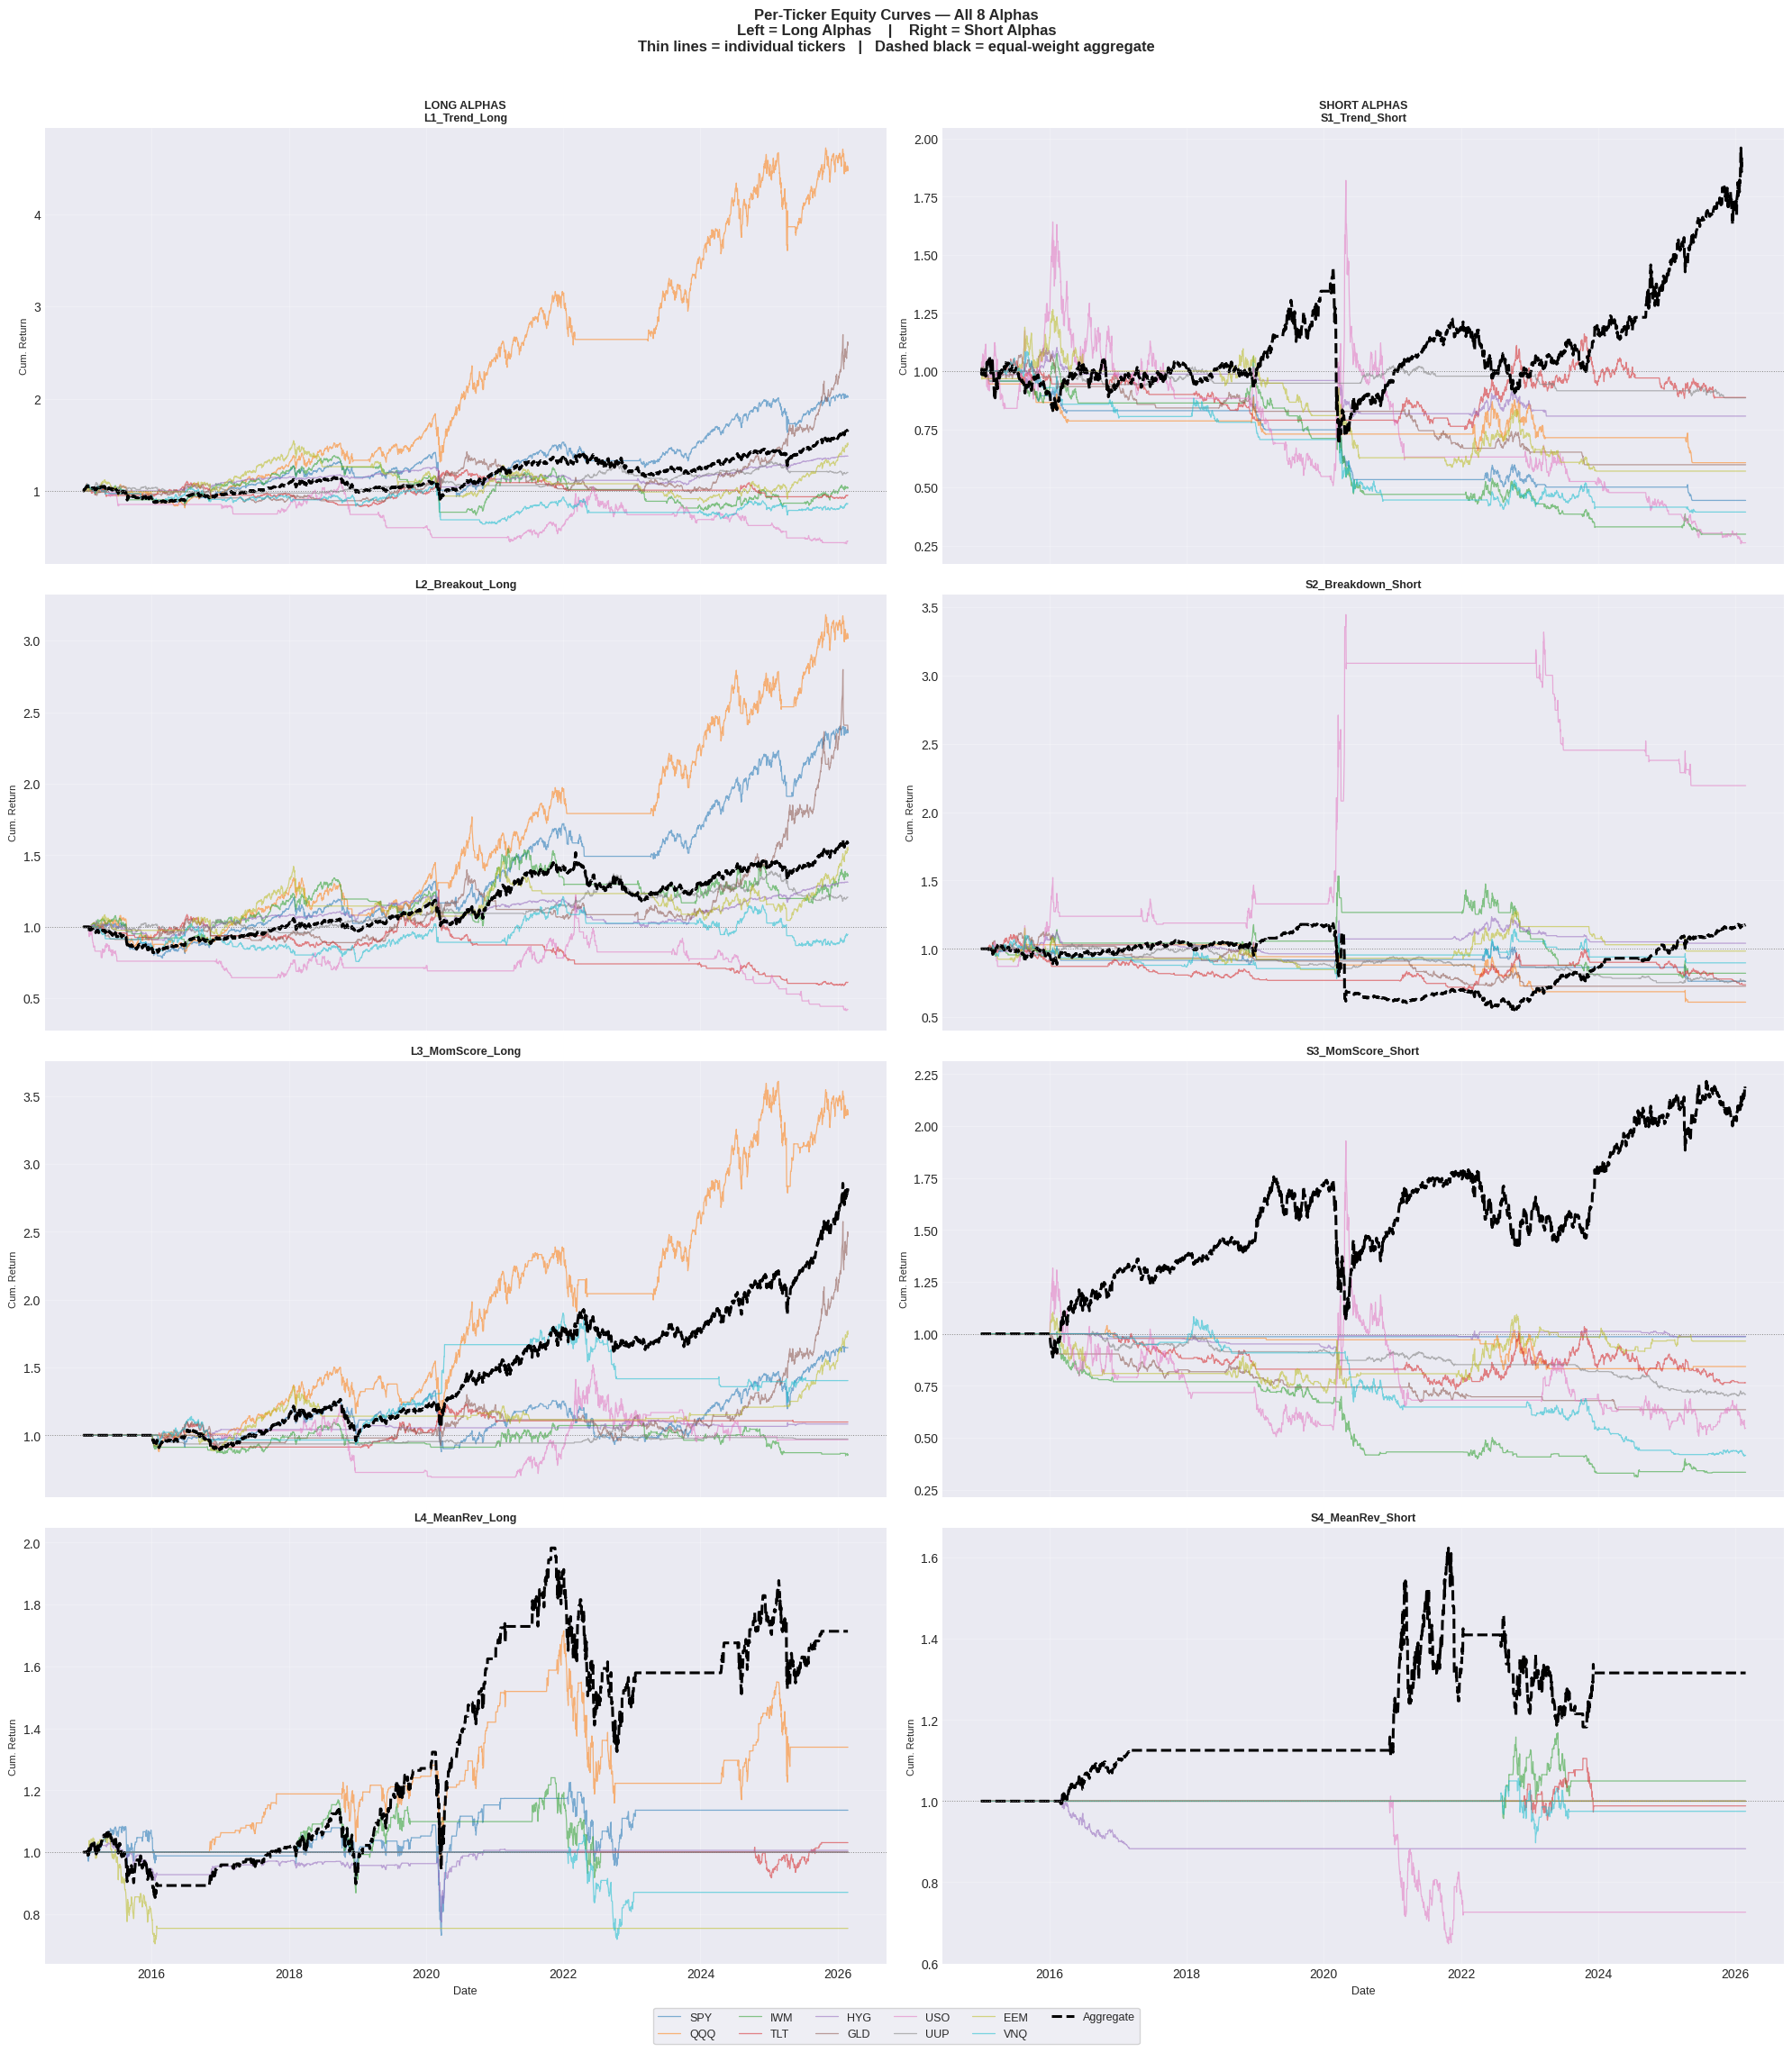

Plotting alpha x ticker return heatmap...


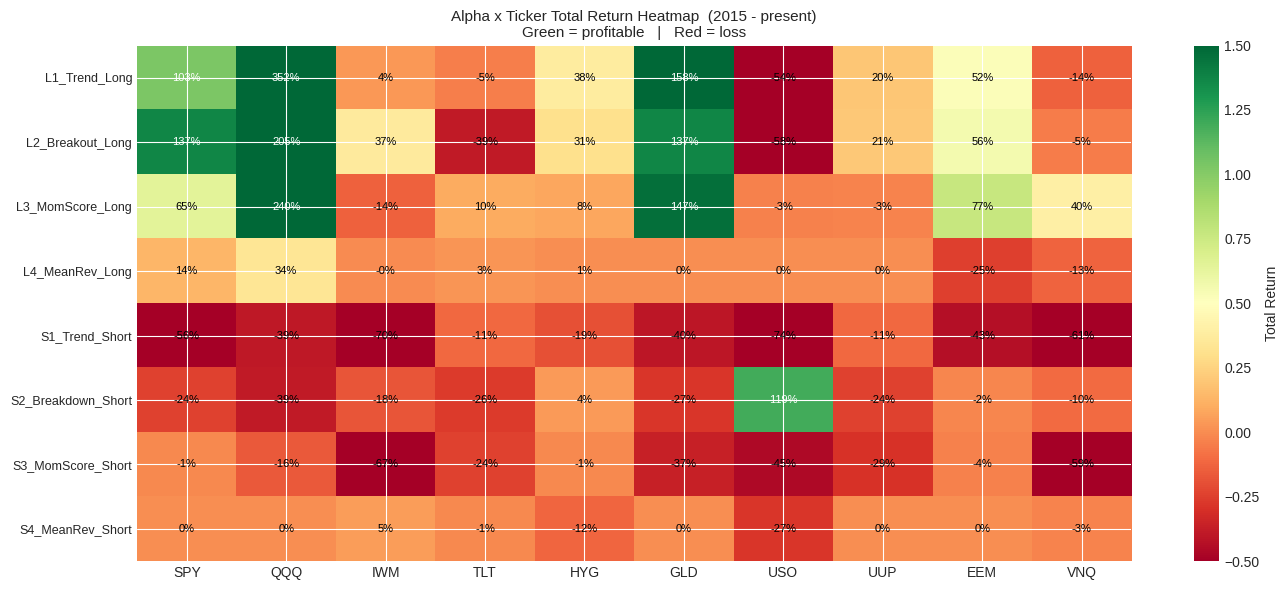


Alpha runner complete


In [15]:
# Cell 6: Alpha Runner — per-ticker breakdown
# ============================================================
# Outputs:
#
#   signal_matrix    : {alpha_name: 0/1 DataFrame (days x tickers)}
#   return_matrix    : {alpha_name: net return DataFrame (days x tickers)}
#   alpha_returns_df : DataFrame of aggregate daily returns per alpha
#                      (equal-weight across active tickers)
#   ticker_returns   : {alpha_name: {ticker: pd.Series}}
#                      individual net return series for every alpha x ticker


# -- 6a. Collect all signals --------------------------------
print("Building signal matrix...")

signal_matrix = {
    'L1_Trend_Long':      sig_L1,
    'L2_Breakout_Long':   sig_L2,
    'L3_MomScore_Long':   sig_L3,
    'L4_MeanRev_Long':    sig_L4,
    'S1_Trend_Short':     sig_S1,
    'S2_Breakdown_Short': sig_S2,
    'S3_MomScore_Short':  sig_S3,
    'S4_MeanRev_Short':   sig_S4,
}

SIDE = {
    'L1_Trend_Long':      +1,
    'L2_Breakout_Long':   +1,
    'L3_MomScore_Long':   +1,
    'L4_MeanRev_Long':    +1,
    'S1_Trend_Short':     -1,
    'S2_Breakdown_Short': -1,
    'S3_MomScore_Short':  -1,
    'S4_MeanRev_Short':   -1,
}

for name, sig in signal_matrix.items():
    print(f"  {name:24s}: shape {sig.shape}  "
          f"mean density {sig.mean().mean():.1%}")


# -- 6b. Per-ticker net returns for each alpha --------------
print("\nComputing per-ticker net returns...")

return_matrix  = {}
ticker_returns = {}

for alpha_name, sig in signal_matrix.items():
    side        = SIDE[alpha_name]
    position    = sig * side
    pos_aligned = position.reindex(returns.index).fillna(0)

    # Net returns after transaction costs
    net = apply_costs(returns, pos_aligned, CONFIG['cost_bps'])
    return_matrix[alpha_name] = net

    # Split into per-ticker Series
    ticker_returns[alpha_name] = {}
    for ticker in TICKERS:
        ticker_returns[alpha_name][ticker] = net[ticker].fillna(0)

print(f"  Done — {len(return_matrix)} alphas x {len(TICKERS)} tickers")


# -- 6c. Aggregate portfolio return per alpha ---------------
print("\nComputing aggregate alpha returns...")

alpha_returns = {}

for alpha_name, net_ret in return_matrix.items():
    sig       = signal_matrix[alpha_name]
    n_active  = sig.sum(axis=1).replace(0, np.nan)
    signed    = sig * SIDE[alpha_name]
    daily_pnl = (net_ret * signed.reindex(net_ret.index).fillna(0)).sum(axis=1)
    port_ret  = (daily_pnl / n_active).fillna(0)
    alpha_returns[alpha_name] = port_ret

alpha_returns_df = pd.DataFrame(alpha_returns).fillna(0)
print(f"  alpha_returns_df shape: {alpha_returns_df.shape}")


# -- 6d. Sanity checks --------------------------------------
print("\nSanity checks:")
nan_count = alpha_returns_df.isna().sum().sum()
print(f"  NaN in alpha_returns_df     : {nan_count}  (expect 0)")
max_daily = alpha_returns_df.abs().max().max()
print(f"  Max absolute daily return   : {max_daily:.4f}  (expect < 0.10)")
corr_L1_S1 = alpha_returns_df['L1_Trend_Long'].corr(
             alpha_returns_df['S1_Trend_Short'])
print(f"  L1 / S1 correlation         : {corr_L1_S1:.3f}  (expect negative)")
corr_L3_S3 = alpha_returns_df['L3_MomScore_Long'].corr(
             alpha_returns_df['S3_MomScore_Short'])
print(f"  L3 / S3 correlation         : {corr_L3_S3:.3f}  (expect negative)")


# -- 6e. Plot helpers ---------------------------------------
def plot_per_ticker(alpha_name, ax):
    """
    One equity curve per ticker for a given alpha,
    plus a bold dashed aggregate line.
    """
    colors = plt.cm.tab10.colors
    for i, ticker in enumerate(TICKERS):
        r   = ticker_returns[alpha_name][ticker]
        cum = (1 + r).cumprod()
        ax.plot(cum.index, cum,
                color=colors[i], linewidth=0.9,
                alpha=0.55, label=ticker)

    # Aggregate equal-weight on top
    agg_cum = (1 + alpha_returns_df[alpha_name]).cumprod()
    ax.plot(agg_cum.index, agg_cum,
            color='black', linewidth=2.2,
            linestyle='--', label='Aggregate')

    ax.axhline(1, color='grey', linewidth=0.7, linestyle=':')
    ax.set_title(alpha_name, fontsize=9, fontweight='bold')
    ax.set_ylabel('Cum. Return', fontsize=8)
    ax.grid(True, alpha=0.25)


# -- 6f. Single figure: 4 rows x 2 cols --------------------
# Left column = long alphas, right column = short alphas
long_alphas  = ['L1_Trend_Long',    'L2_Breakout_Long',
                'L3_MomScore_Long',  'L4_MeanRev_Long']
short_alphas = ['S1_Trend_Short',    'S2_Breakdown_Short',
                'S3_MomScore_Short', 'S4_MeanRev_Short']

fig, axes = plt.subplots(
    nrows=4, ncols=2,
    figsize=(20, 22),
    sharex=True
)

fig.suptitle(
    'Per-Ticker Equity Curves — All 8 Alphas\n'
    'Left = Long Alphas    |    Right = Short Alphas\n'
    'Thin lines = individual tickers   |   '
    'Dashed black = equal-weight aggregate',
    fontsize=12, fontweight='bold', y=1.01
)

for row in range(4):
    plot_per_ticker(long_alphas[row],  axes[row, 0])
    plot_per_ticker(short_alphas[row], axes[row, 1])

# Column headers
axes[0, 0].set_title('LONG ALPHAS\n' + long_alphas[0],
                      fontsize=9, fontweight='bold')
axes[0, 1].set_title('SHORT ALPHAS\n' + short_alphas[0],
                      fontsize=9, fontweight='bold')

# Shared legend below figure
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    ncol=6,
    fontsize=9,
    bbox_to_anchor=(0.5, -0.02),
    frameon=True
)

for col in range(2):
    axes[3, col].set_xlabel('Date', fontsize=9)

plt.tight_layout()
plt.show()


# -- 6g. Alpha x ticker total return heatmap ---------------
print("Plotting alpha x ticker return heatmap...")

heatmap_data = {}
for alpha_name in ALPHA_NAMES:
    row = {}
    for ticker in TICKERS:
        r   = ticker_returns[alpha_name][ticker]
        cum = (1 + r).cumprod()
        row[ticker] = cum.iloc[-1] - 1
    heatmap_data[alpha_name] = row

heatmap_df = pd.DataFrame(heatmap_data).T  # shape: alphas x tickers

fig, ax = plt.subplots(figsize=(14, 6))
im = ax.imshow(
    heatmap_df.values,
    aspect='auto',
    cmap='RdYlGn',
    vmin=-0.5,
    vmax=1.5
)

ax.set_xticks(range(len(TICKERS)))
ax.set_xticklabels(TICKERS, fontsize=10)
ax.set_yticks(range(len(ALPHA_NAMES)))
ax.set_yticklabels(ALPHA_NAMES, fontsize=9)

for i in range(len(ALPHA_NAMES)):
    for j in range(len(TICKERS)):
        val = heatmap_df.iloc[i, j]
        ax.text(j, i, f'{val:.0%}',
                ha='center', va='center',
                fontsize=8,
                color='black' if abs(val) < 0.8 else 'white')

plt.colorbar(im, ax=ax, label='Total Return')
ax.set_title(
    'Alpha x Ticker Total Return Heatmap  (2015 - present)\n'
    'Green = profitable   |   Red = loss',
    fontsize=11
)
plt.tight_layout()
plt.show()

print("\nAlpha runner complete")

#  Cell 7 — Performance Engine.

Computing performance table...

Alpha Performance Summary (aggregate, equal-weight universe):
                    Ann. Return  Ann. Vol  Sharpe  Max Drawdown  Calmar  Hit Rate  Win/Loss Ratio  Avg Hold (days)
L1_Trend_Long            0.0530    0.1110  0.4780       -0.2240  0.2380    0.5510          0.8800        1396.0000
L2_Breakout_Long         0.0470    0.0930  0.5080       -0.2230  0.2120    0.5470          0.8780         554.4000
L3_MomScore_Long         0.1070    0.1290  0.8290       -0.2430  0.4390    0.5150          0.8890        2549.0000
L4_MeanRev_Long          0.0610    0.1490  0.4110       -0.3320  0.1850    0.2640          0.9320          10.5000
S1_Trend_Short           0.0830    0.2010  0.4120       -0.5260  0.1570    0.5120          0.9450         673.0000
S2_Breakdown_Short       0.0290    0.1640  0.1770       -0.5370  0.0540    0.4680          0.9210          78.0000
S3_MomScore_Short        0.0870    0.1590  0.5450       -0.3900  0.2230    0.4890          0.9570    

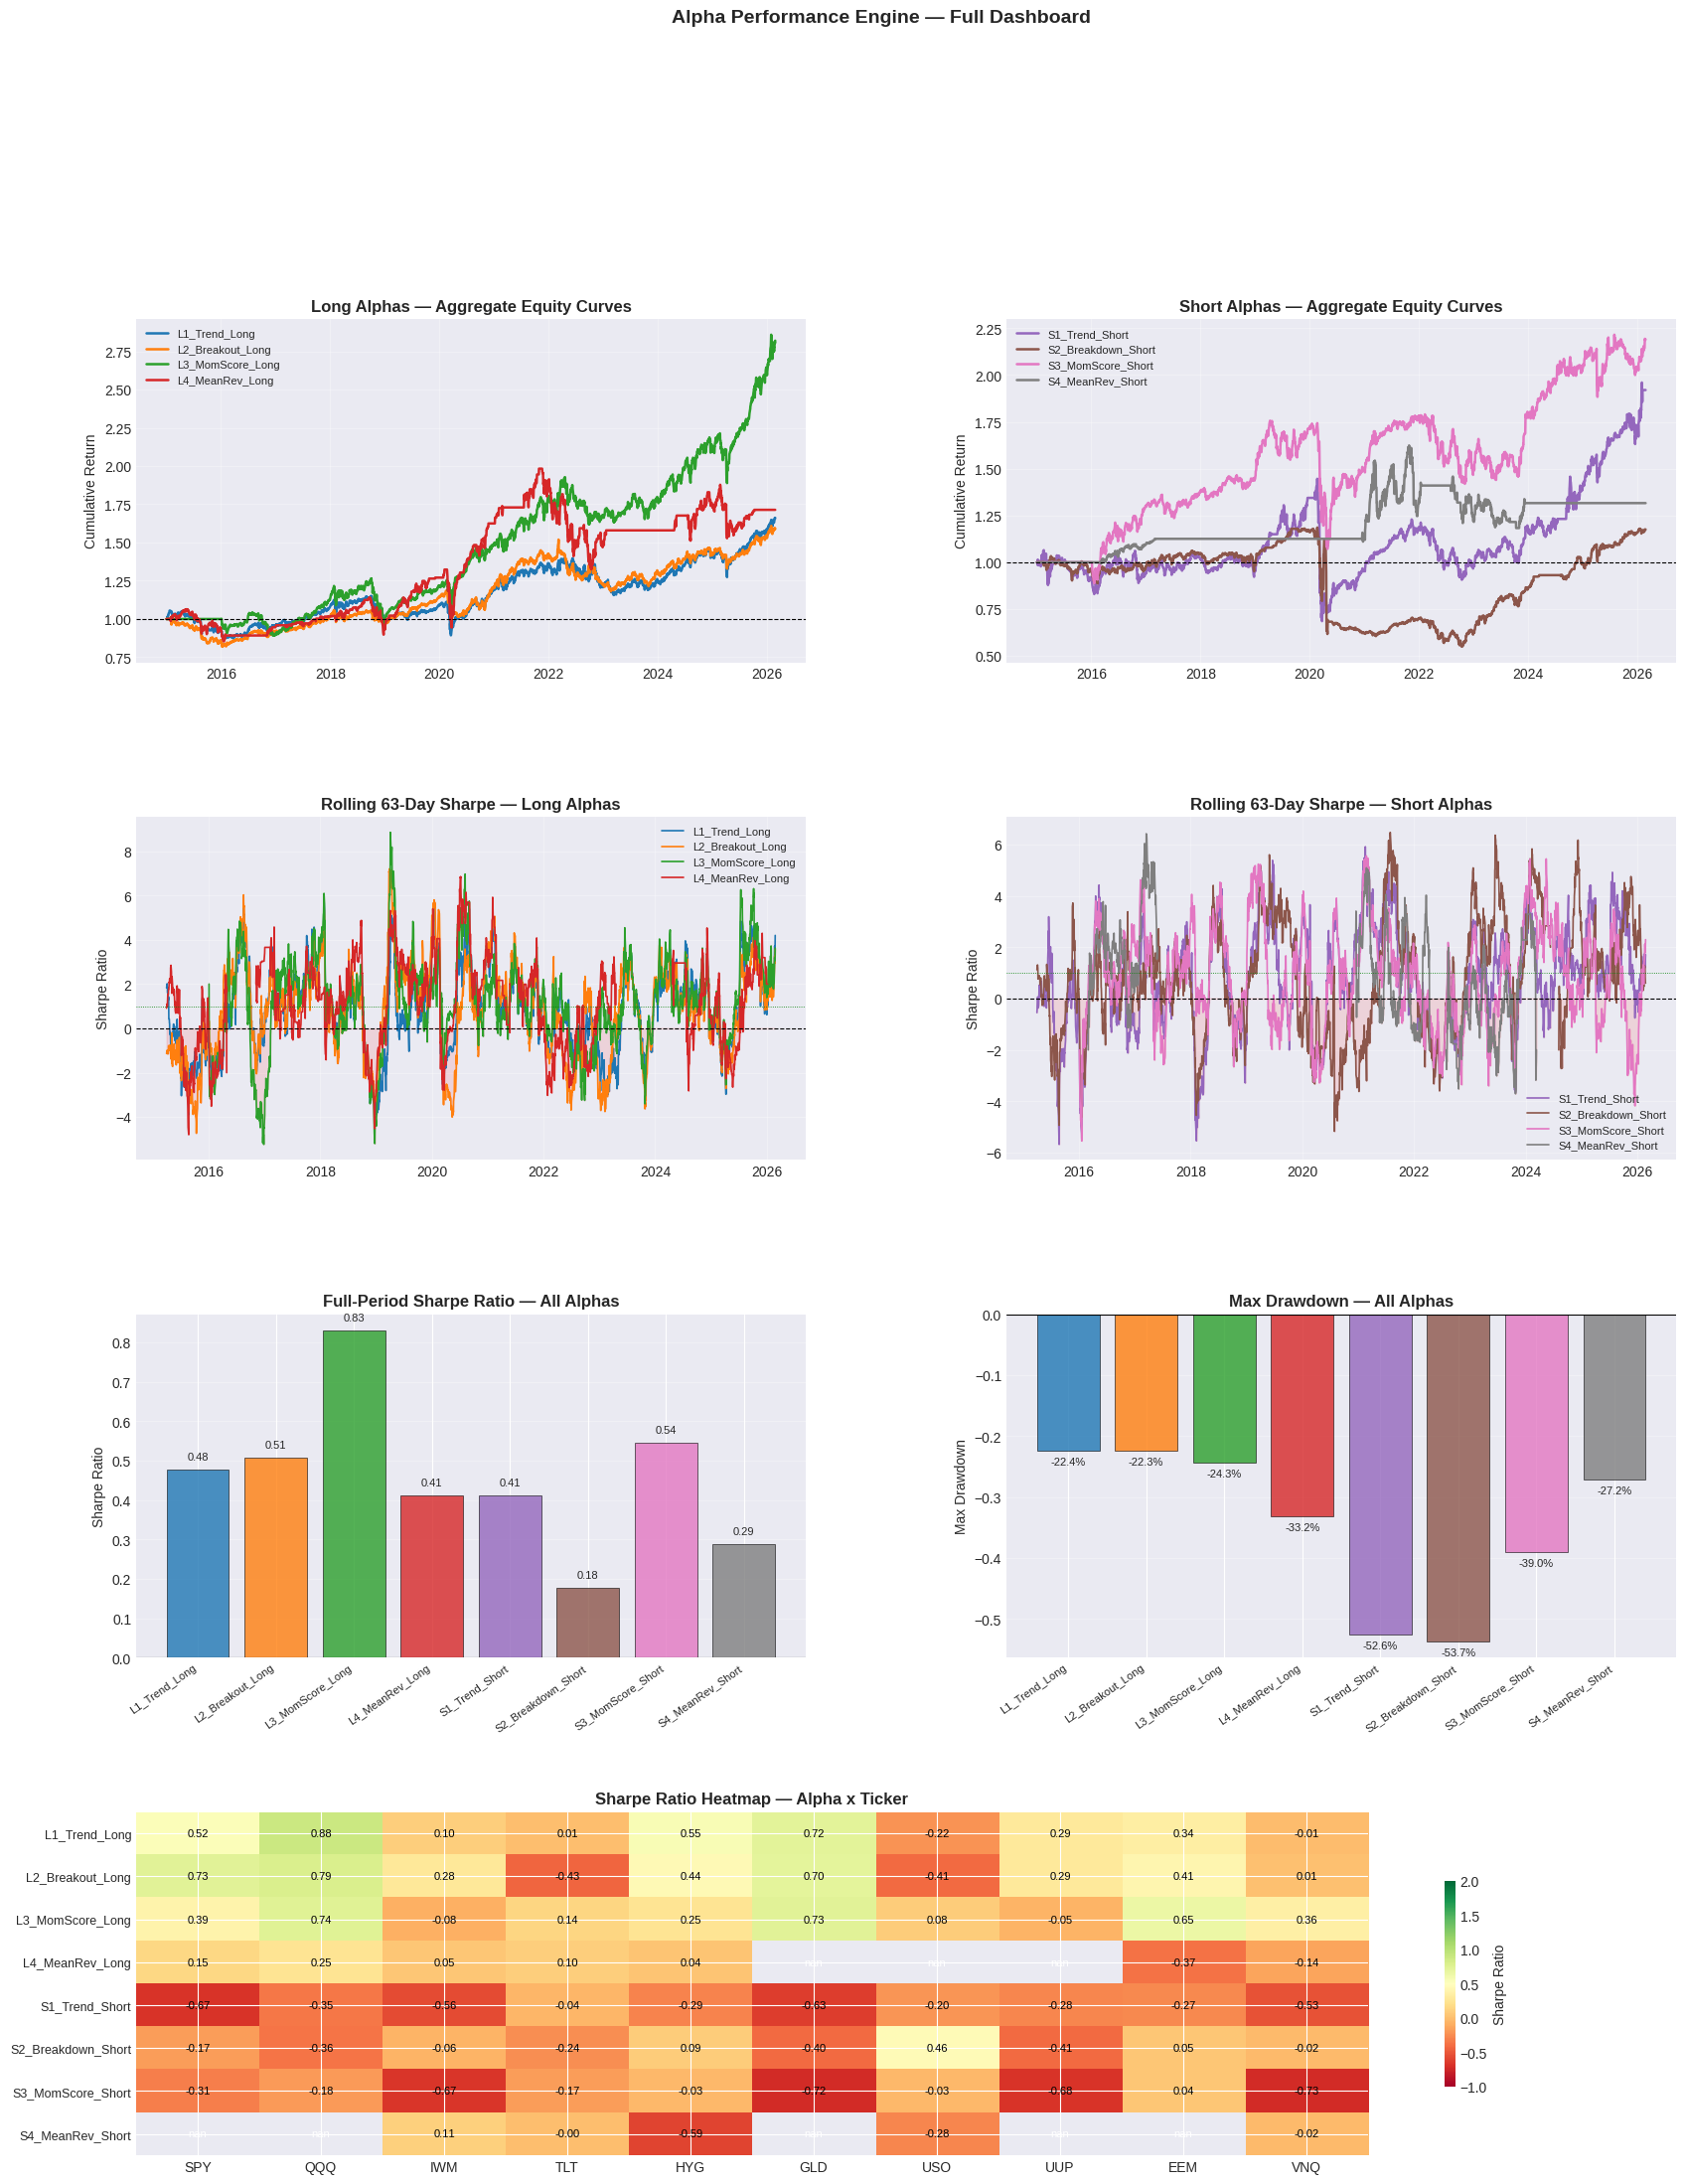


Performance engine complete
Dashboard saved to alpha_performance_dashboard.png


In [16]:
# Cell 7: Performance Engine
# ============================================================
# Produces three outputs:
#
#   perf_table      : DataFrame — one row per alpha, all key stats
#   rolling_sharpe  : DataFrame — rolling 63-day Sharpe per alpha
#   perf_fig        : summary dashboard figure
#
# Stats computed:
#   Ann. Return, Ann. Vol, Sharpe, Max Drawdown,
#   Calmar, Hit Rate, Avg Win, Avg Loss, Win/Loss Ratio,
#   Best Day, Worst Day, Avg Days in Position


# -- 7a. Full performance table ----------------------------
print("Computing performance table...")

def full_performance(returns_series: pd.Series,
                     signal_series: pd.Series = None,
                     name: str = '') -> pd.Series:
    """
    Extended performance stats for one return stream.

    Args:
        returns_series : daily net returns (pd.Series)
        signal_series  : optional 0/1 position series for
                         avg hold duration calculation
        name           : label for the output Series
    """
    ann  = 252
    r    = returns_series.dropna()
    cum  = (1 + r).cumprod()

    # Core stats
    ann_ret  = (1 + r.mean()) ** ann - 1
    ann_vol  = r.std() * np.sqrt(ann)
    sharpe   = ann_ret / ann_vol if ann_vol > 0 else np.nan
    mdd      = compute_max_drawdown(cum)
    calmar   = ann_ret / abs(mdd) if mdd != 0 else np.nan

    # Win/loss breakdown
    wins     = r[r > 0]
    losses   = r[r < 0]
    hit_rate = len(wins) / len(r) if len(r) > 0 else np.nan
    avg_win  = wins.mean()  if len(wins)   > 0 else np.nan
    avg_loss = losses.mean() if len(losses) > 0 else np.nan
    wl_ratio = abs(avg_win / avg_loss) if avg_loss != 0 else np.nan

    # Expected value per trade
    ev = hit_rate * avg_win + (1 - hit_rate) * avg_loss

    # Average hold duration (days in position per trade)
    avg_hold = np.nan
    if signal_series is not None:
        sig = signal_series.reindex(r.index).fillna(0)
        # Count consecutive runs of 1s
        in_pos    = (sig > 0).astype(int)
        trade_id  = (in_pos.diff() == 1).cumsum()
        trade_id  = trade_id[in_pos == 1]
        if len(trade_id) > 0:
            avg_hold = trade_id.groupby(trade_id).size().mean()

    stats = pd.Series({
        'Ann. Return':     ann_ret,
        'Ann. Vol':        ann_vol,
        'Sharpe':          sharpe,
        'Max Drawdown':    mdd,
        'Calmar':          calmar,
        'Hit Rate':        hit_rate,
        'Avg Win':         avg_win,
        'Avg Loss':        avg_loss,
        'Win/Loss Ratio':  wl_ratio,
        'Exp. Value/Day':  ev,
        'Best Day':        r.max(),
        'Worst Day':       r.min(),
        'Avg Hold (days)': avg_hold,
        'Total Days':      len(r),
    }, name=name)

    return stats


# Build table: one row per alpha (aggregate returns)
perf_rows = []
for alpha_name in ALPHA_NAMES:
    # Use aggregate alpha return stream
    r   = alpha_returns_df[alpha_name]
    # Use mean signal across tickers as proxy for position series
    sig = signal_matrix[alpha_name].mean(axis=1)
    perf_rows.append(full_performance(r, sig, name=alpha_name))

perf_table = pd.DataFrame(perf_rows)

# Format for display
display_cols = ['Ann. Return', 'Ann. Vol', 'Sharpe', 'Max Drawdown',
                'Calmar', 'Hit Rate', 'Win/Loss Ratio',
                'Avg Hold (days)']

print("\nAlpha Performance Summary (aggregate, equal-weight universe):")
print("=" * 75)
print(perf_table[display_cols].round(3).to_string())


# -- 7b. Per-ticker performance breakdown ------------------
print("\n\nPer-ticker performance breakdown...")

ticker_perf = {}
for alpha_name in ALPHA_NAMES:
    rows = []
    for ticker in TICKERS:
        r   = ticker_returns[alpha_name][ticker]
        sig = signal_matrix[alpha_name][ticker]
        rows.append(full_performance(r, sig, name=ticker))
    ticker_perf[alpha_name] = pd.DataFrame(rows)['Sharpe']

# Sharpe ratio table: alphas x tickers
sharpe_table = pd.DataFrame(ticker_perf).T
sharpe_table.columns = TICKERS
sharpe_table.index   = ALPHA_NAMES

print("\nSharpe Ratio — per alpha x ticker:")
print(sharpe_table.round(2).to_string())


# -- 7c. Rolling Sharpe ------------------------------------
print("\nComputing rolling Sharpe ratios...")

window = CONFIG['swarm']['lookback_days']  # 63 days
rolling_sharpe = compute_rolling_sharpe(alpha_returns_df, window=window)


# -- 7d. Performance dashboard -----------------------------
print("Building performance dashboard...")

fig = plt.figure(figsize=(20, 24))
gs  = gridspec.GridSpec(4, 2, figure=fig, hspace=0.45, wspace=0.3)

colors_long  = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
colors_short = ['#9467bd', '#8c564b', '#e377c2', '#7f7f7f']


# ── Panel 1: Equity curves — long alphas ------------------
ax1 = fig.add_subplot(gs[0, 0])
for i, name in enumerate(long_alphas):
    cum = (1 + alpha_returns_df[name]).cumprod()
    ax1.plot(cum.index, cum, label=name,
             color=colors_long[i], linewidth=1.8)
ax1.axhline(1, color='black', linewidth=0.8, linestyle='--')
ax1.set_title('Long Alphas — Aggregate Equity Curves', fontweight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)


# ── Panel 2: Equity curves — short alphas -----------------
ax2 = fig.add_subplot(gs[0, 1])
for i, name in enumerate(short_alphas):
    cum = (1 + alpha_returns_df[name]).cumprod()
    ax2.plot(cum.index, cum, label=name,
             color=colors_short[i], linewidth=1.8)
ax2.axhline(1, color='black', linewidth=0.8, linestyle='--')
ax2.set_title('Short Alphas — Aggregate Equity Curves', fontweight='bold')
ax2.set_ylabel('Cumulative Return')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)


# ── Panel 3: Rolling Sharpe — long alphas -----------------
ax3 = fig.add_subplot(gs[1, 0])
for i, name in enumerate(long_alphas):
    ax3.plot(rolling_sharpe.index, rolling_sharpe[name],
             label=name, color=colors_long[i], linewidth=1.2)
ax3.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax3.axhline(1, color='green', linewidth=0.6, linestyle=':')
ax3.fill_between(rolling_sharpe.index, 0,
                 rolling_sharpe[long_alphas].min(axis=1).clip(upper=0),
                 alpha=0.1, color='red')
ax3.set_title(f'Rolling {window}-Day Sharpe — Long Alphas', fontweight='bold')
ax3.set_ylabel('Sharpe Ratio')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)


# ── Panel 4: Rolling Sharpe — short alphas ----------------
ax4 = fig.add_subplot(gs[1, 1])
for i, name in enumerate(short_alphas):
    ax4.plot(rolling_sharpe.index, rolling_sharpe[name],
             label=name, color=colors_short[i], linewidth=1.2)
ax4.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax4.axhline(1, color='green', linewidth=0.6, linestyle=':')
ax4.fill_between(rolling_sharpe.index, 0,
                 rolling_sharpe[short_alphas].min(axis=1).clip(upper=0),
                 alpha=0.1, color='red')
ax4.set_title(f'Rolling {window}-Day Sharpe — Short Alphas', fontweight='bold')
ax4.set_ylabel('Sharpe Ratio')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)


# ── Panel 5: Sharpe bar chart — all alphas ----------------
ax5 = fig.add_subplot(gs[2, 0])
sharpes = perf_table['Sharpe']
bar_colors = (colors_long + colors_short)
bars = ax5.bar(range(len(ALPHA_NAMES)), sharpes.values,
               color=bar_colors, alpha=0.8, edgecolor='black', linewidth=0.5)
ax5.axhline(0, color='black', linewidth=0.8)
ax5.set_xticks(range(len(ALPHA_NAMES)))
ax5.set_xticklabels(ALPHA_NAMES, rotation=35, ha='right', fontsize=8)
ax5.set_title('Full-Period Sharpe Ratio — All Alphas', fontweight='bold')
ax5.set_ylabel('Sharpe Ratio')
# Annotate bars
for bar, val in zip(bars, sharpes.values):
    ax5.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.02,
             f'{val:.2f}', ha='center', va='bottom', fontsize=8)
ax5.grid(True, alpha=0.3, axis='y')


# ── Panel 6: Max drawdown bar chart -----------------------
ax6 = fig.add_subplot(gs[2, 1])
mdds = perf_table['Max Drawdown']
bars2 = ax6.bar(range(len(ALPHA_NAMES)), mdds.values,
                color=bar_colors, alpha=0.8, edgecolor='black', linewidth=0.5)
ax6.axhline(0, color='black', linewidth=0.8)
ax6.set_xticks(range(len(ALPHA_NAMES)))
ax6.set_xticklabels(ALPHA_NAMES, rotation=35, ha='right', fontsize=8)
ax6.set_title('Max Drawdown — All Alphas', fontweight='bold')
ax6.set_ylabel('Max Drawdown')
for bar, val in zip(bars2, mdds.values):
    ax6.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() - 0.01,
             f'{val:.1%}', ha='center', va='top', fontsize=8)
ax6.grid(True, alpha=0.3, axis='y')


# ── Panel 7: Sharpe heatmap — alpha x ticker --------------
ax7 = fig.add_subplot(gs[3, :])
im = ax7.imshow(
    sharpe_table.values,
    aspect='auto',
    cmap='RdYlGn',
    vmin=-1, vmax=2
)
ax7.set_xticks(range(len(TICKERS)))
ax7.set_xticklabels(TICKERS, fontsize=10)
ax7.set_yticks(range(len(ALPHA_NAMES)))
ax7.set_yticklabels(ALPHA_NAMES, fontsize=9)
for i in range(len(ALPHA_NAMES)):
    for j in range(len(TICKERS)):
        val = sharpe_table.iloc[i, j]
        ax7.text(j, i, f'{val:.2f}',
                 ha='center', va='center', fontsize=8,
                 color='black' if abs(val) < 1.2 else 'white')
plt.colorbar(im, ax=ax7, label='Sharpe Ratio', shrink=0.6)
ax7.set_title('Sharpe Ratio Heatmap — Alpha x Ticker', fontweight='bold')

fig.suptitle('Alpha Performance Engine — Full Dashboard',
             fontsize=14, fontweight='bold', y=1.01)

plt.savefig('alpha_performance_dashboard.png',
            dpi=150, bbox_inches='tight')
plt.show()

print("\nPerformance engine complete")
print("Dashboard saved to alpha_performance_dashboard.png")

# Cell 8 — Benchmark Loader

Computing benchmark returns...
  Full universe start  : 2015-01-02
  Overlap period start : 2019-05-08  (limited by DBMF)
  Overlap period end   : 2026-02-24
  Overlap length       : 1709 days

Computing full-history performance per benchmark...

Benchmark Performance (full history):
      Ann. Return  Ann. Vol  Sharpe  Max Drawdown  Calmar  Hit Rate  Win/Loss Ratio
SPY        0.1520    0.1770  0.8550       -0.3370  0.4500    0.5480          0.9570
TLT        0.0070    0.1500  0.0460       -0.4840  0.0140    0.5130          0.9470
DBMF       0.1060    0.1240  0.8570       -0.2040  0.5220    0.5470          0.9160
MNA        0.0300    0.0640  0.4730       -0.1670  0.1820    0.4950          1.0090
QAI        0.0320    0.0600  0.5420       -0.1490  0.2170    0.5150          0.9300

Computing overlap-period performance (all benchmarks)...

Benchmark Performance (overlap period — apples to apples):
      Ann. Return  Ann. Vol  Sharpe  Max Drawdown  Calmar  Hit Rate  Win/Loss Ratio
SPY      

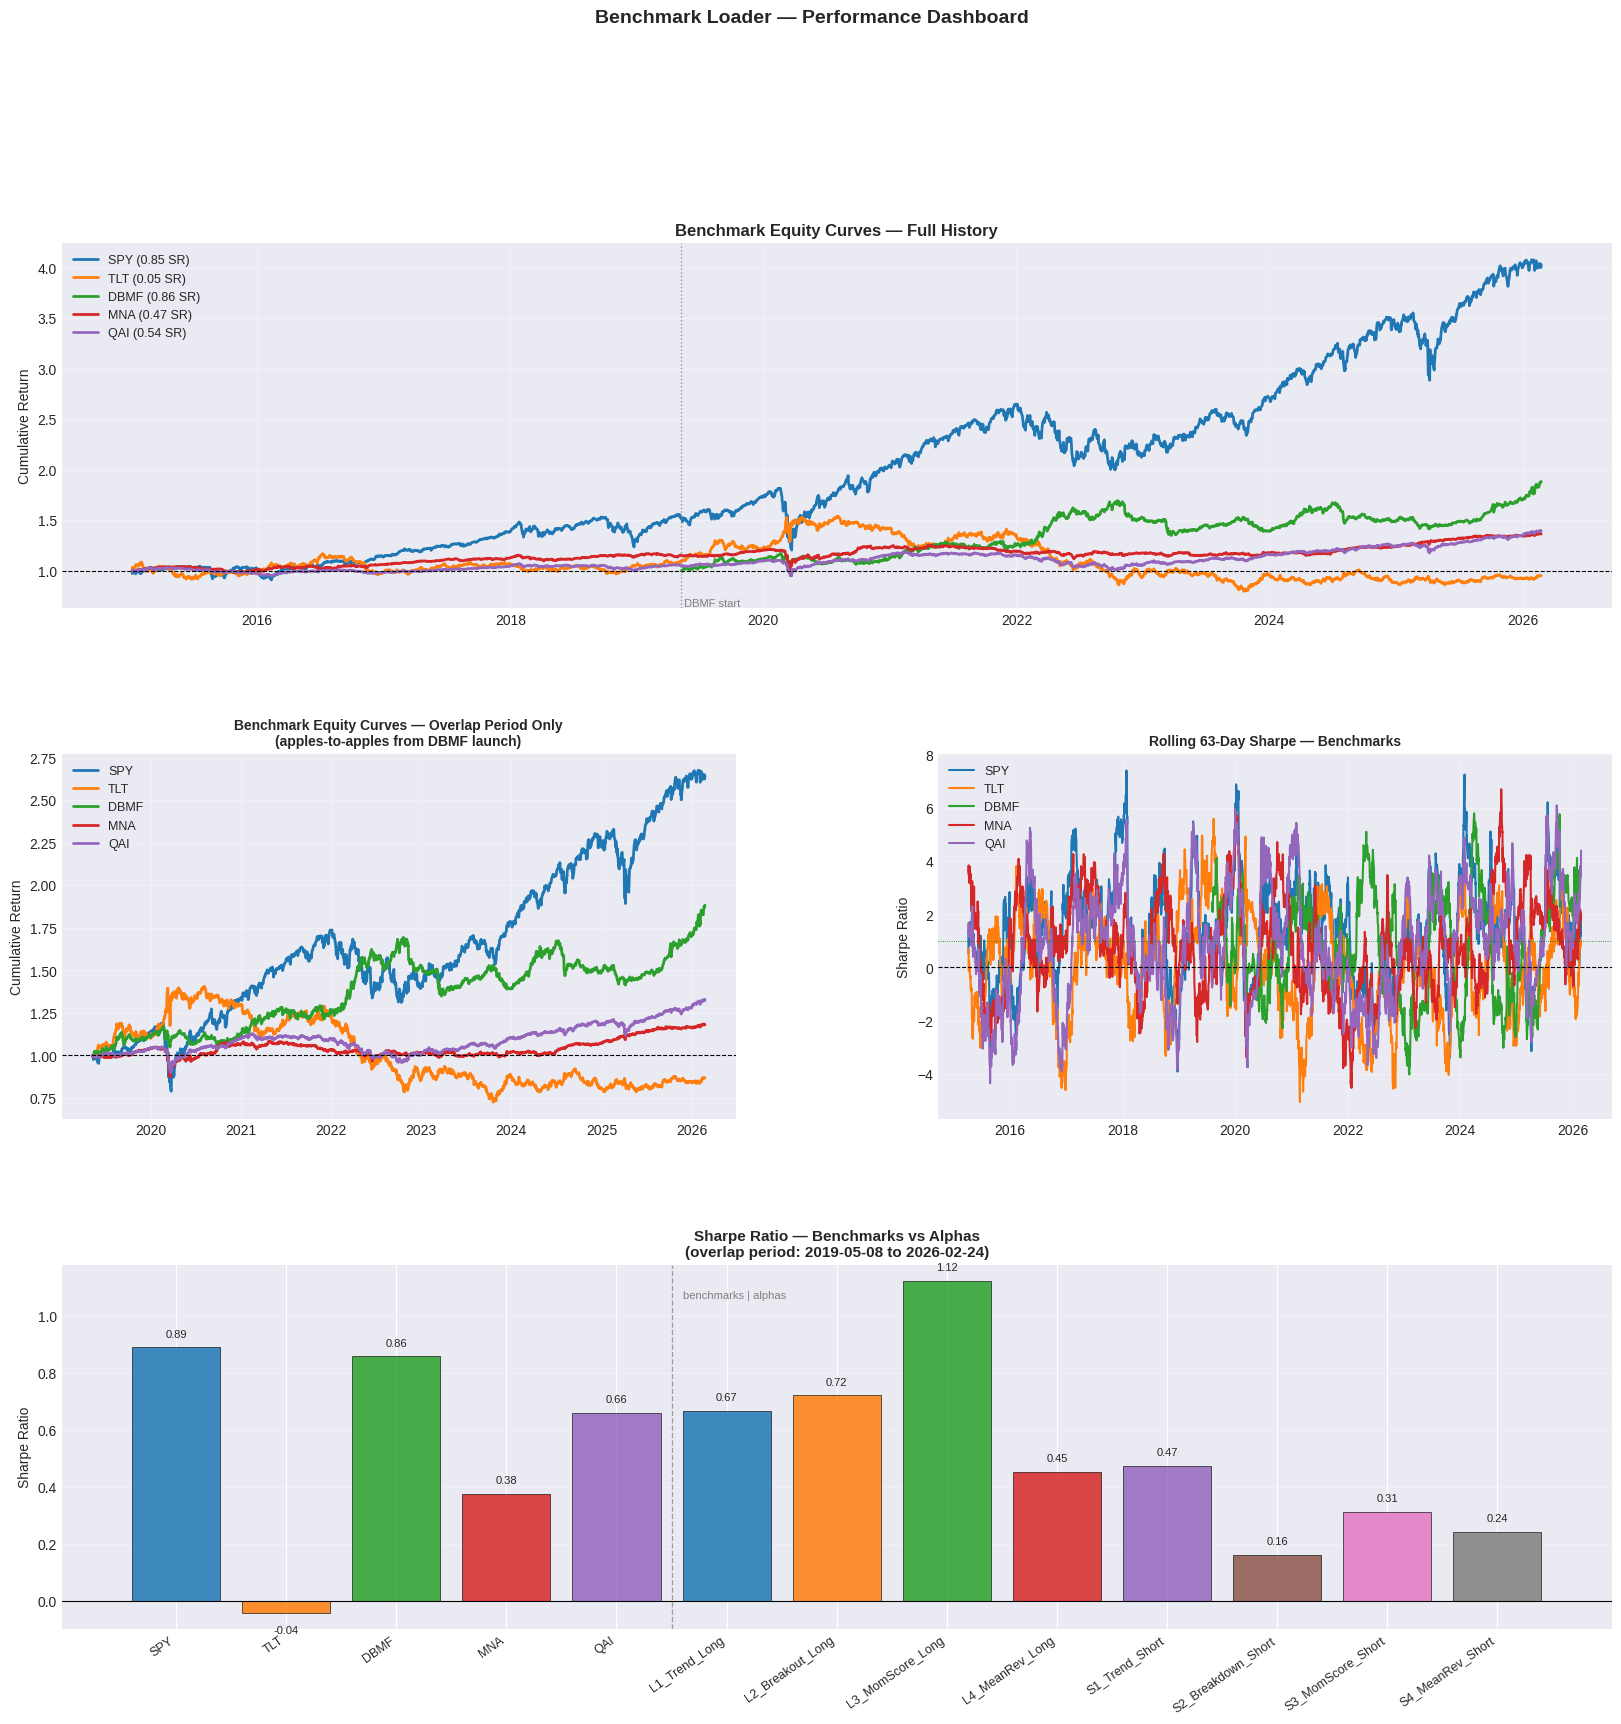


Benchmark loader complete
Dashboard saved to benchmark_dashboard.png


In [17]:
# Cell 8: Benchmark Loader
# ============================================================
# Computes returns and performance stats for all benchmarks:
#   SPY  — passive US equity
#   TLT  — passive long bonds
#   DBMF — managed futures replication (live from 2019-05-xx)
#   MNA  — merger arbitrage
#   QAI  — multi-strategy hedge fund replication
#
# Handles unequal start dates cleanly — each benchmark is
# evaluated over its own full history AND over the common
# overlap period shared with DBMF (shortest series).
#
# Outputs:
#   bench_returns     : DataFrame of daily returns per benchmark
#   bench_perf        : DataFrame of performance stats per benchmark
#   overlap_start     : first date where ALL benchmarks have data
#   bench_perf_overlap: performance stats over common period only


# -- 8a. Benchmark daily returns ---------------------------
print("Computing benchmark returns...")

bench_returns = bench_close.pct_change()

# Identify the common overlap period (all benchmarks present)
overlap_start = bench_close.dropna(how='any').index[0]
overlap_end   = bench_close.dropna(how='any').index[-1]

print(f"  Full universe start  : {bench_close.index[0].date()}")
print(f"  Overlap period start : {overlap_start.date()}  "
      f"(limited by DBMF)")
print(f"  Overlap period end   : {overlap_end.date()}")
print(f"  Overlap length       : "
      f"{len(bench_close.loc[overlap_start:overlap_end])} days")


# -- 8b. Performance over full history per benchmark -------
print("\nComputing full-history performance per benchmark...")

bench_perf_rows = []
for bm in bench_close.columns:
    r   = bench_returns[bm].dropna()
    cum = (1 + r).cumprod()
    bench_perf_rows.append(
        full_performance(r, name=bm)
    )

bench_perf = pd.DataFrame(bench_perf_rows)

display_cols = ['Ann. Return', 'Ann. Vol', 'Sharpe',
                'Max Drawdown', 'Calmar', 'Hit Rate',
                'Win/Loss Ratio']

print("\nBenchmark Performance (full history):")
print("=" * 65)
print(bench_perf[display_cols].round(3).to_string())


# -- 8c. Performance over OVERLAP period only --------------
# Fair apples-to-apples comparison including DBMF
print("\nComputing overlap-period performance (all benchmarks)...")

bench_perf_overlap_rows = []
for bm in bench_close.columns:
    r   = bench_returns[bm].loc[overlap_start:overlap_end].dropna()
    cum = (1 + r).cumprod()
    bench_perf_overlap_rows.append(
        full_performance(r, name=bm)
    )

bench_perf_overlap = pd.DataFrame(bench_perf_overlap_rows)

print("\nBenchmark Performance (overlap period — apples to apples):")
print("=" * 65)
print(bench_perf_overlap[display_cols].round(3).to_string())


# -- 8d. Alpha performance over overlap period -------------
# So we can compare alphas vs benchmarks on the same window
print("\nComputing alpha performance over overlap period...")

alpha_perf_overlap_rows = []
for alpha_name in ALPHA_NAMES:
    r = alpha_returns_df[alpha_name].loc[overlap_start:overlap_end]
    alpha_perf_overlap_rows.append(
        full_performance(r, name=alpha_name)
    )

alpha_perf_overlap = pd.DataFrame(alpha_perf_overlap_rows)

print("\nAlpha Performance (overlap period):")
print("=" * 65)
print(alpha_perf_overlap[display_cols].round(3).to_string())


# -- 8e. Benchmark dashboard -------------------------------
print("\nBuilding benchmark dashboard...")

fig = plt.figure(figsize=(20, 18))
gs  = gridspec.GridSpec(3, 2, figure=fig, hspace=0.4, wspace=0.3)

bm_colors = {
    'SPY':  '#1f77b4',
    'TLT':  '#ff7f0e',
    'DBMF': '#2ca02c',
    'MNA':  '#d62728',
    'QAI':  '#9467bd',
}


# ── Panel 1: Full-history equity curves -------------------
ax1 = fig.add_subplot(gs[0, :])
for bm in bench_close.columns:
    r   = bench_returns[bm].dropna()
    cum = (1 + r).cumprod()
    ax1.plot(cum.index, cum,
             label=f"{bm} ({bench_perf.loc[bench_perf.index == bm, 'Sharpe'].values[0]:.2f} SR)",
             color=bm_colors.get(bm, 'grey'),
             linewidth=2)
ax1.axhline(1, color='black', linewidth=0.8, linestyle='--')
ax1.axvline(pd.Timestamp(overlap_start), color='grey',
            linewidth=1, linestyle=':', alpha=0.8)
ax1.text(pd.Timestamp(overlap_start), ax1.get_ylim()[0],
         ' DBMF start', fontsize=8, color='grey', va='bottom')
ax1.set_title('Benchmark Equity Curves — Full History',
              fontweight='bold', fontsize=12)
ax1.set_ylabel('Cumulative Return')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)


# ── Panel 2: Overlap period equity curves -----------------
ax2 = fig.add_subplot(gs[1, 0])
for bm in bench_close.columns:
    r   = bench_returns[bm].loc[overlap_start:].dropna()
    cum = (1 + r).cumprod()
    ax2.plot(cum.index, cum,
             label=bm,
             color=bm_colors.get(bm, 'grey'),
             linewidth=2)
ax2.axhline(1, color='black', linewidth=0.8, linestyle='--')
ax2.set_title('Benchmark Equity Curves — Overlap Period Only\n'
              '(apples-to-apples from DBMF launch)',
              fontweight='bold', fontsize=10)
ax2.set_ylabel('Cumulative Return')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)


# ── Panel 3: Rolling Sharpe — benchmarks ------------------
ax3 = fig.add_subplot(gs[1, 1])
window = CONFIG['swarm']['lookback_days']
for bm in bench_close.columns:
    r      = bench_returns[bm].dropna()
    roll_s = compute_rolling_sharpe(r.to_frame(), window=window)
    ax3.plot(roll_s.index, roll_s.iloc[:, 0],
             label=bm,
             color=bm_colors.get(bm, 'grey'),
             linewidth=1.5)
ax3.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax3.axhline(1, color='green', linewidth=0.6, linestyle=':')
ax3.set_title(f'Rolling {window}-Day Sharpe — Benchmarks',
              fontweight='bold', fontsize=10)
ax3.set_ylabel('Sharpe Ratio')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)


# ── Panel 4: Sharpe comparison bar chart ------------------
# Benchmarks vs alphas over the overlap period
ax4 = fig.add_subplot(gs[2, :])

all_names  = list(bench_perf_overlap.index) + list(alpha_perf_overlap.index)

# Rebuild index-aligned Series
bm_sharpes    = bench_perf_overlap.set_index(
    bench_perf_overlap.index)['Sharpe']
alpha_sharpes = alpha_perf_overlap.set_index(
    alpha_perf_overlap.index)['Sharpe']

all_sharpes = pd.concat([bm_sharpes, alpha_sharpes])

bar_colors_all = (
    [bm_colors.get(b, 'grey') for b in bench_close.columns] +
    colors_long + colors_short
)

bars = ax4.bar(range(len(all_sharpes)),
               all_sharpes.values,
               color=bar_colors_all,
               alpha=0.85,
               edgecolor='black',
               linewidth=0.5)

ax4.axhline(0, color='black', linewidth=0.8)
ax4.axvline(len(bench_close.columns) - 0.5,
            color='grey', linewidth=1,
            linestyle='--', alpha=0.7)
ax4.text(len(bench_close.columns) - 0.4,
         ax4.get_ylim()[1] * 0.9,
         'benchmarks | alphas',
         fontsize=8, color='grey')

ax4.set_xticks(range(len(all_sharpes)))
ax4.set_xticklabels(all_sharpes.index,
                    rotation=35, ha='right', fontsize=9)
ax4.set_title(
    f'Sharpe Ratio — Benchmarks vs Alphas\n'
    f'(overlap period: {overlap_start.date()} to {overlap_end.date()})',
    fontweight='bold', fontsize=11
)
ax4.set_ylabel('Sharpe Ratio')

for bar, val in zip(bars, all_sharpes.values):
    ypos = bar.get_height() + 0.03 if val >= 0 else bar.get_height() - 0.08
    ax4.text(bar.get_x() + bar.get_width() / 2,
             ypos, f'{val:.2f}',
             ha='center', va='bottom', fontsize=8)

ax4.grid(True, alpha=0.3, axis='y')

fig.suptitle('Benchmark Loader — Performance Dashboard',
             fontsize=14, fontweight='bold', y=1.01)

plt.savefig('benchmark_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nBenchmark loader complete")
print("Dashboard saved to benchmark_dashboard.png")

# Regime Detector

Computing volatility regime...
  VIX LOW  (<15)  : 1039 days  (37.1%)
  VIX MID  (15-25) : 1388 days  (49.5%)
  VIX HIGH (>25) : 375 days  (13.4%)

Computing trend regime...
  BULL (SPY > SMA200) : 2152 days  (76.8%)
  BEAR (SPY < SMA200) : 650 days  (23.2%)

Combined regime distribution:
  BULL_MID    :  1079 days  38.5%  ###############
  BULL_LOW    :   939 days  33.5%  #############
  BEAR_MID    :   309 days  11.0%  ####
  BEAR_HIGH   :   241 days  8.6%  ###
  BULL_HIGH   :   134 days  4.8%  #
  BEAR_LOW    :   100 days  3.6%  #

Building alpha eligibility matrix...
  Eligibility rates per alpha (fraction of days eligible):
    L1_Trend_Long           : 100.0%
    L2_Breakout_Long        : 100.0%
    L3_MomScore_Long        : 86.6%
    L4_MeanRev_Long         : 86.6%
    S1_Trend_Short          : 100.0%
    S2_Breakdown_Short      : 100.0%
    S3_MomScore_Short       : 100.0%
    S4_MeanRev_Short        : 50.5%

Building regime weight multipliers...
  Mean regime weight per alpha:

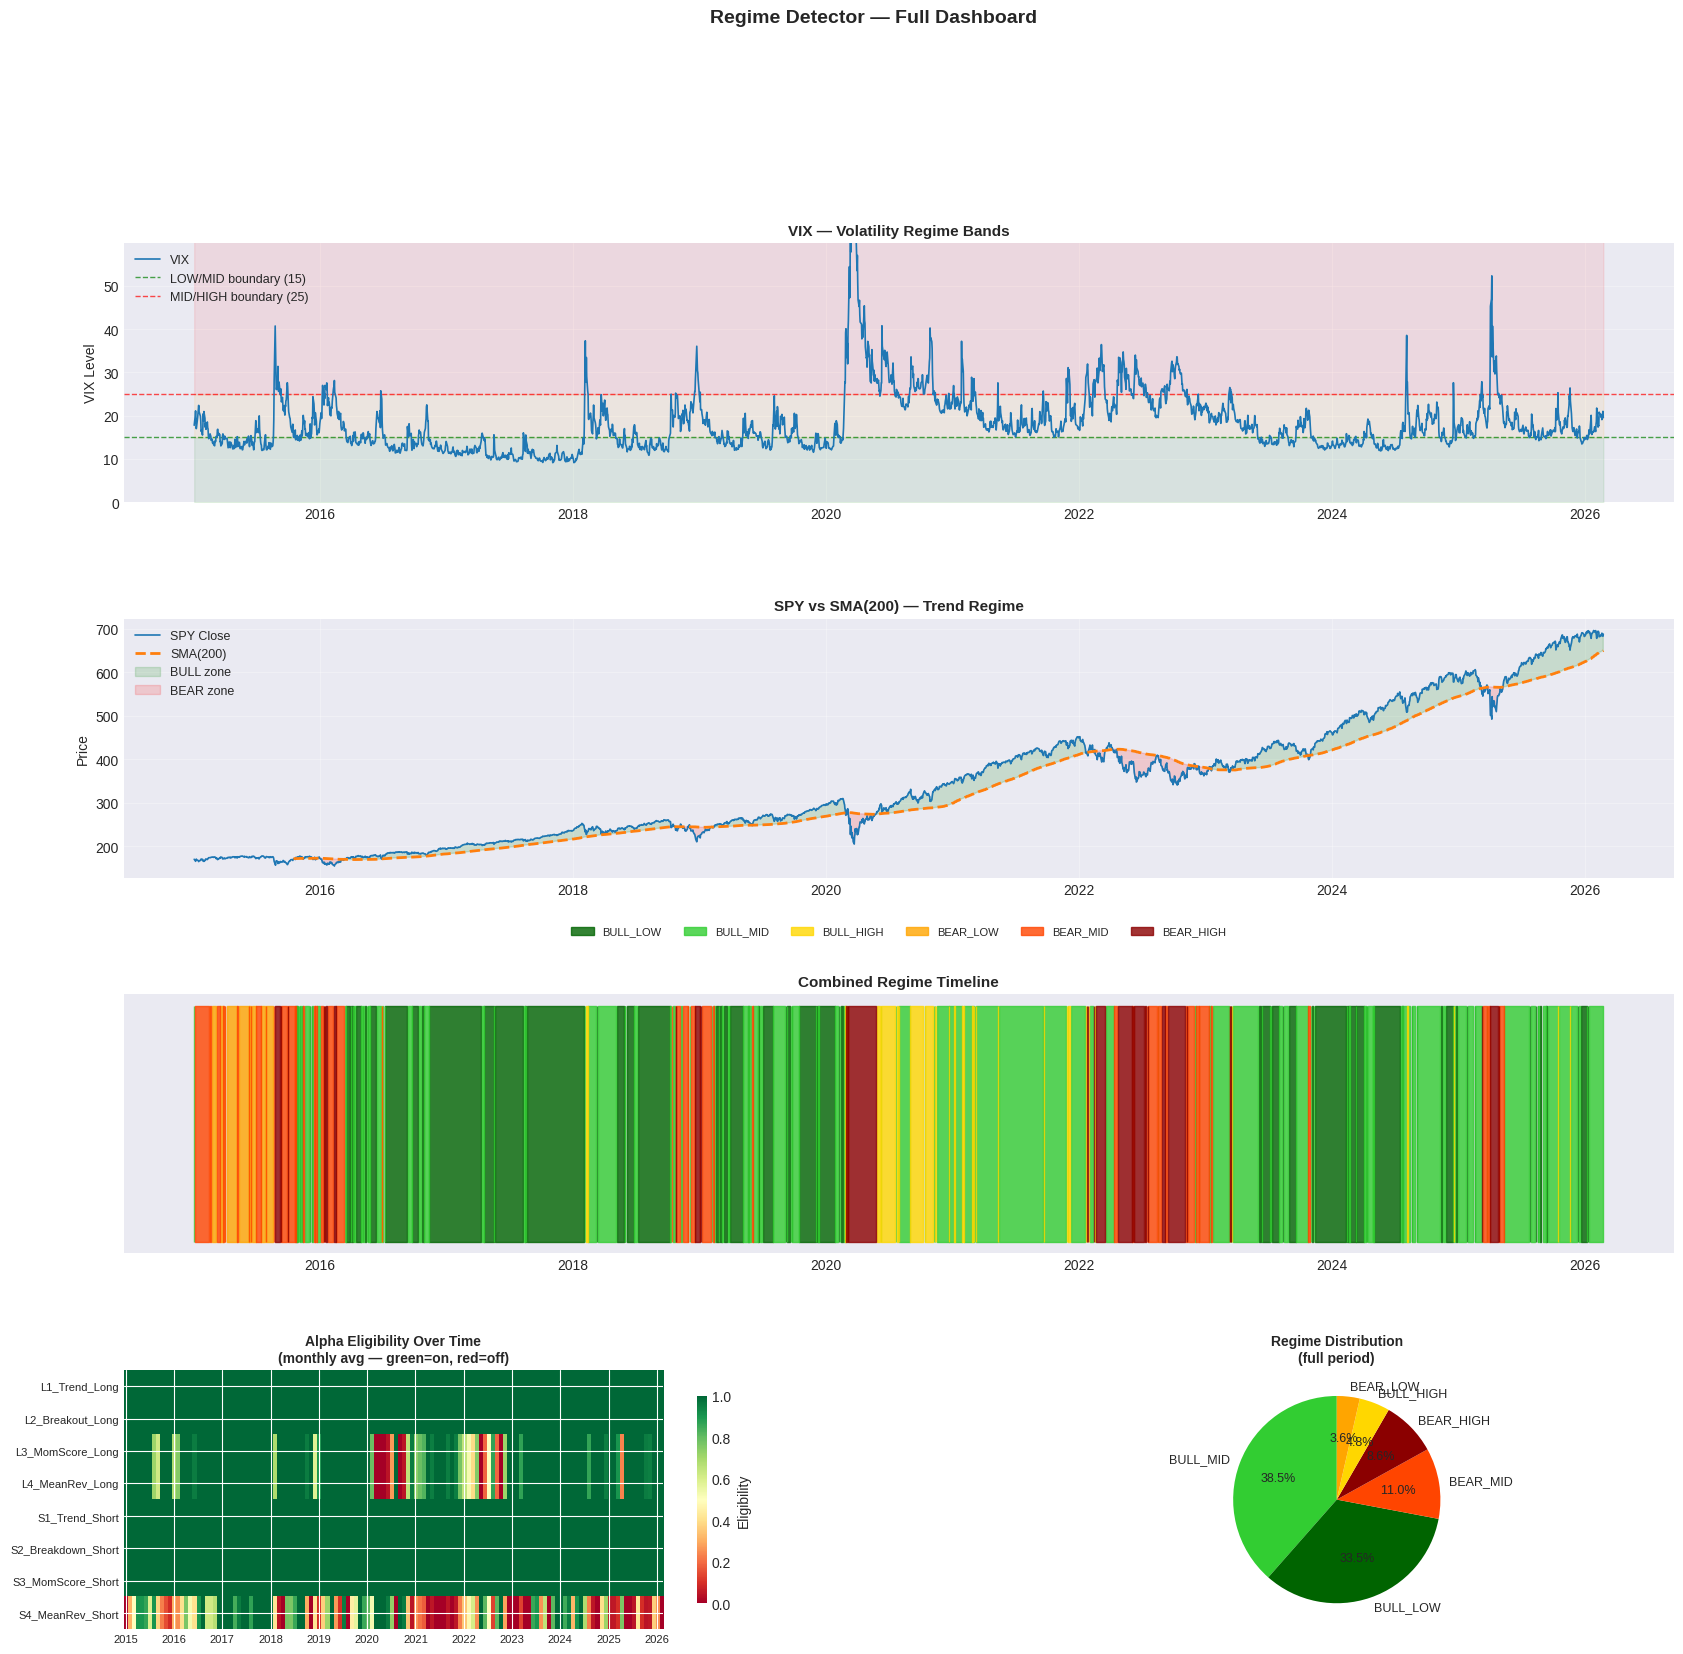


Regime detector complete
Outputs ready: vol_regime, trend_regime, regime,
               regime_df, eligibility, regime_weights
Dashboard saved to regime_dashboard.png


In [18]:
# Cell 9: Regime Detector
# ============================================================
# Classifies every trading day into regimes along two axes:
#
#   VOLATILITY REGIME (VIX-based):
#     LOW   — VIX < 15   : calm, risk-on
#     MID   — VIX 15-25  : normal, mixed signals
#     HIGH  — VIX > 25   : stressed, risk-off
#
#   TREND REGIME (SPY vs SMA200):
#     BULL  — SPY > SMA200 : uptrend
#     BEAR  — SPY < SMA200 : downtrend
#
# Combined these produce 6 possible regime states:
#   BULL_LOW, BULL_MID, BULL_HIGH,
#   BEAR_LOW, BEAR_MID, BEAR_HIGH
#
# Outputs:
#   vol_regime      : Series — 'LOW' / 'MID' / 'HIGH' per day
#   trend_regime    : Series — 'BULL' / 'BEAR' per day
#   regime          : Series — combined label e.g. 'BULL_LOW'
#   regime_df       : DataFrame — all regime signals + VIX + SPY
#   alpha_eligibility: DataFrame — which alphas are eligible
#                      each day based on regime rules


# -- 9a. Volatility regime (VIX) ---------------------------
print("Computing volatility regime...")

cfg_r = CONFIG['regime']

# Align VIX to trading calendar of close prices
vix_aligned = vix.reindex(close.index).ffill()

vol_regime = pd.cut(
    vix_aligned,
    bins   = [0, cfg_r['vix_low'], cfg_r['vix_high'], np.inf],
    labels = ['LOW', 'MID', 'HIGH']
).astype(str)

# shift(1): regime known from yesterday, applied today
vol_regime = vol_regime.shift(1).fillna('MID')

print(f"  VIX LOW  (<{cfg_r['vix_low']})  : "
      f"{(vol_regime == 'LOW').sum()} days  "
      f"({(vol_regime == 'LOW').mean():.1%})")
print(f"  VIX MID  ({cfg_r['vix_low']}-{cfg_r['vix_high']}) : "
      f"{(vol_regime == 'MID').sum()} days  "
      f"({(vol_regime == 'MID').mean():.1%})")
print(f"  VIX HIGH (>{cfg_r['vix_high']}) : "
      f"{(vol_regime == 'HIGH').sum()} days  "
      f"({(vol_regime == 'HIGH').mean():.1%})")


# -- 9b. Trend regime (SPY vs SMA200) ----------------------
print("\nComputing trend regime...")

spy_close   = close[cfg_r['trend_ticker']]
spy_sma200  = spy_close.rolling(cfg_r['trend_ema']).mean()

trend_regime = pd.Series(
    np.where(spy_close > spy_sma200, 'BULL', 'BEAR'),
    index = close.index
)

# shift(1): use yesterday's trend classification
trend_regime = trend_regime.shift(1).fillna('BULL')

print(f"  BULL (SPY > SMA200) : "
      f"{(trend_regime == 'BULL').sum()} days  "
      f"({(trend_regime == 'BULL').mean():.1%})")
print(f"  BEAR (SPY < SMA200) : "
      f"{(trend_regime == 'BEAR').sum()} days  "
      f"({(trend_regime == 'BEAR').mean():.1%})")


# -- 9c. Combined regime label -----------------------------
regime = trend_regime + '_' + vol_regime

print("\nCombined regime distribution:")
for state, count in regime.value_counts().items():
    pct = count / len(regime)
    bar = '#' * int(pct * 40)
    print(f"  {state:12s}: {count:5d} days  {pct:.1%}  {bar}")


# -- 9d. Alpha eligibility matrix --------------------------
# Rules (from the plan):
#
#   VIX HIGH : disable L4_MeanRev_Long, L3_MomScore_Long
#   VIX MID  : disable S4_MeanRev_Short
#   VIX LOW  : all alphas eligible
#
#   BEAR regime : boost weight of S1, S2 (handled in swarm)
#                 halve weight of L1, L2  (handled in swarm)
#   BULL regime : boost weight of L1, L2  (handled in swarm)
#                 halve weight of S1, S2  (handled in swarm)
#
# Eligibility here = binary on/off gate (1 = eligible)
# Weight adjustments happen in Cell 10 (swarm engine)

print("\nBuilding alpha eligibility matrix...")

# Start with all alphas eligible every day
eligibility = pd.DataFrame(
    1,
    index   = close.index,
    columns = ALPHA_NAMES
)

# Rule 1: HIGH vol — disable mean-rev long and CS momentum long
high_vol_mask = (vol_regime == 'HIGH')
eligibility.loc[high_vol_mask, 'L4_MeanRev_Long']  = 0
eligibility.loc[high_vol_mask, 'L3_MomScore_Long'] = 0

# Rule 2: MID vol — disable mean-rev short (too whippy)
mid_vol_mask = (vol_regime == 'MID')
eligibility.loc[mid_vol_mask, 'S4_MeanRev_Short'] = 0

print("  Eligibility rates per alpha (fraction of days eligible):")
for col in ALPHA_NAMES:
    rate = eligibility[col].mean()
    print(f"    {col:24s}: {rate:.1%}")


# -- 9e. Regime weight multipliers -------------------------
# Separate from eligibility — surviving alphas get a boost
# or penalty based on trend regime. Applied in swarm engine.

print("\nBuilding regime weight multipliers...")

boost  = CONFIG['swarm']['regime_boost']   # 1.5x
normal = 1.0
half   = 0.5

regime_weights = pd.DataFrame(
    normal,
    index   = close.index,
    columns = ALPHA_NAMES
)

bull_mask = (trend_regime == 'BULL')
bear_mask = (trend_regime == 'BEAR')

# BULL: boost long trend + breakout, reduce short trend + breakout
regime_weights.loc[bull_mask, 'L1_Trend_Long']      = boost
regime_weights.loc[bull_mask, 'L2_Breakout_Long']   = boost
regime_weights.loc[bull_mask, 'S1_Trend_Short']     = half
regime_weights.loc[bull_mask, 'S2_Breakdown_Short'] = half

# BEAR: boost short trend + breakdown, reduce long trend + breakout
regime_weights.loc[bear_mask, 'S1_Trend_Short']     = boost
regime_weights.loc[bear_mask, 'S2_Breakdown_Short'] = boost
regime_weights.loc[bear_mask, 'L1_Trend_Long']      = half
regime_weights.loc[bear_mask, 'L2_Breakout_Long']   = half

print("  Mean regime weight per alpha:")
for col in ALPHA_NAMES:
    w = regime_weights[col].mean()
    print(f"    {col:24s}: {w:.3f}")


# -- 9f. Package into regime_df ----------------------------
regime_df = pd.DataFrame({
    'VIX':          vix_aligned,
    'SPY':          spy_close,
    'SPY_SMA200':   spy_sma200,
    'Vol_Regime':   vol_regime,
    'Trend_Regime': trend_regime,
    'Regime':       regime,
})

print(f"\nregime_df shape: {regime_df.shape}")


# -- 9g. Regime dashboard ----------------------------------
print("Building regime dashboard...")

fig = plt.figure(figsize=(20, 18))
gs  = gridspec.GridSpec(4, 2, figure=fig,
                         hspace=0.45, wspace=0.3)

regime_palette = {
    'BULL_LOW':  '#006400',
    'BULL_MID':  '#32CD32',
    'BULL_HIGH': '#FFD700',
    'BEAR_LOW':  '#FFA500',
    'BEAR_MID':  '#FF4500',
    'BEAR_HIGH': '#8B0000',
}


# ── Panel 1: VIX + regime bands ---------------------------
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(vix_aligned.index, vix_aligned,
         color='#1f77b4', linewidth=1.2, label='VIX', zorder=3)
ax1.axhline(cfg_r['vix_low'],  color='green',
            linewidth=1, linestyle='--', alpha=0.7,
            label=f"LOW/MID boundary ({cfg_r['vix_low']})")
ax1.axhline(cfg_r['vix_high'], color='red',
            linewidth=1, linestyle='--', alpha=0.7,
            label=f"MID/HIGH boundary ({cfg_r['vix_high']})")
ax1.fill_between(vix_aligned.index, 0, cfg_r['vix_low'],
                 alpha=0.08, color='green')
ax1.fill_between(vix_aligned.index,
                 cfg_r['vix_low'], cfg_r['vix_high'],
                 alpha=0.08, color='orange')
ax1.fill_between(vix_aligned.index, cfg_r['vix_high'], 80,
                 alpha=0.08, color='red')
ax1.set_title('VIX — Volatility Regime Bands',
              fontweight='bold', fontsize=11)
ax1.set_ylabel('VIX Level')
ax1.legend(fontsize=9, loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, vix_aligned.quantile(0.995) * 1.1)


# ── Panel 2: SPY vs SMA200 --------------------------------
ax2 = fig.add_subplot(gs[1, :])
ax2.plot(spy_close.index, spy_close,
         color='#1f77b4', linewidth=1.2,
         label='SPY Close', zorder=3)
ax2.plot(spy_sma200.index, spy_sma200,
         color='#ff7f0e', linewidth=2,
         linestyle='--', label='SMA(200)', zorder=3)
ax2.fill_between(spy_close.index, spy_close, spy_sma200,
                 where=(spy_close >= spy_sma200),
                 alpha=0.15, color='green', label='BULL zone')
ax2.fill_between(spy_close.index, spy_close, spy_sma200,
                 where=(spy_close < spy_sma200),
                 alpha=0.15, color='red', label='BEAR zone')
ax2.set_title('SPY vs SMA(200) — Trend Regime',
              fontweight='bold', fontsize=11)
ax2.set_ylabel('Price')
ax2.legend(fontsize=9, loc='upper left')
ax2.grid(True, alpha=0.3)


# ── Panel 3: Regime state timeline ------------------------
ax3 = fig.add_subplot(gs[2, :])
regime_numeric = regime.map({
    'BULL_LOW': 5, 'BULL_MID': 4, 'BULL_HIGH': 3,
    'BEAR_LOW': 2, 'BEAR_MID': 1, 'BEAR_HIGH': 0
})
for state, num in [('BULL_LOW', 5), ('BULL_MID', 4), ('BULL_HIGH', 3),
                    ('BEAR_LOW', 2), ('BEAR_MID', 1), ('BEAR_HIGH', 0)]:
    mask = (regime_numeric == num)
    ax3.fill_between(regime_df.index, 0, 1,
                     where=mask,
                     color=regime_palette[state],
                     alpha=0.8, label=state)
ax3.set_title('Combined Regime Timeline',
              fontweight='bold', fontsize=11)
ax3.set_yticks([])
ax3.legend(fontsize=8, ncol=6,
           loc='upper center', bbox_to_anchor=(0.5, 1.3))
ax3.grid(False)


# ── Panel 4: Alpha eligibility heatmap -------------------
ax4 = fig.add_subplot(gs[3, 0])
# Downsample eligibility to monthly for readability
elig_monthly = eligibility.resample('ME').mean()
im4 = ax4.imshow(
    elig_monthly.T.values,
    aspect='auto',
    cmap='RdYlGn',
    vmin=0, vmax=1,
    interpolation='nearest'
)
# x-axis: yearly ticks
yearly_idx = [i for i, d in enumerate(elig_monthly.index)
              if d.month == 1]
ax4.set_xticks(yearly_idx)
ax4.set_xticklabels(
    [elig_monthly.index[i].year for i in yearly_idx],
    fontsize=8
)
ax4.set_yticks(range(len(ALPHA_NAMES)))
ax4.set_yticklabels(ALPHA_NAMES, fontsize=8)
plt.colorbar(im4, ax=ax4, label='Eligibility', shrink=0.8)
ax4.set_title('Alpha Eligibility Over Time\n'
              '(monthly avg — green=on, red=off)',
              fontweight='bold', fontsize=10)


# ── Panel 5: Regime distribution pie ----------------------
ax5 = fig.add_subplot(gs[3, 1])
counts = regime.value_counts()
pie_colors = [regime_palette.get(s, 'grey') for s in counts.index]
ax5.pie(
    counts.values,
    labels     = counts.index,
    colors     = pie_colors,
    autopct    = '%1.1f%%',
    startangle = 90,
    textprops  = {'fontsize': 9}
)
ax5.set_title('Regime Distribution\n(full period)',
              fontweight='bold', fontsize=10)

fig.suptitle('Regime Detector — Full Dashboard',
             fontsize=14, fontweight='bold', y=1.01)

plt.savefig('regime_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nRegime detector complete")
print("Outputs ready: vol_regime, trend_regime, regime,")
print("               regime_df, eligibility, regime_weights")
print("Dashboard saved to regime_dashboard.png")

# Cell 10 — Swarm Engine

Gate 1: Performance filter...
  Window    : 63 days
  Threshold : Sharpe > 0.0

  Fraction of days passing Gate 1 per alpha:
    L1_Trend_Long           : 68.4%
    L2_Breakout_Long        : 69.3%
    L3_MomScore_Long        : 70.6%
    L4_MeanRev_Long         : 60.0%
    S1_Trend_Short          : 68.7%
    S2_Breakdown_Short      : 65.0%
    S3_MomScore_Short       : 63.1%
    S4_MeanRev_Short        : 26.1%

Gate 2: Correlation filter...
  Max allowed pairwise correlation: 0.7

  Fraction of days passing Gate 2 per alpha:
    L1_Trend_Long           : 24.1%
    L2_Breakout_Long        : 42.4%
    L3_MomScore_Long        : 54.2%
    L4_MeanRev_Long         : 71.8%
    S1_Trend_Short          : 52.4%
    S2_Breakdown_Short      : 75.1%
    S3_MomScore_Short       : 58.6%
    S4_MeanRev_Short        : 90.2%

Gate 3: Regime filter...
  Fraction of days passing Gate 3 per alpha:
    L1_Trend_Long           : 100.0%
    L2_Breakout_Long        : 100.0%
    L3_MomScore_Long        : 86.6%
 

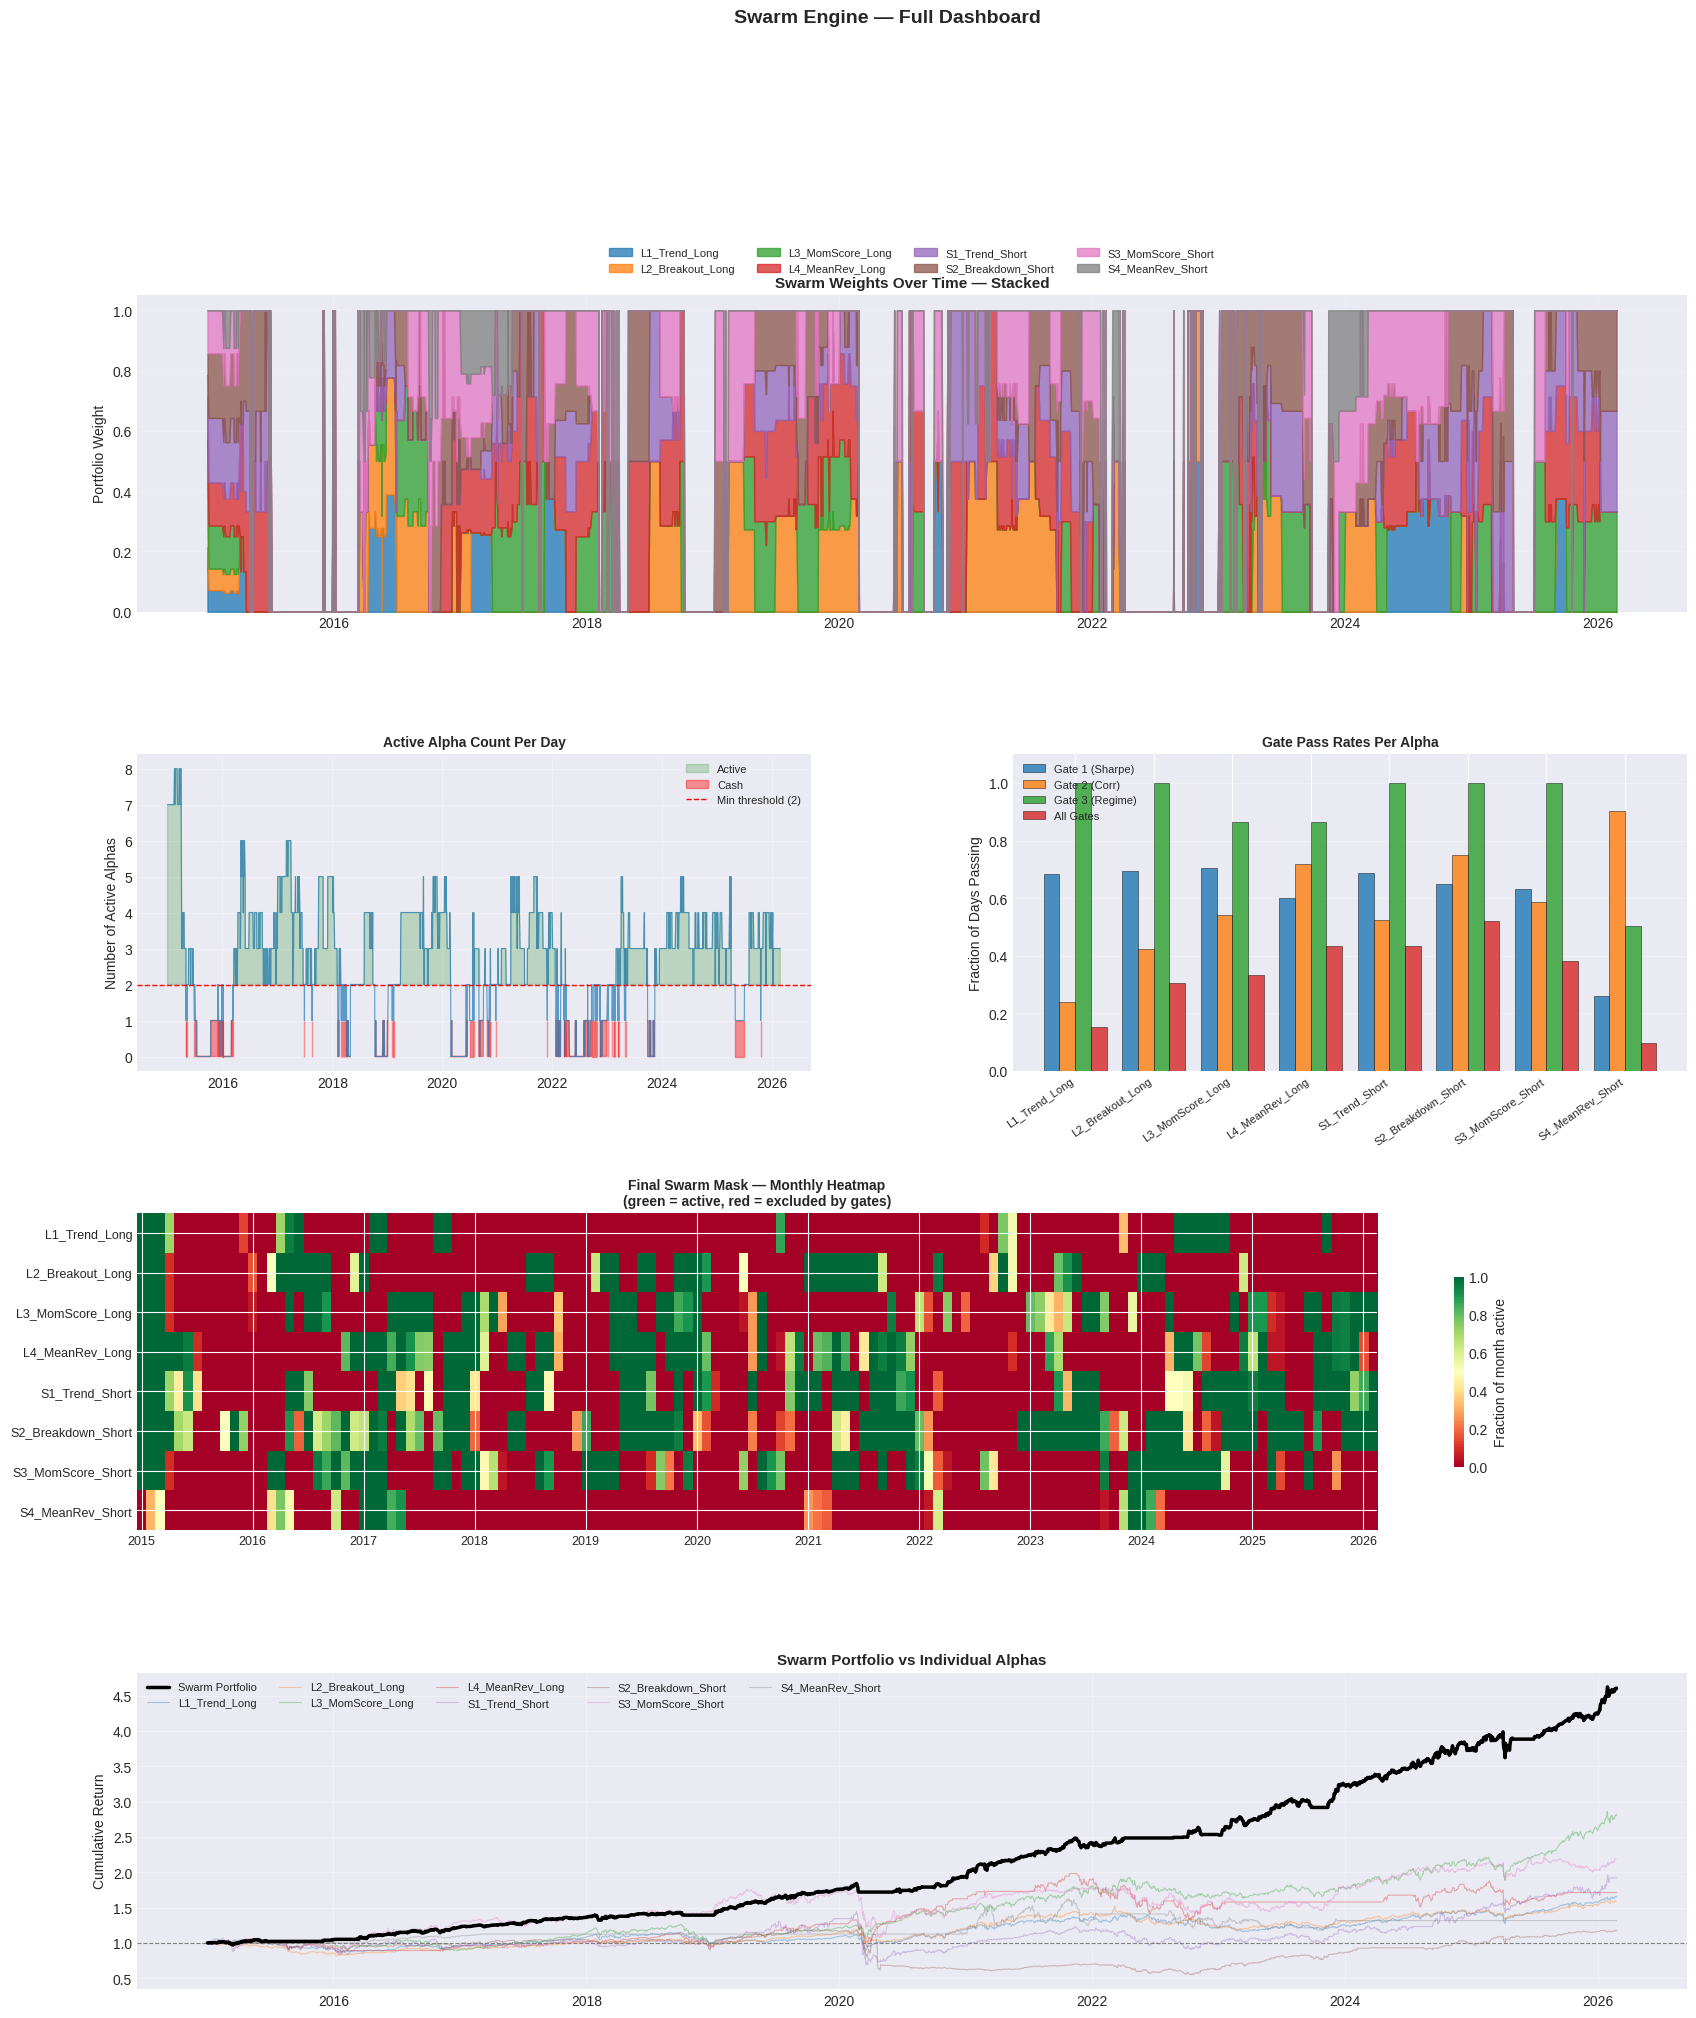


Swarm engine complete
Outputs ready: gate1_mask, gate2_mask, gate3_mask,
               final_mask, swarm_weights,
               swarm_returns, cash_days
Dashboard saved to swarm_dashboard.png


In [21]:
# Cell 10: Swarm Engine
# ============================================================
# Applies three sequential gates every day to decide which
# alphas are active and how much weight each receives.
#
# GATE 1 — Performance Gate (rolling Sharpe > min_sharpe)
# GATE 2 — Correlation Gate (prune redundant alpha pairs)
# GATE 3 — Regime Gate      (eligibility + weight multipliers)
#
# Outputs:
#   gate1_mask      : DataFrame — bool, passed performance gate
#   gate2_mask      : DataFrame — bool, passed correlation gate
#   gate3_mask      : DataFrame — bool, passed regime gate
#   final_mask      : DataFrame — bool, passed ALL three gates
#   swarm_weights   : DataFrame — final normalised daily weights
#   swarm_returns   : Series — daily swarm portfolio return
#   cash_days       : Series — bool, days portfolio went to cash


# -- 10a. Gate 1: Performance Gate -------------------------
print("Gate 1: Performance filter...")

cfg_s  = CONFIG['swarm']
window = cfg_s['lookback_days']

roll_sharpe = compute_rolling_sharpe(alpha_returns_df, window=window)

gate1_mask = roll_sharpe > cfg_s['min_sharpe']
gate1_mask.iloc[:window] = True

print(f"  Window    : {window} days")
print(f"  Threshold : Sharpe > {cfg_s['min_sharpe']}")
print(f"\n  Fraction of days passing Gate 1 per alpha:")
for col in ALPHA_NAMES:
    rate = gate1_mask[col].mean()
    print(f"    {col:24s}: {rate:.1%}")


# -- 10b. Gate 2: Correlation Gate -------------------------
print("\nGate 2: Correlation filter...")

print(f"  Max allowed pairwise correlation: "
      f"{cfg_s['max_correlation']}")

# Snap month-end dates to nearest actual trading day
# using integer position to avoid calendar key errors
monthly_dates = alpha_returns_df.resample('ME').last().index
monthly_dates_actual = [
    alpha_returns_df.index[
        alpha_returns_df.index.searchsorted(d, side='right') - 1
    ]
    for d in monthly_dates
]

gate2_mask = pd.DataFrame(
    True,
    index   = alpha_returns_df.index,
    columns = ALPHA_NAMES
)

for i, date in enumerate(monthly_dates_actual):
    # Lookback window using integer position
    pos        = alpha_returns_df.index.get_loc(date)
    start_pos  = max(0, pos - window)
    window_ret = alpha_returns_df.iloc[start_pos:pos]

    if len(window_ret) < 10:
        continue

    corr_matrix = window_ret.corr()

    # Use iloc to avoid date-based key lookup
    sharpe_now = roll_sharpe.iloc[pos]

    # Greedy pruning: exclude lower-Sharpe alpha
    # if pair correlation exceeds threshold
    excluded = set()
    for a in range(len(ALPHA_NAMES)):
        if ALPHA_NAMES[a] in excluded:
            continue
        for b in range(a + 1, len(ALPHA_NAMES)):
            if ALPHA_NAMES[b] in excluded:
                continue
            corr_val = corr_matrix.iloc[a, b]
            if corr_val > cfg_s['max_correlation']:
                sharpe_a = sharpe_now[ALPHA_NAMES[a]]
                sharpe_b = sharpe_now[ALPHA_NAMES[b]]
                loser    = ALPHA_NAMES[a] if sharpe_a < sharpe_b \
                           else ALPHA_NAMES[b]
                excluded.add(loser)

    # Apply exclusions forward to next rebalance date
    if i < len(monthly_dates_actual) - 1:
        next_date = monthly_dates_actual[i + 1]
    else:
        next_date = alpha_returns_df.index[-1]

    period_mask = (alpha_returns_df.index > date) & \
                  (alpha_returns_df.index <= next_date)

    for alpha_name in excluded:
        gate2_mask.loc[period_mask, alpha_name] = False

print(f"\n  Fraction of days passing Gate 2 per alpha:")
for col in ALPHA_NAMES:
    rate = gate2_mask[col].mean()
    print(f"    {col:24s}: {rate:.1%}")


# -- 10c. Gate 3: Regime Gate ------------------------------
print("\nGate 3: Regime filter...")

gate3_mask = eligibility.astype(bool)

print(f"  Fraction of days passing Gate 3 per alpha:")
for col in ALPHA_NAMES:
    rate = gate3_mask[col].mean()
    print(f"    {col:24s}: {rate:.1%}")


# -- 10d. Combined final mask ------------------------------
print("\nCombining all gates...")

final_mask = gate1_mask & gate2_mask & gate3_mask

print(f"\n  Fraction of days passing ALL gates per alpha:")
for col in ALPHA_NAMES:
    rate = final_mask[col].mean()
    print(f"    {col:24s}: {rate:.1%}")

n_active_daily = final_mask.sum(axis=1)

print(f"\n  Avg active alphas per day : {n_active_daily.mean():.1f}")
print(f"  Min active alphas per day : {n_active_daily.min()}")
print(f"  Max active alphas per day : {n_active_daily.max()}")


# -- 10e. Cash days ----------------------------------------
cash_days = n_active_daily < cfg_s['min_active_alphas']
print(f"\n  Days in cash (< {cfg_s['min_active_alphas']} "
      f"active alphas): "
      f"{cash_days.sum()} ({cash_days.mean():.1%})")


# -- 10f. Swarm weights ------------------------------------
print("\nComputing swarm weights...")

# Step 1: base weight = 1 for each active alpha
raw_weights = final_mask.astype(float)

# Step 2: apply regime multipliers
raw_weights = raw_weights * regime_weights

# Step 3: normalise so weights sum to 1.0 each day
row_sums = raw_weights.sum(axis=1).replace(0, np.nan)
swarm_weights = raw_weights.div(row_sums, axis=0).fillna(0)

# Step 4: cap individual weights at max_weight
swarm_weights = swarm_weights.clip(upper=cfg_s['max_weight'])

# Step 5: re-normalise after cap
row_sums2 = swarm_weights.sum(axis=1).replace(0, np.nan)
swarm_weights = swarm_weights.div(row_sums2, axis=0).fillna(0)

# Step 6: zero out cash days
swarm_weights.loc[cash_days] = 0

print(f"  Weights sum check (non-cash days):")
non_cash_sums = swarm_weights.loc[~cash_days].sum(axis=1)
print(f"    Mean : {non_cash_sums.mean():.4f}  (expect 1.0)")
print(f"    Min  : {non_cash_sums.min():.4f}")
print(f"    Max  : {non_cash_sums.max():.4f}")

print(f"\n  Mean weight per alpha (when active):")
for col in ALPHA_NAMES:
    active_w = swarm_weights[col][swarm_weights[col] > 0]
    if len(active_w) > 0:
        print(f"    {col:24s}: {active_w.mean():.3f}  "
              f"({len(active_w)} days active)")


# -- 10g. Swarm portfolio returns --------------------------
print("\nComputing swarm portfolio returns...")

swarm_returns = (alpha_returns_df * swarm_weights).sum(axis=1)
swarm_returns.name = 'Swarm'
swarm_returns.loc[cash_days] = 0
swarm_cum = (1 + swarm_returns).cumprod()

print(f"  Swarm return stream shape : {swarm_returns.shape}")
print(f"  Total return (full period): "
      f"{swarm_cum.iloc[-1] - 1:.2%}")


# -- 10h. Gate contribution analysis -----------------------
print("\nGate contribution analysis:")

after_g1    = gate1_mask.mean(axis=1).mean()
after_g1_g2 = (gate1_mask & gate2_mask).mean(axis=1).mean()
after_all   = final_mask.mean(axis=1).mean()

print(f"  Avg eligibility — no gates    : 100.0%")
print(f"  Avg eligibility — after Gate1 : {after_g1:.1%}")
print(f"  Avg eligibility — after G1+G2 : {after_g1_g2:.1%}")
print(f"  Avg eligibility — after all 3 : {after_all:.1%}")


# -- 10i. Swarm engine dashboard ---------------------------
print("\nBuilding swarm dashboard...")

all_colors = dict(zip(ALPHA_NAMES, colors_long + colors_short))

fig = plt.figure(figsize=(20, 22))
gs  = gridspec.GridSpec(4, 2, figure=fig,
                         hspace=0.45, wspace=0.3)


# ── Panel 1: Stacked weights over time --------------------
ax1 = fig.add_subplot(gs[0, :])
bottom = np.zeros(len(swarm_weights))
for col in ALPHA_NAMES:
    ax1.fill_between(
        swarm_weights.index,
        bottom,
        bottom + swarm_weights[col].values,
        label = col,
        color = all_colors[col],
        alpha = 0.75
    )
    bottom = bottom + swarm_weights[col].values
ax1.set_title('Swarm Weights Over Time — Stacked',
              fontweight='bold', fontsize=11)
ax1.set_ylabel('Portfolio Weight')
ax1.set_ylim(0, 1.05)
ax1.legend(fontsize=8, ncol=4,
           loc='upper center',
           bbox_to_anchor=(0.5, 1.18))
ax1.grid(True, alpha=0.2)


# ── Panel 2: Active alpha count per day -------------------
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(n_active_daily.index, n_active_daily,
         color='#1f77b4', linewidth=0.8, alpha=0.7)

active_mask = n_active_daily >= cfg_s['min_active_alphas']
cash_mask   = n_active_daily < cfg_s['min_active_alphas']

ax2.fill_between(n_active_daily.index,
                 cfg_s['min_active_alphas'],
                 n_active_daily,
                 where=active_mask,
                 alpha=0.2, color='green', label='Active')

ax2.fill_between(n_active_daily.index,
                 0, n_active_daily,
                 where=cash_mask,
                 alpha=0.4, color='red', label='Cash')

ax2.axhline(cfg_s['min_active_alphas'],
            color='red', linewidth=1, linestyle='--',
            label=f"Min threshold ({cfg_s['min_active_alphas']})")
ax2.set_title('Active Alpha Count Per Day',
              fontweight='bold', fontsize=10)
ax2.set_ylabel('Number of Active Alphas')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)


# ── Panel 3: Gate pass rates bar chart --------------------
ax3 = fig.add_subplot(gs[1, 1])
gate_data = pd.DataFrame({
    'Gate 1 (Sharpe)': gate1_mask.mean(),
    'Gate 2 (Corr)':   gate2_mask.mean(),
    'Gate 3 (Regime)': gate3_mask.mean(),
    'All Gates':       final_mask.mean(),
}, index=ALPHA_NAMES)

x     = np.arange(len(ALPHA_NAMES))
width = 0.2
gate_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, (col, gc) in enumerate(zip(gate_data.columns, gate_colors)):
    ax3.bar(x + i * width, gate_data[col],
            width, label=col,
            color=gc, alpha=0.8,
            edgecolor='black', linewidth=0.4)

ax3.set_xticks(x + width * 1.5)
ax3.set_xticklabels(ALPHA_NAMES, rotation=35,
                    ha='right', fontsize=8)
ax3.set_title('Gate Pass Rates Per Alpha',
              fontweight='bold', fontsize=10)
ax3.set_ylabel('Fraction of Days Passing')
ax3.legend(fontsize=8)
ax3.set_ylim(0, 1.1)
ax3.grid(True, alpha=0.3, axis='y')


# ── Panel 4: Final mask heatmap (monthly) -----------------
ax4 = fig.add_subplot(gs[2, :])
final_monthly = final_mask.resample('ME').mean()
im4 = ax4.imshow(
    final_monthly.T.values,
    aspect='auto',
    cmap='RdYlGn',
    vmin=0, vmax=1,
    interpolation='nearest'
)
yearly_idx = [i for i, d in enumerate(final_monthly.index)
              if d.month == 1]
ax4.set_xticks(yearly_idx)
ax4.set_xticklabels(
    [final_monthly.index[i].year for i in yearly_idx],
    fontsize=9
)
ax4.set_yticks(range(len(ALPHA_NAMES)))
ax4.set_yticklabels(ALPHA_NAMES, fontsize=9)
plt.colorbar(im4, ax=ax4,
             label='Fraction of month active', shrink=0.6)
ax4.set_title(
    'Final Swarm Mask — Monthly Heatmap\n'
    '(green = active, red = excluded by gates)',
    fontweight='bold', fontsize=10
)


# ── Panel 5: Swarm equity curve preview -------------------
ax5 = fig.add_subplot(gs[3, :])
ax5.plot(swarm_cum.index, swarm_cum,
         color='black', linewidth=2.5,
         label='Swarm Portfolio', zorder=5)

for col in ALPHA_NAMES:
    cum = (1 + alpha_returns_df[col]).cumprod()
    ax5.plot(cum.index, cum,
             color=all_colors[col],
             linewidth=0.8, alpha=0.35,
             label=col)

ax5.axhline(1, color='grey', linewidth=0.8, linestyle='--')
ax5.set_title('Swarm Portfolio vs Individual Alphas',
              fontweight='bold', fontsize=11)
ax5.set_ylabel('Cumulative Return')
ax5.legend(fontsize=8, ncol=5, loc='upper left')
ax5.grid(True, alpha=0.3)

fig.suptitle('Swarm Engine — Full Dashboard',
             fontsize=14, fontweight='bold', y=1.01)

plt.savefig('swarm_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSwarm engine complete")
print("Outputs ready: gate1_mask, gate2_mask, gate3_mask,")
print("               final_mask, swarm_weights,")
print("               swarm_returns, cash_days")
print("Dashboard saved to swarm_dashboard.png")

# Cell 11 — Portfolio Construction.

Building P1: Equal weight all alphas...
  P1 total return: 85.28%
Building P2: Equal weight long alphas only...
  P2 total return: 93.99%
Building P3: Swarm without regime gate...
  P3 total return: 399.93%
  P3 cash days   : 582 (20.8%)
Building P4: Full swarm (all gates + regime)...
  P4 total return: 360.74%
  P4 cash days   : 677 (24.2%)

portfolio_returns shape: (2802, 4)

Computing portfolio performance stats...

Portfolio Performance (full period):
                  Ann. Return  Ann. Vol  Sharpe  Max Drawdown  Calmar  Hit Rate  Win/Loss Ratio
P1_EqualWeight         0.0620    0.0960  0.6430       -0.2440  0.2540    0.5420          0.9530
P2_LongOnly            0.0670    0.1020  0.6580       -0.1880  0.3570    0.5600          0.8840
P3_SwarmNoRegime       0.1590    0.0810  1.9790       -0.1000  1.5920    0.4560          1.0790
P4_FullSwarm           0.1500    0.0750  2.0100       -0.0920  1.6390    0.4400          1.0790

Building full comparison table (overlap period)...

Full Co

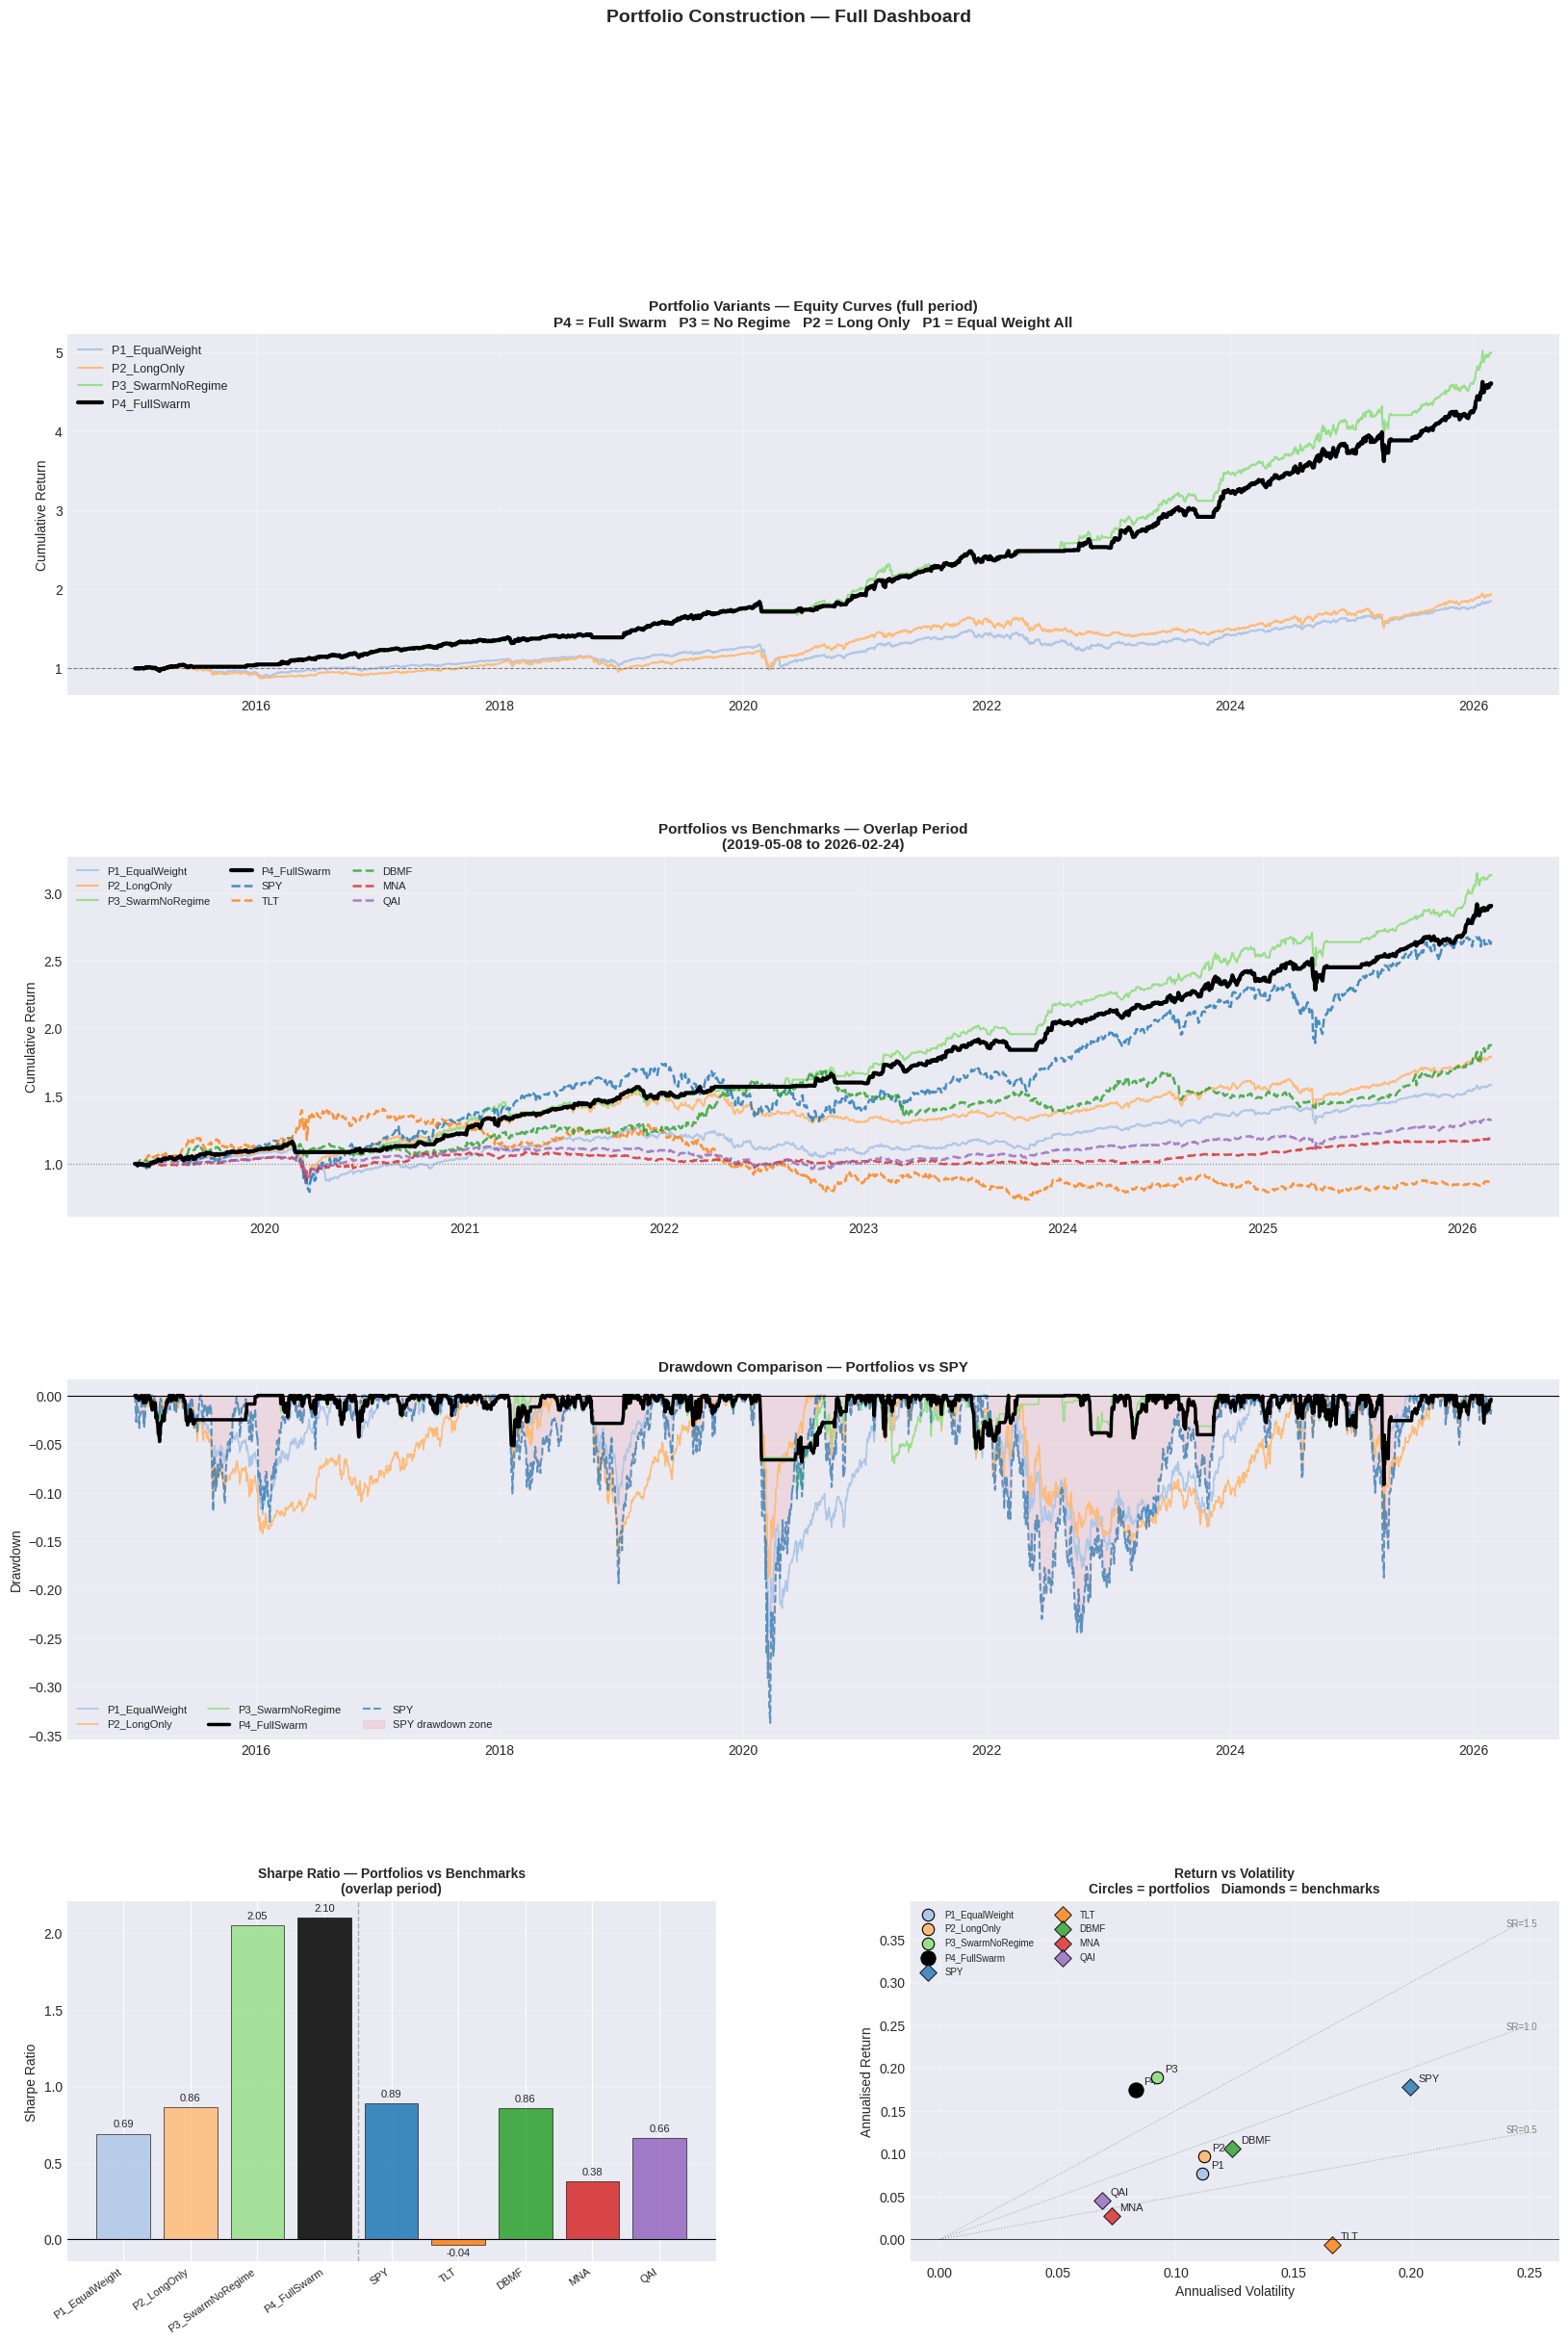


Portfolio construction complete
Outputs ready: portfolio_returns, portfolio_perf,
               full_comparison
Dashboard saved to portfolio_dashboard.png


In [22]:
# Cell 11: Portfolio Construction
# ============================================================
# Builds four portfolio variants so we can isolate the value
# added by each layer of the framework:
#
#   P1 — Equal Weight All Alphas (no gates, no regime)
#        Baseline: what if we just ran all 8 alphas equally?
#
#   P2 — Equal Weight Long Only (no gates, no regime)
#        Isolates contribution of short alphas
#
#   P3 — Swarm No Regime (Gate 1 + Gate 2 only)
#        Isolates value of regime filtering
#
#   P4 — Full Swarm (Gate 1 + Gate 2 + Gate 3 + regime weights)
#        The complete framework from Cell 10
#
# Each portfolio is then compared against all benchmarks
# over both the full period and the overlap period.
#
# Outputs:
#   portfolio_returns : DataFrame — daily returns for P1-P4
#   portfolio_perf    : DataFrame — performance stats for P1-P4
#   full_comparison   : DataFrame — all portfolios + benchmarks


# -- 11a. P1: Equal Weight All Alphas ----------------------
print("Building P1: Equal weight all alphas...")

# Simple equal weight — no gates, no regime adjustment
ew_weights = pd.DataFrame(
    1.0 / len(ALPHA_NAMES),
    index   = alpha_returns_df.index,
    columns = ALPHA_NAMES
)

p1_returns = (alpha_returns_df * ew_weights).sum(axis=1)
p1_returns.name = 'P1_EqualWeight'
print(f"  P1 total return: "
      f"{(1 + p1_returns).cumprod().iloc[-1] - 1:.2%}")


# -- 11b. P2: Equal Weight Long Only -----------------------
print("Building P2: Equal weight long alphas only...")

long_only_names = [n for n in ALPHA_NAMES
                   if SIDE[n] == +1]
ew_long_weights = pd.DataFrame(
    0.0,
    index   = alpha_returns_df.index,
    columns = ALPHA_NAMES
)
for col in long_only_names:
    ew_long_weights[col] = 1.0 / len(long_only_names)

p2_returns = (alpha_returns_df * ew_long_weights).sum(axis=1)
p2_returns.name = 'P2_LongOnly'
print(f"  P2 total return: "
      f"{(1 + p2_returns).cumprod().iloc[-1] - 1:.2%}")


# -- 11c. P3: Swarm without regime (Gate 1 + Gate 2 only) --
print("Building P3: Swarm without regime gate...")

no_regime_mask = gate1_mask & gate2_mask

# Equal weight surviving alphas, no regime multipliers
nr_raw   = no_regime_mask.astype(float)
nr_sums  = nr_raw.sum(axis=1).replace(0, np.nan)
nr_weights = nr_raw.div(nr_sums, axis=0).fillna(0)

# Cap and re-normalise
nr_weights = nr_weights.clip(upper=cfg_s['max_weight'])
nr_sums2   = nr_weights.sum(axis=1).replace(0, np.nan)
nr_weights = nr_weights.div(nr_sums2, axis=0).fillna(0)

# Cash days: fewer than min_active_alphas survive
nr_n_active = no_regime_mask.sum(axis=1)
nr_cash     = nr_n_active < cfg_s['min_active_alphas']
nr_weights.loc[nr_cash] = 0

p3_returns = (alpha_returns_df * nr_weights).sum(axis=1)
p3_returns.name = 'P3_SwarmNoRegime'
p3_returns.loc[nr_cash] = 0
print(f"  P3 total return: "
      f"{(1 + p3_returns).cumprod().iloc[-1] - 1:.2%}")
print(f"  P3 cash days   : {nr_cash.sum()} ({nr_cash.mean():.1%})")


# -- 11d. P4: Full Swarm (from Cell 10) --------------------
print("Building P4: Full swarm (all gates + regime)...")

p4_returns = swarm_returns.copy()
p4_returns.name = 'P4_FullSwarm'
print(f"  P4 total return: "
      f"{(1 + p4_returns).cumprod().iloc[-1] - 1:.2%}")
print(f"  P4 cash days   : "
      f"{cash_days.sum()} ({cash_days.mean():.1%})")


# -- 11e. Collect all portfolio returns --------------------
portfolio_returns = pd.concat(
    [p1_returns, p2_returns, p3_returns, p4_returns],
    axis=1
).fillna(0)

print(f"\nportfolio_returns shape: {portfolio_returns.shape}")


# -- 11f. Performance stats — all portfolios ---------------
print("\nComputing portfolio performance stats...")

port_perf_rows = []
for col in portfolio_returns.columns:
    port_perf_rows.append(
        full_performance(portfolio_returns[col], name=col)
    )

portfolio_perf = pd.DataFrame(port_perf_rows)

display_cols = ['Ann. Return', 'Ann. Vol', 'Sharpe',
                'Max Drawdown', 'Calmar', 'Hit Rate',
                'Win/Loss Ratio']

print("\nPortfolio Performance (full period):")
print("=" * 70)
print(portfolio_perf[display_cols].round(3).to_string())


# -- 11g. Full comparison table ----------------------------
# Portfolios + benchmarks over overlap period
print("\nBuilding full comparison table (overlap period)...")

overlap_port   = portfolio_returns.loc[overlap_start:]
overlap_bench  = bench_returns.loc[overlap_start:]

all_ret = pd.concat([overlap_port, overlap_bench], axis=1).fillna(0)

comparison_rows = []
for col in all_ret.columns:
    comparison_rows.append(
        full_performance(all_ret[col], name=col)
    )

full_comparison = pd.DataFrame(comparison_rows)

print("\nFull Comparison (overlap period — portfolios vs benchmarks):")
print("=" * 70)
print(full_comparison[display_cols].round(3).to_string())


# -- 11h. Drawdown series ----------------------------------
def compute_drawdown_series(returns_series: pd.Series) -> pd.Series:
    """Rolling drawdown from peak."""
    cum = (1 + returns_series.fillna(0)).cumprod()
    peak = cum.cummax()
    return (cum / peak - 1)


# -- 11i. Portfolio construction dashboard -----------------
print("\nBuilding portfolio dashboard...")

port_colors = {
    'P1_EqualWeight':   '#aec7e8',
    'P2_LongOnly':      '#ffbb78',
    'P3_SwarmNoRegime': '#98df8a',
    'P4_FullSwarm':     '#000000',
}

fig = plt.figure(figsize=(20, 26))
gs  = gridspec.GridSpec(4, 2, figure=fig,
                         hspace=0.45, wspace=0.3)


# ── Panel 1: Portfolio equity curves (full period) --------
ax1 = fig.add_subplot(gs[0, :])
for col in portfolio_returns.columns:
    cum = (1 + portfolio_returns[col]).cumprod()
    lw  = 3 if col == 'P4_FullSwarm' else 1.5
    ax1.plot(cum.index, cum,
             label=col,
             color=port_colors[col],
             linewidth=lw,
             zorder=5 if col == 'P4_FullSwarm' else 2)

ax1.axhline(1, color='grey', linewidth=0.8, linestyle='--')
ax1.set_title('Portfolio Variants — Equity Curves (full period)\n'
              'P4 = Full Swarm   P3 = No Regime   '
              'P2 = Long Only   P1 = Equal Weight All',
              fontweight='bold', fontsize=11)
ax1.set_ylabel('Cumulative Return')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)


# ── Panel 2: Portfolio vs benchmarks (overlap period) -----
ax2 = fig.add_subplot(gs[1, :])

for col in portfolio_returns.columns:
    r   = portfolio_returns[col].loc[overlap_start:]
    cum = (1 + r).cumprod()
    lw  = 3 if col == 'P4_FullSwarm' else 1.5
    ax2.plot(cum.index, cum,
             label=col,
             color=port_colors[col],
             linewidth=lw,
             zorder=5 if col == 'P4_FullSwarm' else 2)

for bm in bench_close.columns:
    r   = bench_returns[bm].loc[overlap_start:].fillna(0)
    cum = (1 + r).cumprod()
    ax2.plot(cum.index, cum,
             label=bm,
             color=bm_colors.get(bm, 'grey'),
             linewidth=1.8,
             linestyle='--',
             alpha=0.8)

ax2.axhline(1, color='grey', linewidth=0.8, linestyle=':')
ax2.set_title(
    f'Portfolios vs Benchmarks — Overlap Period\n'
    f'({overlap_start.date()} to {overlap_end.date()})',
    fontweight='bold', fontsize=11
)
ax2.set_ylabel('Cumulative Return')
ax2.legend(fontsize=8, ncol=3, loc='upper left')
ax2.grid(True, alpha=0.3)


# ── Panel 3: Drawdown comparison --------------------------
ax3 = fig.add_subplot(gs[2, :])

for col in portfolio_returns.columns:
    dd  = compute_drawdown_series(portfolio_returns[col])
    lw  = 2.5 if col == 'P4_FullSwarm' else 1.2
    ax3.plot(dd.index, dd,
             label=col,
             color=port_colors[col],
             linewidth=lw,
             zorder=5 if col == 'P4_FullSwarm' else 2)

# Add SPY drawdown as reference
spy_dd = compute_drawdown_series(bench_returns['SPY'].fillna(0))
ax3.plot(spy_dd.index, spy_dd,
         label='SPY',
         color=bm_colors['SPY'],
         linewidth=1.5,
         linestyle='--',
         alpha=0.7)

ax3.axhline(0, color='black', linewidth=0.8)
ax3.fill_between(spy_dd.index, spy_dd, 0,
                 alpha=0.08, color='red',
                 label='SPY drawdown zone')
ax3.set_title('Drawdown Comparison — Portfolios vs SPY',
              fontweight='bold', fontsize=11)
ax3.set_ylabel('Drawdown')
ax3.legend(fontsize=8, ncol=3)
ax3.grid(True, alpha=0.3)


# ── Panel 4: Sharpe comparison bar chart ------------------
ax4 = fig.add_subplot(gs[3, 0])

comp_sharpes = full_comparison.set_index(
    full_comparison.index)['Sharpe']

bar_cols = (
    [port_colors[p] for p in portfolio_returns.columns] +
    [bm_colors.get(b, 'grey') for b in bench_close.columns]
)

bars = ax4.bar(range(len(comp_sharpes)),
               comp_sharpes.values,
               color=bar_cols,
               alpha=0.85,
               edgecolor='black',
               linewidth=0.5)

ax4.axhline(0, color='black', linewidth=0.8)
ax4.axvline(len(portfolio_returns.columns) - 0.5,
            color='grey', linewidth=1,
            linestyle='--', alpha=0.6)
ax4.set_xticks(range(len(comp_sharpes)))
ax4.set_xticklabels(comp_sharpes.index,
                    rotation=35, ha='right', fontsize=8)
ax4.set_title('Sharpe Ratio — Portfolios vs Benchmarks\n'
              '(overlap period)',
              fontweight='bold', fontsize=10)
ax4.set_ylabel('Sharpe Ratio')

for bar, val in zip(bars, comp_sharpes.values):
    ypos = bar.get_height() + 0.03 if val >= 0 \
           else bar.get_height() - 0.08
    ax4.text(bar.get_x() + bar.get_width() / 2,
             ypos, f'{val:.2f}',
             ha='center', va='bottom', fontsize=8)

ax4.grid(True, alpha=0.3, axis='y')


# ── Panel 5: Return vs Volatility scatter -----------------
ax5 = fig.add_subplot(gs[3, 1])

for col in portfolio_returns.columns:
    r      = portfolio_returns[col].loc[overlap_start:]
    stats  = full_performance(r)
    ms     = 120 if col == 'P4_FullSwarm' else 80
    ax5.scatter(stats['Ann. Vol'], stats['Ann. Return'],
                s=ms,
                color=port_colors[col],
                edgecolors='black',
                linewidths=0.8,
                zorder=5,
                label=col)
    ax5.annotate(col.split('_')[0],
                 (stats['Ann. Vol'], stats['Ann. Return']),
                 textcoords='offset points',
                 xytext=(6, 4), fontsize=8)

for bm in bench_close.columns:
    r     = bench_returns[bm].loc[overlap_start:].fillna(0)
    stats = full_performance(r)
    ax5.scatter(stats['Ann. Vol'], stats['Ann. Return'],
                s=80,
                color=bm_colors.get(bm, 'grey'),
                marker='D',
                edgecolors='black',
                linewidths=0.8,
                alpha=0.8,
                label=bm)
    ax5.annotate(bm,
                 (stats['Ann. Vol'], stats['Ann. Return']),
                 textcoords='offset points',
                 xytext=(6, 4), fontsize=8)

# Iso-Sharpe lines
vol_range = np.linspace(0, 0.25, 100)
for sr in [0.5, 1.0, 1.5]:
    ax5.plot(vol_range, sr * vol_range,
             linestyle=':', linewidth=0.8,
             color='grey', alpha=0.6)
    ax5.text(0.24, sr * 0.24 + 0.005,
             f'SR={sr}', fontsize=7, color='grey')

ax5.axhline(0, color='black', linewidth=0.5)
ax5.set_xlabel('Annualised Volatility')
ax5.set_ylabel('Annualised Return')
ax5.set_title('Return vs Volatility\n'
              'Circles = portfolios   Diamonds = benchmarks',
              fontweight='bold', fontsize=10)
ax5.legend(fontsize=7, ncol=2)
ax5.grid(True, alpha=0.3)

fig.suptitle('Portfolio Construction — Full Dashboard',
             fontsize=14, fontweight='bold', y=1.01)

plt.savefig('portfolio_dashboard.png',
            dpi=150, bbox_inches='tight')
plt.show()

print("\nPortfolio construction complete")
print("Outputs ready: portfolio_returns, portfolio_perf,")
print("               full_comparison")
print("Dashboard saved to portfolio_dashboard.png")

# Cell 12 — Results Dashboard and Correlation Analysis.

Computing alpha return correlations...
  Diversification ratio — equal weight : 1.446
  Diversification ratio — swarm weights: 1.377
  (Higher is better — 1.0 = no benefit)

Average pairwise correlation by style pair:
  mean_reversion       x mean_reversion      : +0.153
  mean_reversion       x trend_following     : +0.346
  mean_reversion       x momentum            : +0.371
  trend_following      x trend_following     : +0.347
  breakout             x mean_reversion      : +0.258
  breakout             x trend_following     : +0.445
  breakout             x breakout            : +0.098
  breakout             x momentum            : +0.437
  momentum             x trend_following     : +0.575
  momentum             x momentum            : +0.325

Computing rolling Sharpe (full history)...

Building annual returns table...

Annual Returns:
      P1_EqualWeight  P2_LongOnly  P3_SwarmNoRegime  P4_FullSwarm     SPY     TLT    DBMF     MNA     QAI
Date                                     

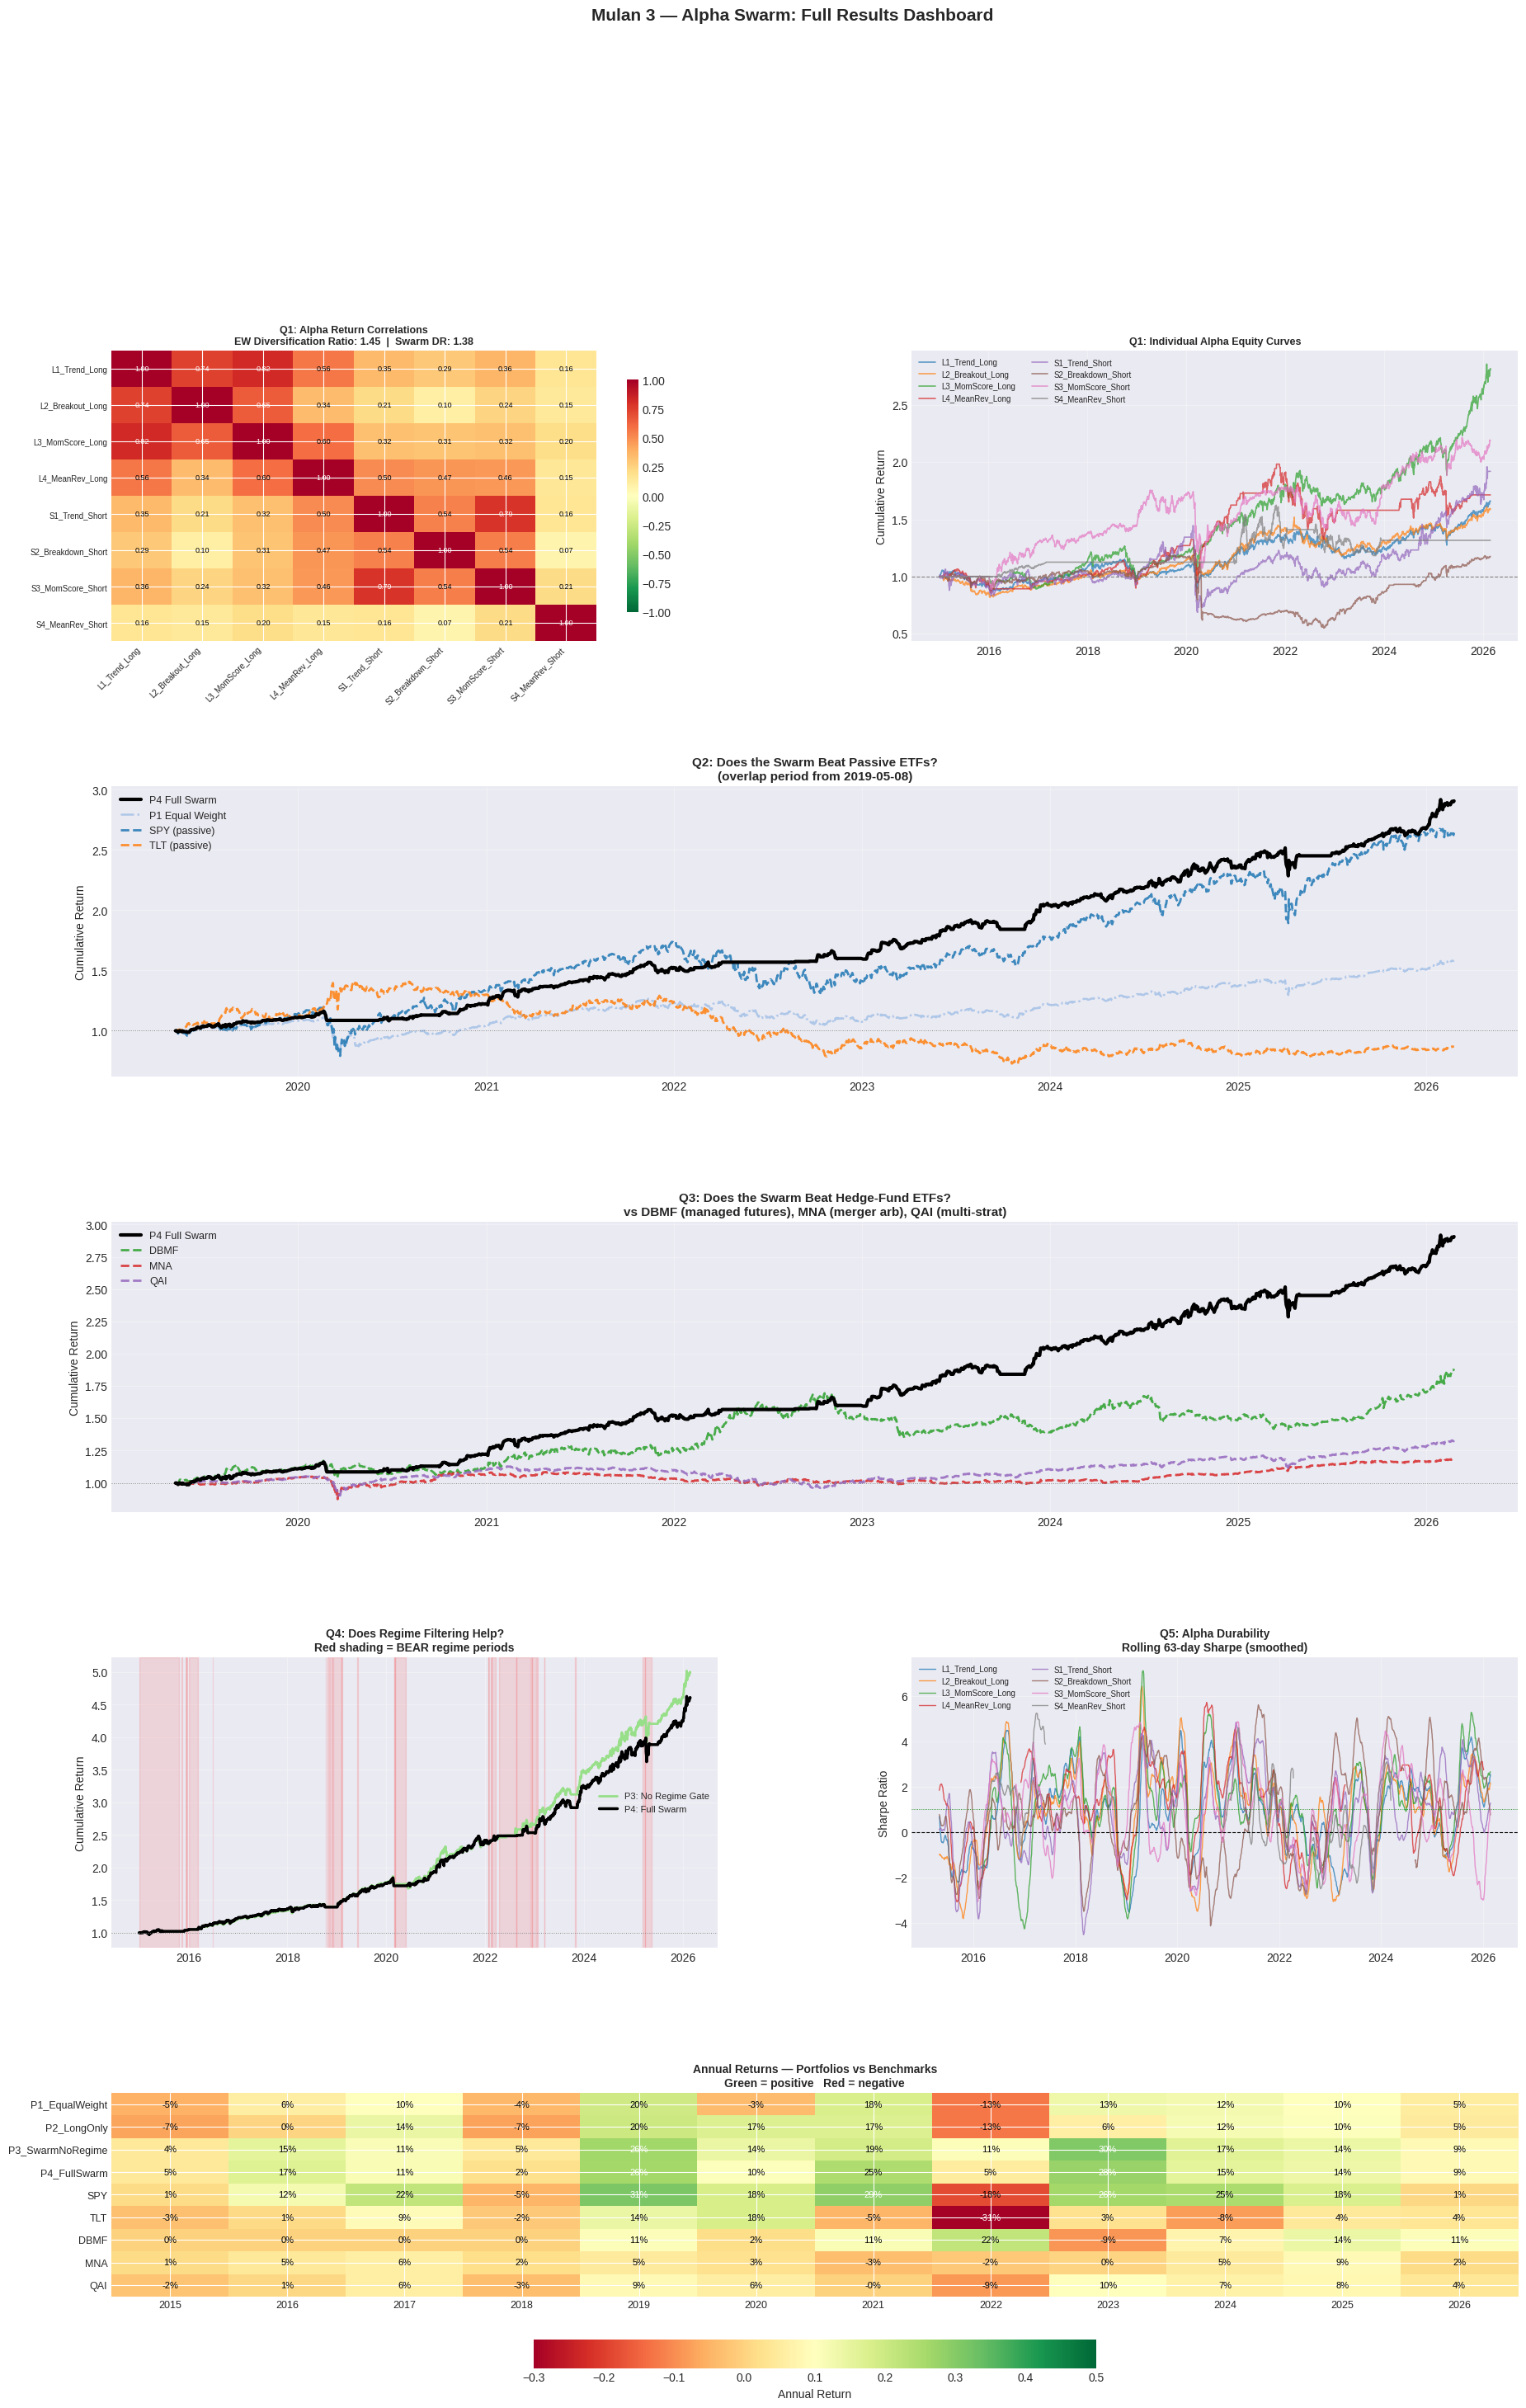


MULAN 3 — FINAL RESULTS SUMMARY

Full Comparison (overlap period):
                  Ann. Return  Ann. Vol  Sharpe  Max Drawdown  Calmar  Hit Rate  Win/Loss Ratio
P1_EqualWeight         0.0770    0.1110  0.6880       -0.2440  0.3140    0.5470          0.9470
P2_LongOnly            0.0970    0.1120  0.8630       -0.1880  0.5150    0.5640          0.9010
P3_SwarmNoRegime       0.1890    0.0920  2.0500       -0.1000  1.8820    0.4730          1.0730
P4_FullSwarm           0.1740    0.0830  2.1010       -0.0920  1.8990    0.4450          1.0940
SPY                    0.1770    0.1990  0.8890       -0.3370  0.5260    0.5540          0.9420
TLT                   -0.0070    0.1660 -0.0400       -0.4840 -0.0140    0.5050          0.9680
DBMF                   0.1060    0.1240  0.8570       -0.2040  0.5210    0.5470          0.9160
MNA                    0.0270    0.0730  0.3760       -0.1670  0.1640    0.4920          1.0160
QAI                    0.0450    0.0690  0.6580       -0.1490  0.303

In [23]:
# Cell 12: Results Dashboard & Correlation Analysis
# ============================================================
# Answers the five core questions from the project plan:
#
#   Q1. Do styles complement each other?
#       -> Alpha correlation heatmap + diversification ratio
#
#   Q2. Does the swarm beat passive?
#       -> Equity curves + Sharpe vs SPY, TLT
#
#   Q3. Does the swarm beat hedge-fund ETFs?
#       -> Equity curves + Sharpe vs DBMF, MNA, QAI
#
#   Q4. Does regime filtering help?
#       -> P3 (no regime) vs P4 (full swarm) side by side
#
#   Q5. Which alphas are most durable?
#       -> Rolling Sharpe per alpha across full history


# -- 12a. Alpha return correlations ------------------------
print("Computing alpha return correlations...")

# Full period correlation
alpha_corr_full = alpha_returns_df.corr()

# Overlap period correlation
alpha_corr_overlap = alpha_returns_df.loc[overlap_start:].corr()

# Diversification ratio:
# ratio of weighted avg volatility to portfolio volatility
# Higher = more diversification benefit
def diversification_ratio(returns_df: pd.DataFrame,
                           weights: pd.Series) -> float:
    """
    DR = (w' * sigma_individual) / sigma_portfolio
    where sigma = annualised vol vector.
    """
    vols      = returns_df.std() * np.sqrt(252)
    port_vol  = (returns_df * weights).sum(axis=1).std() \
                * np.sqrt(252)
    weighted_avg_vol = (weights * vols).sum()
    return weighted_avg_vol / port_vol if port_vol > 0 else np.nan


# Equal weight diversification ratio
ew  = pd.Series(1 / len(ALPHA_NAMES), index=ALPHA_NAMES)
dr  = diversification_ratio(alpha_returns_df, ew)

# Swarm weight diversification ratio (mean weights)
sw  = swarm_weights[swarm_weights.sum(axis=1) > 0].mean()
dr_swarm = diversification_ratio(alpha_returns_df, sw)

print(f"  Diversification ratio — equal weight : {dr:.3f}")
print(f"  Diversification ratio — swarm weights: {dr_swarm:.3f}")
print(f"  (Higher is better — 1.0 = no benefit)")


# -- 12b. Style-level correlation --------------------------
# Group alphas by style and compute avg within/across style corr
style_map = {n: CONFIG['alphas'][n]['style'] for n in ALPHA_NAMES}
styles    = list(set(style_map.values()))

print("\nAverage pairwise correlation by style pair:")
style_corr = {}
for s1 in styles:
    for s2 in styles:
        alphas_s1 = [n for n in ALPHA_NAMES
                     if style_map[n] == s1]
        alphas_s2 = [n for n in ALPHA_NAMES
                     if style_map[n] == s2]
        pairs = []
        for a in alphas_s1:
            for b in alphas_s2:
                if a != b:
                    pairs.append(alpha_corr_full.loc[a, b])
        if pairs:
            avg = np.mean(pairs)
            style_corr[(s1, s2)] = avg
            if s1 <= s2:
                print(f"  {s1:20s} x {s2:20s}: {avg:+.3f}")


# -- 12c. Rolling Sharpe — all alphas ----------------------
print("\nComputing rolling Sharpe (full history)...")

window       = CONFIG['swarm']['lookback_days']
roll_sharpe  = compute_rolling_sharpe(alpha_returns_df,
                                       window=window)


# -- 12d. Annual returns table -----------------------------
print("\nBuilding annual returns table...")

def annual_returns(returns_series: pd.Series) -> pd.Series:
    """Calendar year returns."""
    return returns_series.groupby(
        returns_series.index.year
    ).apply(lambda x: (1 + x).prod() - 1)


all_streams = pd.concat([
    portfolio_returns,
    bench_returns[bench_close.columns].fillna(0)
], axis=1)

annual_table = pd.DataFrame({
    col: annual_returns(all_streams[col])
    for col in all_streams.columns
})

print("\nAnnual Returns:")
print("=" * 80)
print(annual_table.round(3).to_string())


# -- 12e. Monthly return distribution ----------------------
def monthly_returns(returns_series: pd.Series) -> pd.Series:
    """Calendar month returns."""
    return returns_series.resample('ME').apply(
        lambda x: (1 + x).prod() - 1
    )

p4_monthly = monthly_returns(p4_returns)
spy_monthly = monthly_returns(bench_returns['SPY'].fillna(0))


# -- 12f. Build the master dashboard -----------------------
print("\nBuilding master results dashboard...")

fig = plt.figure(figsize=(22, 32))
gs  = gridspec.GridSpec(5, 2, figure=fig,
                         hspace=0.5, wspace=0.32)


# ── Q1: Alpha correlation heatmap -------------------------
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(
    alpha_corr_full.values,
    cmap='RdYlGn_r',
    vmin=-1, vmax=1,
    aspect='auto'
)
ax1.set_xticks(range(len(ALPHA_NAMES)))
ax1.set_xticklabels(ALPHA_NAMES, rotation=45,
                    ha='right', fontsize=7)
ax1.set_yticks(range(len(ALPHA_NAMES)))
ax1.set_yticklabels(ALPHA_NAMES, fontsize=7)
for i in range(len(ALPHA_NAMES)):
    for j in range(len(ALPHA_NAMES)):
        val = alpha_corr_full.iloc[i, j]
        ax1.text(j, i, f'{val:.2f}',
                 ha='center', va='center',
                 fontsize=6.5,
                 color='white' if abs(val) > 0.6
                 else 'black')
plt.colorbar(im1, ax=ax1, shrink=0.8)
ax1.set_title(
    f'Q1: Alpha Return Correlations\n'
    f'EW Diversification Ratio: {dr:.2f}  |  '
    f'Swarm DR: {dr_swarm:.2f}',
    fontweight='bold', fontsize=9
)


# ── Q1: Cumulative alpha returns ---------------------------
ax2 = fig.add_subplot(gs[0, 1])
for col in ALPHA_NAMES:
    cum = (1 + alpha_returns_df[col]).cumprod()
    ax2.plot(cum.index, cum,
             color=all_colors[col],
             linewidth=1.2,
             alpha=0.7,
             label=col)
ax2.axhline(1, color='grey',
            linewidth=0.8, linestyle='--')
ax2.set_title('Q1: Individual Alpha Equity Curves',
              fontweight='bold', fontsize=9)
ax2.set_ylabel('Cumulative Return')
ax2.legend(fontsize=7, ncol=2)
ax2.grid(True, alpha=0.3)


# ── Q2: Swarm vs passive benchmarks -----------------------
ax3 = fig.add_subplot(gs[1, :])
passive = ['SPY', 'TLT']

p4_cum = (1 + p4_returns.loc[overlap_start:]).cumprod()
ax3.plot(p4_cum.index, p4_cum,
         color='black', linewidth=3,
         label='P4 Full Swarm', zorder=5)

p1_cum = (1 + p1_returns.loc[overlap_start:]).cumprod()
ax3.plot(p1_cum.index, p1_cum,
         color=port_colors['P1_EqualWeight'],
         linewidth=1.8,
         label='P1 Equal Weight',
         linestyle='-.')

for bm in passive:
    if bm in bench_returns.columns:
        r   = bench_returns[bm].loc[overlap_start:].fillna(0)
        cum = (1 + r).cumprod()
        ax3.plot(cum.index, cum,
                 color=bm_colors[bm],
                 linewidth=2,
                 linestyle='--',
                 label=f'{bm} (passive)',
                 alpha=0.85)

ax3.axhline(1, color='grey',
            linewidth=0.7, linestyle=':')
ax3.set_title(
    'Q2: Does the Swarm Beat Passive ETFs?\n'
    f'(overlap period from {overlap_start.date()})',
    fontweight='bold', fontsize=11
)
ax3.set_ylabel('Cumulative Return')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)


# ── Q3: Swarm vs hedge-fund ETFs --------------------------
ax4 = fig.add_subplot(gs[2, :])
hf_bms = ['DBMF', 'MNA', 'QAI']

ax4.plot(p4_cum.index, p4_cum,
         color='black', linewidth=3,
         label='P4 Full Swarm', zorder=5)

for bm in hf_bms:
    if bm in bench_returns.columns:
        r   = bench_returns[bm].loc[overlap_start:].fillna(0)
        cum = (1 + r).cumprod()
        ax4.plot(cum.index, cum,
                 color=bm_colors.get(bm, 'grey'),
                 linewidth=2,
                 linestyle='--',
                 label=f'{bm}',
                 alpha=0.85)

ax4.axhline(1, color='grey',
            linewidth=0.7, linestyle=':')
ax4.set_title(
    'Q3: Does the Swarm Beat Hedge-Fund ETFs?\n'
    'vs DBMF (managed futures), MNA (merger arb), '
    'QAI (multi-strat)',
    fontweight='bold', fontsize=11
)
ax4.set_ylabel('Cumulative Return')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)


# ── Q4: Regime filtering value add ------------------------
ax5 = fig.add_subplot(gs[3, 0])

p3_cum = (1 + p3_returns).cumprod()
p4_cum_full = (1 + p4_returns).cumprod()

ax5.plot(p3_cum.index, p3_cum,
         color=port_colors['P3_SwarmNoRegime'],
         linewidth=2,
         label='P3: No Regime Gate')
ax5.plot(p4_cum_full.index, p4_cum_full,
         color='black', linewidth=2.5,
         label='P4: Full Swarm')

# Shade regime periods
bear_periods = (trend_regime == 'BEAR')
for idx in range(1, len(bear_periods)):
    if bear_periods.iloc[idx] and not bear_periods.iloc[idx-1]:
        start_shade = bear_periods.index[idx]
    if not bear_periods.iloc[idx] and bear_periods.iloc[idx-1]:
        end_shade = bear_periods.index[idx]
        ax5.axvspan(start_shade, end_shade,
                    alpha=0.1, color='red')

ax5.axhline(1, color='grey',
            linewidth=0.7, linestyle=':')
ax5.set_title(
    'Q4: Does Regime Filtering Help?\n'
    'Red shading = BEAR regime periods',
    fontweight='bold', fontsize=10
)
ax5.set_ylabel('Cumulative Return')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)


# ── Q5: Rolling Sharpe per alpha --------------------------
ax6 = fig.add_subplot(gs[3, 1])
for col in ALPHA_NAMES:
    ax6.plot(roll_sharpe.index,
             roll_sharpe[col].rolling(21).mean(),
             color=all_colors[col],
             linewidth=1.0,
             alpha=0.75,
             label=col)
ax6.axhline(0, color='black',
            linewidth=0.8, linestyle='--')
ax6.axhline(1, color='green',
            linewidth=0.6, linestyle=':')
ax6.set_title(
    f'Q5: Alpha Durability\n'
    f'Rolling {window}-day Sharpe (smoothed)',
    fontweight='bold', fontsize=10
)
ax6.set_ylabel('Sharpe Ratio')
ax6.legend(fontsize=7, ncol=2)
ax6.grid(True, alpha=0.3)


# ── Annual returns heatmap --------------------------------
ax7 = fig.add_subplot(gs[4, :])

# Show portfolios + key benchmarks
annual_display_cols = list(portfolio_returns.columns) + \
                      list(bench_close.columns)
annual_subset = annual_table[annual_display_cols]

im7 = ax7.imshow(
    annual_subset.T.values,
    aspect='auto',
    cmap='RdYlGn',
    vmin=-0.3, vmax=0.5,
    interpolation='nearest'
)

ax7.set_xticks(range(len(annual_subset.index)))
ax7.set_xticklabels(annual_subset.index.astype(str),
                    fontsize=9)
ax7.set_yticks(range(len(annual_display_cols)))
ax7.set_yticklabels(annual_display_cols, fontsize=9)

for i in range(len(annual_display_cols)):
    for j in range(len(annual_subset.index)):
        val = annual_subset.iloc[j, i]
        if not np.isnan(val):
            ax7.text(j, i, f'{val:.0%}',
                     ha='center', va='center',
                     fontsize=8,
                     color='white' if abs(val) > 0.25
                     else 'black')

plt.colorbar(im7, ax=ax7,
             label='Annual Return',
             shrink=0.4,
             orientation='horizontal',
             pad=0.15)
ax7.set_title(
    'Annual Returns — Portfolios vs Benchmarks\n'
    'Green = positive   Red = negative',
    fontweight='bold', fontsize=10
)

fig.suptitle(
    'Mulan 3 — Alpha Swarm: Full Results Dashboard',
    fontsize=15, fontweight='bold', y=1.01
)

plt.savefig('results_dashboard.png',
            dpi=150, bbox_inches='tight')
plt.show()


# -- 12g. Print final summary ------------------------------
print("\n" + "=" * 70)
print("MULAN 3 — FINAL RESULTS SUMMARY")
print("=" * 70)

print("\nFull Comparison (overlap period):")
print(full_comparison[display_cols].round(3).to_string())

print(f"\nDiversification Ratios:")
print(f"  Equal weight : {dr:.3f}")
print(f"  Swarm        : {dr_swarm:.3f}")

print(f"\nSwarm cash days: "
      f"{cash_days.sum()} ({cash_days.mean():.1%})")

print("\nAnnual Returns:")
print(annual_table[annual_display_cols].round(3).to_string())

print("\nNotebook complete")
print("All outputs saved:")
print("  alpha_performance_dashboard.png")
print("  benchmark_dashboard.png")
print("  regime_dashboard.png")
print("  swarm_dashboard.png")
print("  portfolio_dashboard.png")
print("  results_dashboard.png")

#  Cell 13 — Bayesian Hyperparameter Optimisation

Optimisation config:
  n_iterations        : 20
  n_random_start      : 5
  train_window        : 252
  rebalance_every     : 21
  ucb_kappa           : 2.0
  min_trades          : 10
  max_sharpe_score    : 2.5
  oos_validate        : True
  cache_file          : bayes_opt_cache.csv
  FORCE_RERUN         : False
Running walk-forward Bayesian optimisation...
(This will take several minutes in Colab)

  Walk-forward schedule:
    Train window  : 252 days
    Rebal every   : 21 days
    Rebal dates   : 122
    Total runs    : 1952 (alphas x regimes x rebalances)
  Starting optimisation...
    [  1.0%] 2016-02-03 | L2_Breakout_Long | BEAR | best score: -0.495
    [  2.0%] 2016-03-04 | L4_MeanRev_Long | BEAR | best score: 1.053
    [  3.1%] 2016-04-05 | S2_Breakdown_Short | BEAR | best score: 0.936
    [  4.1%] 2016-05-04 | S4_MeanRev_Short | BEAR | best score: 1.919
    [  5.1%] 2016-07-05 | L2_Breakout_Long | BEAR | best score: 1.631
    [  6.1%] 2016-08-03 | L4_MeanRev_Long | BEAR | bes

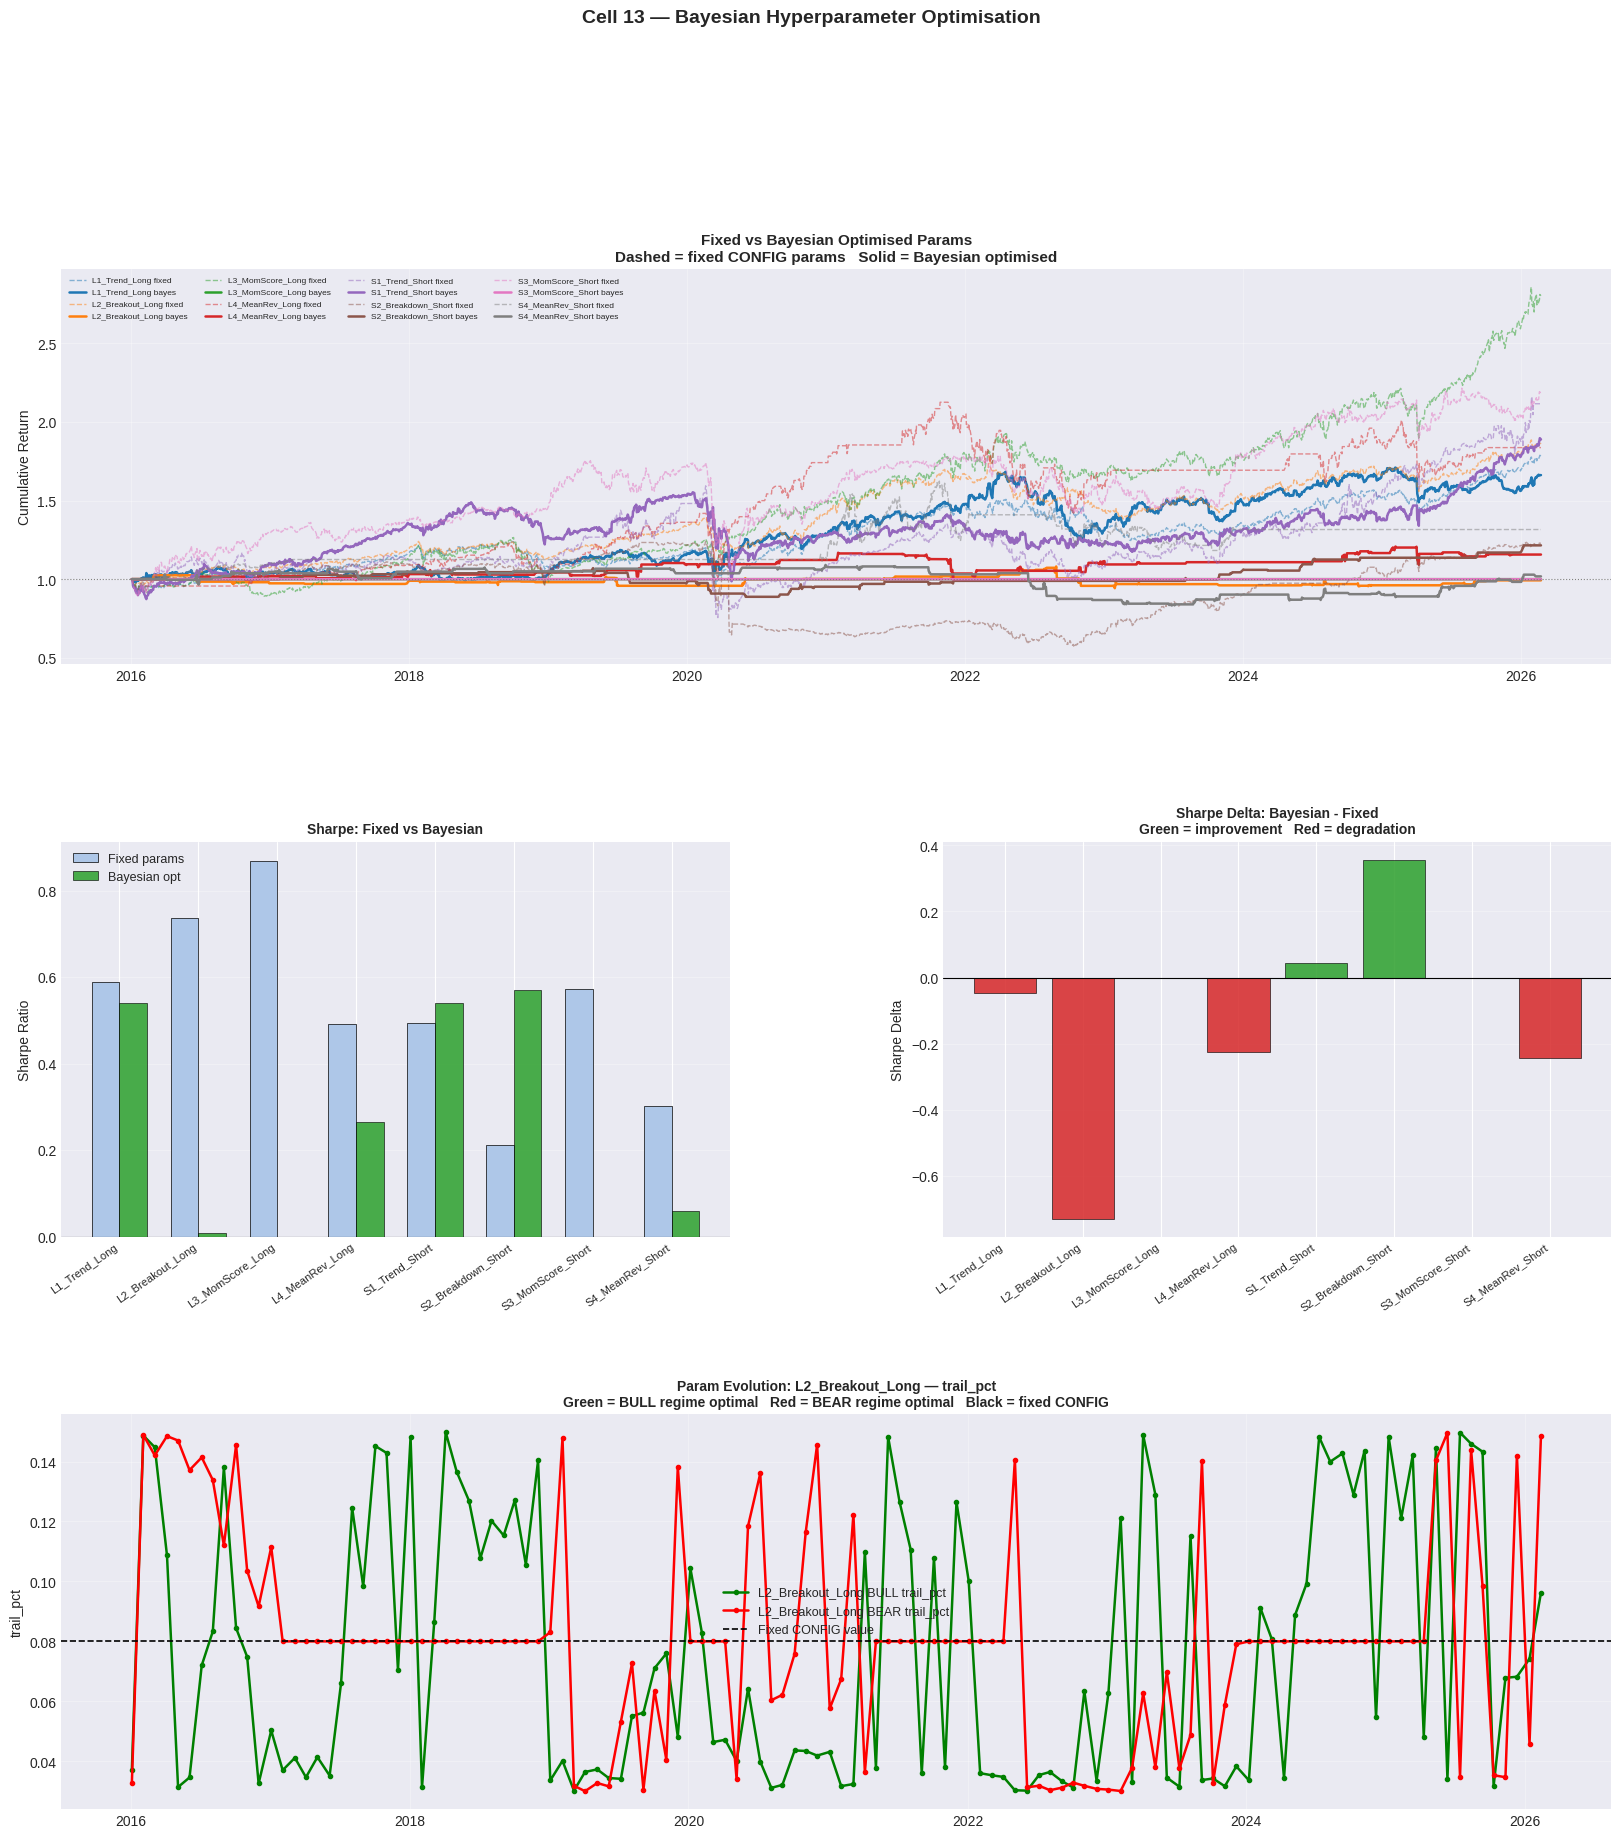


Cell 13 complete
Outputs ready:
  opt_params             — optimised param store
  opt_alpha_returns_df   — optimised return streams
  opt_perf_table         — fixed vs optimised stats
  Cache: bayes_opt_cache.csv

To rerun: set CONFIG['optimisation']['FORCE_RERUN'] = True


In [24]:
# Cell 13: Bayesian Hyperparameter Optimisation
# ============================================================
# Self-contained module — can be run independently of Cells
# 10-12 as long as Cells 0-9 have been executed.
#
# Architecture:
#   - Lightweight Gaussian Process surrogate (numpy only)
#   - UCB acquisition function (handles noisy reward surfaces)
#   - 8 alphas x 2 regimes x 20 iterations per rebalance
#   - Rebalance every 21 days (rolling 252-day train window)
#   - Results cached to CSV; FORCE_RERUN flag controls reruns
#
# Outputs:
#   opt_params      : nested dict
#                     {rebalance_date: {alpha: {regime: params}}}
#   opt_alpha_returns: DataFrame — daily returns using
#                      optimised params (same format as
#                      alpha_returns_df from Cell 6)
#   opt_perf_table  : DataFrame — performance comparison
#                     fixed params vs optimised params


# -- 13a. Add optimisation settings to CONFIG --------------
CONFIG['optimisation'] = {
    'n_iterations':    20,       # Bayesian iterations per alpha/regime
    'n_random_start':  5,        # Random exploration before GP kicks in
    'train_window':    252,      # Days of history used to score params
    'rebalance_every': 21,       # Days between re-optimisations
    'ucb_kappa':       2.0,      # UCB exploration weight
                                 # higher = more exploration
    'min_trades':      10,       # Overfitting guard: min position
                                 # changes in train window
    'max_sharpe_score': 2.5,     # Cap on scoreable Sharpe
                                 # (above = likely curve-fit)
    'oos_validate':    True,     # Score on OOS period before committing
    'cache_file':      'bayes_opt_cache.csv',
    'FORCE_RERUN':     False,    # Set True to ignore cache and rerun
}

print("Optimisation config:")
for k, v in CONFIG['optimisation'].items():
    print(f"  {k:20s}: {v}")


# -- 13b. Parameter search spaces --------------------------
PARAM_SPACE = {
    'L1_Trend_Long': {
        'ema_fast': ('int',   10,  80),
        'ema_slow': ('int',   80, 250),
    },
    'L2_Breakout_Long': {
        'lookback':  ('int',   5,  60),
        'atr_mult':  ('float', 0.05, 0.50),
        'trail_pct': ('float', 0.03, 0.15),
    },
    'L3_MomScore_Long': {
        'lookback': ('int',   120, 300),
        'skip':     ('int',     5,  30),
        'top_pct':  ('float', 0.15, 0.50),
    },
    'L4_MeanRev_Long': {
        'rsi_period': ('int',  7,  21),
        'rsi_entry':  ('int', 20,  40),
        'rsi_exit':   ('int', 45,  70),
    },
    'S1_Trend_Short': {
        'ema_fast': ('int',  10,  80),
        'ema_slow': ('int',  80, 250),
    },
    'S2_Breakdown_Short': {
        'lookback':  ('int',   5,  60),
        'atr_mult':  ('float', 0.05, 0.50),
        'trail_pct': ('float', 0.03, 0.15),
    },
    'S3_MomScore_Short': {
        'lookback':   ('int',   120, 300),
        'skip':       ('int',     5,  30),
        'bottom_pct': ('float', 0.15, 0.50),
    },
    'S4_MeanRev_Short': {
        'rsi_period': ('int',  7,  21),
        'rsi_entry':  ('int', 60,  80),
        'rsi_exit':   ('int', 30,  55),
    },
}

# Alpha signal function map (reuse from Cell 4/5)
ALPHA_FUNC_MAP = {
    'L1_Trend_Long':      alpha_L1_trend_long,
    'L2_Breakout_Long':   alpha_L2_breakout_long,
    'L3_MomScore_Long':   alpha_L3_momscore_long,
    'L4_MeanRev_Long':    alpha_L4_meanrev_long,
    'S1_Trend_Short':     alpha_S1_trend_short,
    'S2_Breakdown_Short': alpha_S2_breakdown_short,
    'S3_MomScore_Short':  alpha_S3_momscore_short,
    'S4_MeanRev_Short':   alpha_S4_meanrev_short,
}

# Which functions need high/low in addition to close
NEEDS_HLC = {
    'L1_Trend_Long':      False,
    'L2_Breakout_Long':   True,
    'L3_MomScore_Long':   False,
    'L4_MeanRev_Long':    True,
    'S1_Trend_Short':     False,
    'S2_Breakdown_Short': True,
    'S3_MomScore_Short':  False,
    'S4_MeanRev_Short':   True,
}


# -- 13c. Gaussian Process surrogate -----------------------

class LightweightGP:
    """
    Minimal Gaussian Process for Bayesian optimisation.
    Uses RBF kernel. Pure numpy — no scipy dependency.

    Attributes:
        X_obs : observed parameter vectors (n_obs, n_dims)
        y_obs : observed scores (n_obs,)
        noise : observation noise (regularisation)
        ls    : length scale for RBF kernel
    """

    def __init__(self, noise: float = 1e-4, ls: float = 0.5):
        self.noise  = noise
        self.ls     = ls
        self.X_obs  = None
        self.y_obs  = None
        self._K_inv = None

    def _rbf_kernel(self,
                    X1: np.ndarray,
                    X2: np.ndarray) -> np.ndarray:
        """RBF (squared exponential) kernel."""
        diff = X1[:, None, :] - X2[None, :, :]
        return np.exp(-0.5 * np.sum(diff ** 2, axis=-1)
                      / self.ls ** 2)

    def fit(self,
            X: np.ndarray,
            y: np.ndarray) -> None:
        """Fit GP to observed (X, y) pairs."""
        self.X_obs = X
        self.y_obs = (y - y.mean()) / (y.std() + 1e-8)
        K          = self._rbf_kernel(X, X)
        K         += self.noise * np.eye(len(X))
        try:
            self._K_inv = np.linalg.inv(K)
        except np.linalg.LinAlgError:
            self._K_inv = np.linalg.pinv(K)

    def predict(self,
                X_new: np.ndarray) -> tuple:
        """
        Returns (mean, std) predictions at X_new.
        """
        if self.X_obs is None or len(self.X_obs) == 0:
            return (np.zeros(len(X_new)),
                    np.ones(len(X_new)))

        K_s  = self._rbf_kernel(X_new, self.X_obs)
        K_ss = self._rbf_kernel(X_new, X_new)

        mu   = K_s @ self._K_inv @ self.y_obs
        cov  = K_ss - K_s @ self._K_inv @ K_s.T
        std  = np.sqrt(np.maximum(np.diag(cov), 1e-8))
        return mu, std

    def ucb(self,
            X_new: np.ndarray,
            kappa: float = 2.0) -> np.ndarray:
        """Upper Confidence Bound acquisition."""
        mu, std = self.predict(X_new)
        return mu + kappa * std


# -- 13d. Parameter encoding / decoding -------------------

def encode_params(params: dict,
                  space: dict) -> np.ndarray:
    """
    Normalise params to [0, 1] for GP input.
    """
    vec = []
    for key, (dtype, lo, hi) in space.items():
        val = params.get(key, (lo + hi) / 2)
        vec.append((val - lo) / (hi - lo))
    return np.array(vec)


def decode_params(vec: np.ndarray,
                  space: dict) -> dict:
    """
    Decode normalised [0,1] vector back to param dict.
    Enforces int/float types and valid constraints.
    """
    params = {}
    for i, (key, (dtype, lo, hi)) in enumerate(space.items()):
        val = float(vec[i]) * (hi - lo) + lo
        val = float(np.clip(val, lo, hi))
        params[key] = int(round(val)) if dtype == 'int' else val
    return params


def enforce_constraints(params: dict,
                         alpha_name: str) -> dict:
    """
    Hard constraints to keep params logically consistent.
    """
    p = params.copy()

    # EMA: fast must be < slow
    if 'ema_fast' in p and 'ema_slow' in p:
        if p['ema_fast'] >= p['ema_slow']:
            p['ema_fast'] = max(10,
                                p['ema_slow'] - 20)

    # RSI long: entry < exit
    if alpha_name == 'L4_MeanRev_Long':
        if 'rsi_entry' in p and 'rsi_exit' in p:
            if p['rsi_entry'] >= p['rsi_exit']:
                p['rsi_entry'] = max(20,
                                     p['rsi_exit'] - 10)

    # RSI short: entry > exit
    if alpha_name == 'S4_MeanRev_Short':
        if 'rsi_entry' in p and 'rsi_exit' in p:
            if p['rsi_entry'] <= p['rsi_exit']:
                p['rsi_entry'] = min(80,
                                     p['rsi_exit'] + 10)

    return p


# -- 13e. Scoring function ---------------------------------

def score_params(alpha_name: str,
                 params: dict,
                 close_w: pd.DataFrame,
                 high_w: pd.DataFrame,
                 low_w: pd.DataFrame,
                 returns_w: pd.DataFrame,
                 cfg_opt: dict) -> float:
    """
    Evaluate a parameter set on a data window.
    Returns penalised Sharpe.

    Args:
        alpha_name : name of alpha being scored
        params     : parameter dict to evaluate
        close_w    : close prices for window
        high_w     : high prices for window
        low_w      : low prices for window
        returns_w  : daily returns for window
        cfg_opt    : optimisation config dict

    Returns:
        float — penalised Sharpe (higher = better)
    """
    try:
        func = ALPHA_FUNC_MAP[alpha_name]
        side = SIDE[alpha_name]

        # Merge alpha params with any fixed params
        # not in the search space
        full_params = CONFIG['alphas'][alpha_name].copy()
        full_params.update(params)

        # Generate signal
        if NEEDS_HLC[alpha_name]:
            sig = func(close_w, high_w, low_w, full_params)
        else:
            sig = func(close_w, full_params)

        # Compute returns
        position    = sig * side
        pos_aligned = position.reindex(
            returns_w.index).fillna(0)
        net         = apply_costs(returns_w,
                                  pos_aligned,
                                  CONFIG['cost_bps'])

        # Equal-weight aggregate
        n_active  = sig.sum(axis=1).replace(0, np.nan)
        signed    = sig * side
        daily_pnl = (net * signed.reindex(
            net.index).fillna(0)).sum(axis=1)
        port_ret  = (daily_pnl / n_active).fillna(0)

        # Count trades (position changes)
        mean_sig  = sig.mean(axis=1)
        n_trades  = (mean_sig.diff().abs() > 0.05).sum()

        if len(port_ret) < 20:
            return -999.0

        # Raw Sharpe
        mu     = port_ret.mean()
        std    = port_ret.std()
        sharpe = (mu / std * np.sqrt(252)
                  if std > 0 else -999.0)

        # Overfitting penalties
        # 1. Too few trades
        trade_penalty = max(0.0,
                            1.0 - n_trades /
                            cfg_opt['min_trades'])

        # 2. Suspiciously high Sharpe
        cap   = cfg_opt['max_sharpe_score']
        sharpe_penalty = max(
            0.0, (sharpe - cap) / cap
        ) if sharpe > cap else 0.0

        penalised = (sharpe
                     * (1 - trade_penalty)
                     * (1 - sharpe_penalty))

        return float(np.clip(penalised, -5.0, cap))

    except Exception:
        return -999.0


# -- 13f. Bayesian optimiser -------------------------------

def bayesian_optimise(alpha_name: str,
                       space: dict,
                       close_w: pd.DataFrame,
                       high_w: pd.DataFrame,
                       low_w: pd.DataFrame,
                       returns_w: pd.DataFrame,
                       cfg_opt: dict) -> tuple:
    """
    Run Bayesian optimisation for one alpha on one window.

    Returns:
        best_params : dict of optimised parameters
        best_score  : float — best penalised Sharpe found
        history     : list of (params, score) tuples
    """
    n_iter    = cfg_opt['n_iterations']
    n_random  = cfg_opt['n_random_start']
    kappa     = cfg_opt['ucb_kappa']
    n_dims    = len(space)

    gp        = LightweightGP(noise=1e-4, ls=0.5)
    X_obs     = []
    y_obs     = []
    history   = []
    best_score  = -np.inf
    best_params = decode_params(
        np.array([0.5] * n_dims), space
    )

    for iteration in range(n_iter):

        if iteration < n_random:
            # Random exploration phase
            vec = np.random.uniform(0, 1, n_dims)
        else:
            # GP-guided phase: sample candidates,
            # pick the one with highest UCB
            gp.fit(np.array(X_obs), np.array(y_obs))

            # Sample 200 candidates and score with UCB
            candidates = np.random.uniform(
                0, 1, (200, n_dims)
            )
            ucb_scores  = gp.ucb(candidates, kappa=kappa)
            vec         = candidates[np.argmax(ucb_scores)]

        # Decode, enforce constraints, score
        params  = decode_params(vec, space)
        params  = enforce_constraints(params, alpha_name)
        vec_enc = encode_params(params, space)
        score   = score_params(
            alpha_name, params,
            close_w, high_w, low_w, returns_w, cfg_opt
        )

        X_obs.append(vec_enc)
        y_obs.append(score)
        history.append((params.copy(), score))

        if score > best_score:
            best_score  = score
            best_params = params.copy()

    return best_params, best_score, history


# -- 13g. Walk-forward optimisation loop -------------------

def run_walk_forward_optimisation(
        close: pd.DataFrame,
        high: pd.DataFrame,
        low: pd.DataFrame,
        returns: pd.DataFrame,
        trend_regime: pd.Series,
        cfg_opt: dict,
        verbose: bool = True) -> dict:
    """
    Walk-forward Bayesian optimisation.
    Reoptimises every rebalance_every days.
    Produces separate param sets for BULL and BEAR regimes.

    Returns:
        opt_params : {date: {alpha_name: {'BULL': params,
                                          'BEAR': params}}}
    """
    train_w    = cfg_opt['train_window']
    rebal_days = cfg_opt['rebalance_every']
    opt_params = {}

    # Rebalance dates: every N days after warmup
    all_dates   = close.index
    rebal_dates = all_dates[train_w::rebal_days]

    total = len(rebal_dates) * len(ALPHA_NAMES) * 2
    done  = 0

    print(f"  Walk-forward schedule:")
    print(f"    Train window  : {train_w} days")
    print(f"    Rebal every   : {rebal_days} days")
    print(f"    Rebal dates   : {len(rebal_dates)}")
    print(f"    Total runs    : {total} "
          f"(alphas x regimes x rebalances)")
    print(f"  Starting optimisation...")

    for rebal_date in rebal_dates:
        date_str   = str(rebal_date.date())
        opt_params[date_str] = {}

        # Training window slice
        end_pos   = all_dates.get_loc(rebal_date)
        start_pos = max(0, end_pos - train_w)

        close_w   = close.iloc[start_pos:end_pos]
        high_w    = high.iloc[start_pos:end_pos]
        low_w     = low.iloc[start_pos:end_pos]
        returns_w = returns.iloc[start_pos:end_pos]
        regime_w  = trend_regime.iloc[start_pos:end_pos]

        # Split window into BULL and BEAR days
        bull_idx  = regime_w[regime_w == 'BULL'].index
        bear_idx  = regime_w[regime_w == 'BEAR'].index

        for alpha_name in ALPHA_NAMES:
            opt_params[date_str][alpha_name] = {}
            space = PARAM_SPACE[alpha_name]

            for regime_label, regime_idx in [
                ('BULL', bull_idx),
                ('BEAR', bear_idx)
            ]:
                # Need enough data to score meaningfully
                if len(regime_idx) < 30:
                    # Fall back to CONFIG defaults
                    opt_params[date_str][alpha_name]\
                        [regime_label] = \
                        CONFIG['alphas'][alpha_name].copy()
                    done += 1
                    continue

                c_r = close_w.loc[regime_idx]
                h_r = high_w.loc[regime_idx]
                l_r = low_w.loc[regime_idx]
                ret_r = returns_w.loc[regime_idx]

                best_p, best_s, _ = bayesian_optimise(
                    alpha_name, space,
                    c_r, h_r, l_r, ret_r,
                    cfg_opt
                )

                opt_params[date_str][alpha_name]\
                    [regime_label] = best_p

                done += 1
                if verbose and done % 20 == 0:
                    pct = done / total * 100
                    print(f"    [{pct:5.1f}%] "
                          f"{date_str} | "
                          f"{alpha_name} | "
                          f"{regime_label} | "
                          f"best score: {best_s:.3f}")

    return opt_params


# -- 13h. Cache logic --------------------------------------

import os
import json

cache_file = CONFIG['optimisation']['cache_file']
force_rerun = CONFIG['optimisation']['FORCE_RERUN']

if os.path.exists(cache_file) and not force_rerun:
    print(f"Loading cached optimisation results "
          f"from {cache_file}...")
    with open(cache_file, 'r') as f:
        opt_params = json.load(f)
    print(f"  Loaded {len(opt_params)} rebalance dates")
else:
    print("Running walk-forward Bayesian optimisation...")
    print("(This will take several minutes in Colab)\n")

    np.random.seed(42)
    opt_params = run_walk_forward_optimisation(
        close      = close,
        high       = high,
        low        = low,
        returns    = returns,
        trend_regime = trend_regime,
        cfg_opt    = CONFIG['optimisation'],
        verbose    = True
    )

    # Save to cache
    with open(cache_file, 'w') as f:
        json.dump(opt_params, f, indent=2)
    print(f"\nResults cached to {cache_file}")
    print(f"Set FORCE_RERUN=False to reload on next run")


# -- 13i. Build optimised alpha returns --------------------
print("\nBuilding optimised alpha return streams...")

opt_alpha_returns = {}

# Get sorted rebalance dates
rebal_date_strs = sorted(opt_params.keys())
rebal_dates_ts  = [pd.Timestamp(d) for d in rebal_date_strs]

for alpha_name in ALPHA_NAMES:
    func  = ALPHA_FUNC_MAP[alpha_name]
    side  = SIDE[alpha_name]
    space = PARAM_SPACE[alpha_name]

    # Build a daily param lookup based on regime
    # Each day uses the most recent rebalance's optimised params
    daily_returns_list = []

    for i, rebal_ts in enumerate(rebal_dates_ts):
        # Determine the period this rebalance covers
        start_ts = rebal_ts
        end_ts   = (rebal_dates_ts[i + 1]
                    if i < len(rebal_dates_ts) - 1
                    else close.index[-1])

        period_idx = close.index[
            (close.index >= start_ts) &
            (close.index < end_ts)
        ]

        if len(period_idx) == 0:
            continue

        close_p   = close.loc[period_idx]
        high_p    = high.loc[period_idx]
        low_p     = low.loc[period_idx]
        returns_p = returns.loc[period_idx]
        regime_p  = trend_regime.loc[period_idx]

        date_str  = str(rebal_ts.date())

        # For each day in the period, use regime-matched params
        # We compute two signals (BULL and BEAR params)
        # and select per day
        p_bull = opt_params.get(date_str, {}).get(
            alpha_name, {}).get(
            'BULL', CONFIG['alphas'][alpha_name])
        p_bear = opt_params.get(date_str, {}).get(
            alpha_name, {}).get(
            'BEAR', CONFIG['alphas'][alpha_name])

        # Full params (merge with CONFIG defaults)
        full_bull = CONFIG['alphas'][alpha_name].copy()
        full_bull.update(p_bull)
        full_bear = CONFIG['alphas'][alpha_name].copy()
        full_bear.update(p_bear)

        # Compute signals under each param set
        if NEEDS_HLC[alpha_name]:
            sig_bull = func(close_p, high_p,
                            low_p, full_bull)
            sig_bear = func(close_p, high_p,
                            low_p, full_bear)
        else:
            sig_bull = func(close_p, full_bull)
            sig_bear = func(close_p, full_bear)

        # Select signal based on daily regime
        bull_days = (regime_p == 'BULL')
        bear_days = (regime_p == 'BEAR')

        sig_combined = sig_bull.copy()
        sig_combined.loc[bear_days] = \
            sig_bear.loc[bear_days]

        # Compute net returns
        position    = sig_combined * side
        pos_aligned = position.reindex(
            returns_p.index).fillna(0)
        net         = apply_costs(returns_p,
                                  pos_aligned,
                                  CONFIG['cost_bps'])

        # Equal-weight aggregate
        n_active  = sig_combined.sum(axis=1).replace(
            0, np.nan)
        signed    = sig_combined * side
        daily_pnl = (net * signed.reindex(
            net.index).fillna(0)).sum(axis=1)
        port_ret  = (daily_pnl / n_active).fillna(0)

        daily_returns_list.append(port_ret)

    if daily_returns_list:
        opt_alpha_returns[alpha_name] = pd.concat(
            daily_returns_list
        ).sort_index()

opt_alpha_returns_df = pd.DataFrame(
    opt_alpha_returns).fillna(0)

# Trim to common index
common_idx = alpha_returns_df.index.intersection(
    opt_alpha_returns_df.index)
opt_alpha_returns_df = opt_alpha_returns_df.loc[common_idx]
base_returns_df      = alpha_returns_df.loc[common_idx]

print(f"  Optimised returns shape: "
      f"{opt_alpha_returns_df.shape}")


# -- 13j. Performance comparison ---------------------------
print("\nComparing fixed vs optimised params...")

comparison_rows = []
for alpha_name in ALPHA_NAMES:
    base_r = base_returns_df[alpha_name]
    opt_r  = opt_alpha_returns_df[alpha_name]

    base_stats = full_performance(
        base_r, name=f'{alpha_name}_fixed')
    opt_stats  = full_performance(
        opt_r,  name=f'{alpha_name}_bayes')

    comparison_rows.append(base_stats)
    comparison_rows.append(opt_stats)

opt_perf_table = pd.DataFrame(comparison_rows)

display_cols = ['Ann. Return', 'Ann. Vol', 'Sharpe',
                'Max Drawdown', 'Calmar']

print("\nFixed vs Bayesian Optimised Params:")
print("=" * 65)
print(opt_perf_table[display_cols].round(3).to_string())


# -- 13k. Visualisation ------------------------------------
print("\nBuilding optimisation dashboard...")

fig = plt.figure(figsize=(20, 20))
gs  = gridspec.GridSpec(3, 2, figure=fig,
                         hspace=0.45, wspace=0.32)


# ── Panel 1: Equity curves — fixed vs optimised -----------
ax1 = fig.add_subplot(gs[0, :])
colors_fixed = plt.cm.tab10.colors
for i, alpha_name in enumerate(ALPHA_NAMES):
    base_cum = (1 + base_returns_df[alpha_name]).cumprod()
    opt_cum  = (1 + opt_alpha_returns_df[
        alpha_name]).cumprod()
    c = colors_fixed[i]
    ax1.plot(base_cum.index, base_cum,
             color=c, linewidth=1.0,
             linestyle='--', alpha=0.5,
             label=f'{alpha_name} fixed')
    ax1.plot(opt_cum.index, opt_cum,
             color=c, linewidth=1.8,
             label=f'{alpha_name} bayes')

ax1.axhline(1, color='grey',
            linewidth=0.8, linestyle=':')
ax1.set_title(
    'Fixed vs Bayesian Optimised Params\n'
    'Dashed = fixed CONFIG params   '
    'Solid = Bayesian optimised',
    fontweight='bold', fontsize=11
)
ax1.set_ylabel('Cumulative Return')
ax1.legend(fontsize=6, ncol=4)
ax1.grid(True, alpha=0.3)


# ── Panel 2: Sharpe improvement bar chart -----------------
ax2 = fig.add_subplot(gs[1, 0])
fixed_sharpes = [
    full_performance(
        base_returns_df[n])['Sharpe']
    for n in ALPHA_NAMES
]
opt_sharpes = [
    full_performance(
        opt_alpha_returns_df[n])['Sharpe']
    for n in ALPHA_NAMES
]

x     = np.arange(len(ALPHA_NAMES))
width = 0.35

ax2.bar(x - width/2, fixed_sharpes,
        width, label='Fixed params',
        color='#aec7e8', edgecolor='black',
        linewidth=0.5)
ax2.bar(x + width/2, opt_sharpes,
        width, label='Bayesian opt',
        color='#2ca02c', edgecolor='black',
        linewidth=0.5, alpha=0.85)

ax2.axhline(0, color='black', linewidth=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels(ALPHA_NAMES,
                    rotation=35, ha='right',
                    fontsize=8)
ax2.set_title('Sharpe: Fixed vs Bayesian',
              fontweight='bold', fontsize=10)
ax2.set_ylabel('Sharpe Ratio')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')


# ── Panel 3: Sharpe improvement delta ---------------------
ax3 = fig.add_subplot(gs[1, 1])
deltas = [o - f for o, f in
          zip(opt_sharpes, fixed_sharpes)]
bar_colors = ['#2ca02c' if d >= 0
              else '#d62728' for d in deltas]
ax3.bar(x, deltas,
        color=bar_colors,
        edgecolor='black', linewidth=0.5,
        alpha=0.85)
ax3.axhline(0, color='black', linewidth=0.8)
ax3.set_xticks(x)
ax3.set_xticklabels(ALPHA_NAMES,
                    rotation=35, ha='right',
                    fontsize=8)
ax3.set_title('Sharpe Delta: Bayesian - Fixed\n'
              'Green = improvement   '
              'Red = degradation',
              fontweight='bold', fontsize=10)
ax3.set_ylabel('Sharpe Delta')
ax3.grid(True, alpha=0.3, axis='y')


# ── Panel 4: Optimised param evolution for L2 -------------
# Show how the best params shift over time
ax4 = fig.add_subplot(gs[2, :])
param_name  = 'trail_pct'
alpha_track = 'L2_Breakout_Long'

if param_name in PARAM_SPACE.get(alpha_track, {}):
    bull_vals, bear_vals, dates_plot = [], [], []
    for date_str in sorted(opt_params.keys()):
        alpha_d = opt_params[date_str].get(
            alpha_track, {})
        b_val = alpha_d.get('BULL', {}).get(
            param_name, np.nan)
        r_val = alpha_d.get('BEAR', {}).get(
            param_name, np.nan)
        bull_vals.append(b_val)
        bear_vals.append(r_val)
        dates_plot.append(pd.Timestamp(date_str))

    ax4.plot(dates_plot, bull_vals,
             color='green', linewidth=1.8,
             marker='o', markersize=3,
             label=f'{alpha_track} BULL {param_name}')
    ax4.plot(dates_plot, bear_vals,
             color='red', linewidth=1.8,
             marker='o', markersize=3,
             label=f'{alpha_track} BEAR {param_name}')
    ax4.axhline(
        CONFIG['alphas'][alpha_track].get(
            param_name, np.nan),
        color='black', linewidth=1.2,
        linestyle='--',
        label='Fixed CONFIG value'
    )
    ax4.set_title(
        f'Param Evolution: {alpha_track} — '
        f'{param_name}\n'
        f'Green = BULL regime optimal   '
        f'Red = BEAR regime optimal   '
        f'Black = fixed CONFIG',
        fontweight='bold', fontsize=10
    )
    ax4.set_ylabel(param_name)
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)

fig.suptitle(
    'Cell 13 — Bayesian Hyperparameter Optimisation',
    fontsize=14, fontweight='bold', y=1.01
)

plt.savefig('bayes_opt_dashboard.png',
            dpi=150, bbox_inches='tight')
plt.show()

print("\nCell 13 complete")
print(f"Outputs ready:")
print(f"  opt_params             — optimised param store")
print(f"  opt_alpha_returns_df   — optimised return streams")
print(f"  opt_perf_table         — fixed vs optimised stats")
print(f"  Cache: {cache_file}")
print(f"\nTo rerun: set "
      f"CONFIG['optimisation']['FORCE_RERUN'] = True")